# Consumer Complaint Text Classification

Customer service is vital in many industries. Helping and responding to your consumers swiftly and accurately plays a crucial role in retaining customers by keeping them saitsfied and informed. 
One way of increasing speed and efficiency in dealing with these situations is to have a program that immediately classifies a type of complaint or inquiry of a consumer and directly directs them to experts in respective areas. This saves time for both the customers and the businesses by getting rid of an entire layer of communication.

In this notebook, different models are used and compared in solving the problem of classifying financial complaints from the US Consumer Finance Complaints available on Kaggle. Codes/scripts were inspired/brought from works of Susan Li (https://towardsdatascience.com/@actsusanli) and zqhZY (https://github.com/zqhZY?tab=repositories) and modified to different extents to either fit the problem or (to attempt) to enhance the results.

In [152]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

### Cleaning Data (this step does not have to be run if you replace the dataset with the already cleaned 'complaints_cleaned.csv' or complaints_cleaned_label.csv' datasets).
First load the data.

In [ ]:
df = pd.read_csv('consumer_complaints.csv')
df.reset_index()
df.head()

Drop all rows that do not have complaints as they are not particularly useful. This drastically reduces the amount of data.

In [ ]:
df = df[['product', 'consumer_complaint_narrative']]

df = df.dropna()
df.head()

In [ ]:
df.shape

To have an idea of the data distribution of the categories, plot the data. It can be seen that debt collection has the largest amount of relevant complaints. Although in some situations normalizing the amount may be helpful, in this case taking in count what consumers generally complain the most about may actually help us better predict the categories.

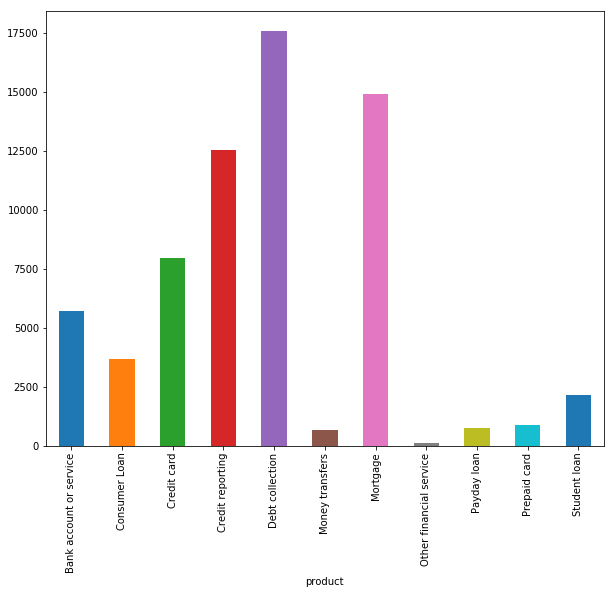

In [5]:
fig = plt.figure(figsize=(10,8))
df.groupby('product').consumer_complaint_narrative.count().plot.bar(ylim=0)
plt.show()

In [6]:
df['consumer_complaint_narrative'].apply(lambda x: len(x.split(' '))).sum()

12804227

Before anything, it's good to make sure that all the words are clean, meaning not having punctuations next to them and also get rid of the random slahes (/) and 'X' that appears in the data.

In [7]:

from bs4 import BeautifulSoup
import re
def cleanText(text):
    text = BeautifulSoup(text, "lxml").text
    text = re.sub(r'\|\|\|', r' ', text) 
    text = re.sub(r'http\S+', r'<URL>', text)
    text = text.lower()
    text = text.replace('x', '')
    text = text.replace('/', '')
    return text

We only need complaints and products categories for this task.

In [8]:
df['consumer_complaint_narrative'] = df['consumer_complaint_narrative'].apply(cleanText)


In [9]:
df = df[['product', 'consumer_complaint_narrative']]
df.head()

product                       consumer_complaint_narrative
190126  Debt collection   has claimed i owe them {$27.00} for  years de...
190135    Consumer Loan  due to inconsistencies in the amount owed that...
190155         Mortgage  in  my wages that i earned at my job decreased...
190207         Mortgage  i have an open and current mortgage with chase...
190208         Mortgage   was submitted . at the time i submitted this ...

### Logistic + Doc2Vec

Word2Vec is a numeric interpretation of individual words.
Doc2Vec is the same, but with documents.
Generally good for sentence similarity tasks, so it seemed like a reasonable approach when trying to predict consumer complaint topics.


Here we label the complaints as reuired of Doc2Vec. At the end, the format will look something like: train_i, test_i  (i being the index).

In [10]:

from gensim.models import doc2vec

def label_sentences(corpus, label_type):
   
    labeled = []
    for i, v in enumerate(corpus):
        label = label_type + '_' + str(i)
        labeled.append(doc2vec.TaggedDocument(v.split(), [label]))
    return labeled

C:\Users\Hoyoung Jun\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


Split dataset.

In [11]:
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(df['consumer_complaint_narrative'], df['product'], random_state=0, test_size=0.3)
X_train = label_sentences(X_train, 'Train')
X_test = label_sentences(X_test, 'Test')
all_data = X_train + X_test

Now, train a Doc2Vec model with Distributed Bag of Words (DBOW) using the Gensim package. The DBOW, according to Le and Mikolov, samples a text window at each iteration. Then, it samples a random word from the text window and forms a classification task given the Paragraph Vector.

In [17]:
from gensim.models import Doc2Vec
from tqdm import tqdm

model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, min_count=1, alpha=0.065, min_alpha=0.065)
model_dbow.build_vocab([x for x in tqdm(all_data)])

100%|███████████████████████████████████████████████████████████████████████| 66806/66806 [00:00<00:00, 2270076.91it/s]


In [ ]:
from sklearn import utils


for epoch in range(30):
    model_dbow.train(utils.shuffle([x for x in tqdm(all_data)]), total_examples=len(all_data), epochs=1)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha

In [ ]:

def get_vectors(model, corpus_size, vectors_size, vectors_type):
    
    vectors = np.zeros((corpus_size, vectors_size))
    for i in range(0, corpus_size):
        prefix = vectors_type + '_' + str(i)
        vectors[i] = model.docvecs[prefix]
    return vectors

In [97]:
train_vectors_dbow = get_vectors(model_dbow, len(X_train), 300, 'Train')
test_vectors_dbow = get_vectors(model_dbow, len(X_test), 300, 'Test')

Use Logistic Regression with the doc2vec embeddings.

In [98]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(multi_class='multinomial', solver = 'lbfgs')
logreg.fit(train_vectors_dbow, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=1, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [99]:
logreg.score(test_vectors_dbow, y_test)

0.8111964873765093

The accuracy above is pretty good considering that previous similar implementations of this achieved around 65~70%. Below, we save the DBOW model.

In [100]:

model_dbow.save('d2v_model_dbow.doc2vec')

Up next is Doc2Vec with Distributed Memory(DM). DM acts as a memory that remembers what is missing from the current context.  

In [101]:
model_dm = Doc2Vec(dm=1, dm_mean=1, vector_size=300, window=10, negative=5, min_count=1, workers=5, alpha=0.065, min_alpha=0.065)
model_dm.build_vocab([x for x in tqdm(all_data)])

100%|███████████████████████████████████████████████████████████████████████| 66806/66806 [00:00<00:00, 1795919.02it/s]


In [102]:
for epoch in range(30):
    model_dm.train(utils.shuffle([x for x in tqdm(all_data)]), total_examples=len(all_data), epochs=1)
    model_dm.alpha -= 0.002
    model_dm.min_alpha = model_dm.alpha

100%|███████████████████████████████████████████████████████████████████████| 66806/66806 [00:00<00:00, 1547989.49it/s]


In [103]:
train_vectors_dm = get_vectors(model_dm, len(X_train), 300, 'Train')
test_vectors_dm = get_vectors(model_dm, len(X_test), 300, 'Test')

In [104]:
logreg.fit(train_vectors_dm, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=1, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [105]:
logreg.score(test_vectors_dm, y_test)

0.7736752819079932

The accuracy for this is a bit lower than DBOW, but still relatively higher than other previous similar implementations (40~60%)

In [106]:
model_dm.save('d2v_model_dm.doc2vec')

In [107]:
model_dbow.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)
model_dm.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)

It has been said that combining these two can lead to better results. The function below concactenates the results genrated from DBOW and DM.

In [108]:
def get_concat_vectors(model1, model2, corpus_size, vectors_size, vectors_type):
    vectors = np.zeros((corpus_size, vectors_size))
    for i in range(0, corpus_size):
        prefix = vectors_type + '_' + str(i)
        vectors[i] = np.append(model1.docvecs[prefix], model2.docvecs[prefix])
    return vectors

In [109]:
train_vecs_dbow_dm = get_concat_vectors(model_dbow, model_dm, len(X_train), 600, 'Train')
test_vecs_dbow_dm = get_concat_vectors(model_dbow, model_dm, len(X_test), 600, 'Test')

In [110]:
logreg = LogisticRegression()
logreg.fit(train_vecs_dbow_dm, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [111]:
logreg.score(test_vecs_dbow_dm, y_test)

0.8221235405648138

And the rumors are right! The model has been improved by a drastic 1%!

below we save a cleaned csv file.

In [35]:
df = df.applymap(cleanText)


In [66]:

df.to_csv('complaints_cleaned.csv')

### CNN and LSTM
Below, CNN and LSTM will be used to tackle this problem. By doing both we would be able to see a clear comparison between a CNN and a type of RNN model to see which one is better for this particular text classification problem. The LSTM will also be using the DBOW model we trained earlier in the hopes that this will help in finding relationships or links between complaints and categories.

PyTorch will be used from here on.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from importlib import reload

class TextCNN(nn.Module):

    def __init__(self, vocab_size, embed_dim, num_classes, kernel_num, kernel_sizes, dropout):
        super(TextCNN, self).__init__()

        
        V = vocab_size
        D = embed_dim
        C = num_classes
        Cin = 1
        Cout = kernel_num
        Ks = kernel_sizes


        self.embeding = nn.Embedding(V, D)
        self.convs = nn.ModuleList([nn.Conv2d(Cin, Cout, (K, D)) for K in Ks])

        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(len(Ks) * Cout, C)

    def conv_and_pool(self, x, conv):
        x = F.relu(conv(x)).squeeze(3)  # (N,Co,W)
        x = F.max_pool1d(x, x.size(2)).squeeze(2)
        return x

    def forward(self, x):
        x = self.embeding(x)

        x = x.unsqueeze(1)
        x= [F.relu(conv(x).squeeze(3)) for conv in self.convs]
        x = [F.max_pool1d(i, i.size(2)).squeeze(2) for i in x]
        x = torch.cat(x, 1)

        '''
                x1 = self.conv_and_pool(x,self.conv13) #(N,Co)
                x2 = self.conv_and_pool(x,self.conv14) #(N,Co)
                x3 = self.conv_and_pool(x,self.conv15) #(N,Co)
                x = torch.cat((x1, x2, x3), 1) # (N,len(Ks)*Co)
        '''
        x = self.dropout(x)
        out = self.fc(x)
        return out

In [160]:
from torch import nn
import torch
import numpy as np


class TextLSTM(nn.Module):
    """
    lstm model of text classify.
    """
    def __init__(self, vocab_size, hidden_size, linear_hidden_size, 
                 embed_dim, num_classes, embedding_path):
        self.name = "TextLstm"
        super(TextLSTM, self).__init__()
        

        self.embedding = nn.Embedding(vocab_size, embed_dim)

        self.lstm = nn.LSTM(input_size = embed_dim,
                            hidden_size = hidden_size,
                            num_layers = 1,
                            batch_first = True,
                            bidirectional = False)

        self.linears = nn.Sequential(
            nn.Linear(hidden_size, linear_hidden_size),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(linear_hidden_size, num_classes),
         
        )

        #if embedding_path:
         #   self.embedding.weight.data.copy_(torch.from_numpy
          #                                   (np.load(embedding_path)))
    

    def forward(self, x):
        x = self.embedding(x)
        print (x)
        lstm_out, _ = self.lstm(x)

      
        out = self.linears(lstm_out[:, -1, :])
       
        return out


In [ ]:
import sys
import torch
import os
import torch.autograd as autograd
import torch.nn.functional as F


def fit(train, val, model, cuda, lr, epochs):

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    h = []
    v = []

    t = []
 
    
    if cuda:
        model.cuda()
    steps = 0
    model.train()
    best_accuracy = 0
    for epoch in range(1, epochs + 1):
        for batch in train:
            print(batch)
            feature, target = batch.consumer_complaint_narrative, batch.category_id
      
            
            feature.data.t_()
            target.data.sub_(1)

            if cuda:
                feature, target = feature.cuda(), target.cuda()
            optimizer.zero_grad()

            out = model(feature)
            
      
            loss = F.cross_entropy(out, target)
            loss.backward()
            optimizer.step()

            steps += 1
            if steps % 2 == 0:
                # print torch.max(out, 1)[1].view(target.size()).data
                corrects = (torch.max(out, 1)[1].view(target.size()).data == target.data).double().sum()
                accuracy = 100.0 * corrects / batch.batch_size
                sys.stdout.write(
                    '\rBatch[{}] - loss: {:.6f}  acc: {:.4f}%({}/{})'.format(steps,
                                                                             loss.item(),
                                                                             accuracy,
                                                                             corrects,
                                                                             batch.batch_size))
                
            if steps % 20 == 0:
                current_accuracy = eval(val, model, cuda)
                if current_accuracy > best_accuracy:
                    best_accuracy = current_accuracy

                    print("save model at step %s, accuracy is %d".format(str(steps), current_accuracy))
   
                    torch.save(model, 'save_pathff')
                
                h.append(steps)
                v.append(current_accuracy)
            
    plt.xlabel('Steps')
    plt.ylabel('Development Accuracy')    
    plt.plot(h, v)
        


def eval(data_iter, model, cuda):
    model.eval()
    
    corrects, avg_loss = 0, 0


    for batch in data_iter:
        feature, target = batch.consumer_complaint_narrative, batch.category_id
        target.data.sub_(1)  # batch first, index align
        feature.data.t_()
      

        if cuda:
            feature, target = feature.cuda(), target.cuda()

        logit = model(feature)
        loss = F.cross_entropy(logit, target, size_average=False)

        avg_loss += loss.item()
        corrects += (torch.max(logit, 1)
                     [1].view(target.size()).data == target.data).double().sum()

    size = len(data_iter.dataset)
    avg_loss = loss.item() / size
    accuracy = 100.0 * corrects / size
    model.train()
    print('\nEvaluation - loss: {:.6f}  acc: {:.4f}%({}/{}) \n'.format(avg_loss,
                                                                       accuracy,
                                                                       corrects,
                                                                        size))
    return accuracy

In [150]:
import random
from torchtext import data
from torchtext.data import Dataset
from sklearn.model_selection import KFold
import numpy as np


class MyDataset(data.TabularDataset):
    """
    """

    def splits(self, fields, dev_ratio=.15, shuffle=True, **kwargs):
        """Create dataset objects for splits of the MR dataset.
        Arguments:
            fields: The field that will be used for the sentence.
            label_field: The field that will be used for label data.
            dev_ratio: The ratio that will be used to get split validation dataset.
            shuffle: Whether to shuffle the data before split.
        """
        examples = self.examples
        if shuffle: random.shuffle(examples)

        dev_index = -1 * int(dev_ratio * len(examples))
        return (Dataset(fields=fields, examples=examples[:dev_index]),
                Dataset(fields=fields, examples=examples[dev_index:]))

    def kfold(self, k):
        """
        kfold using sklearn
        :param k:
        :return: index of kfolded
        """
        kf = KFold(k)
        examples = self.examples
        return kf.split(examples)

    def get_fold(self, fields, train_indexs, test_indexs, shuffle=True):
        """
        get new batch
        :return:
        """
        examples = np.asarray(self.examples)

        if shuffle: random.shuffle(examples)
        print (list(train_indexs))
        return (Dataset(fields=fields, examples=examples[list(train_indexs)]),
                Dataset(fields=fields, examples=examples[list(test_indexs)]))

In [151]:
import argparse
import sys
from gensim.models import doc2vec
import numpy as np
from gensim.models import Word2Vec
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from torchtext import data
from torchtext.data import TabularDataset






TEXT = data.Field()
LABELS = data.Field(sequential=False)
dataset = MyDataset(path='./complaints_cleaned_label.csv', format='csv', 
                    fields=[("product", None), ('consumer_complaint_narrative', TEXT), 
                            ('category_id', LABELS)])
train, dev = dataset.splits(fields=[("product", None), ('consumer_complaint_narrative', TEXT), 
                                    ('category_id', LABELS)])

# print(train.fields)
# print(len(train))
# print(vars(train[0]))

LABELS.build_vocab(dataset.category_id)
TEXT.build_vocab(dataset.consumer_complaint_narrative)

print(TEXT.vocab.freqs.most_common(10))
print(LABELS.vocab.itos)

train_iter, dev_iter = data.Iterator.splits((train, dev), sort=False,
                                            batch_sizes=(1000, len(dev)))

EMBEDDING_FILE = 'd2v_model_dbow.doc2vec'
MAX_NB_WORDS = 50000
embedding_matrix_path = "./embedding_matrix.npy"

# prepare embeddings

print('Preparing embedding matrix')
word2vec = Doc2Vec.load(EMBEDDING_FILE)

nb_words = min(MAX_NB_WORDS, len(TEXT.vocab))

embedding_matrix = np.zeros((nb_words, 300))
c = 0
for i, word in enumerate(TEXT.vocab.itos):
    if word in word2vec.wv.vocab and i < 50000:
        embedding_matrix[i] = word2vec.wv.word_vec(word)
    else:
        c += 1
        # print word
print('Null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))
np.save(embedding_matrix_path, embedding_matrix)



vocab_size = len(TEXT.vocab)
num_classes = 12
kernel_sizes = [1, 1, 1]
embed_dim = 3
kernel_num = 30
cuda = False
dropout = 0.3
lr = 0.001
epochs = 256
cnn = TextCNN(vocab_size, embed_dim, num_classes, kernel_num, kernel_sizes, dropout)

fit(train_iter, dev_iter, cnn, cuda, lr, epochs)



[('the', 524857), ('i', 476386), ('to', 434550), ('and', 345431), ('a', 261266), ('my', 255679), ('of', 199905), ('that', 196005), ('was', 174111), ('they', 157167)]
['<unk>', '0', '2', '4', '3', '6', '1', '5', '10', '7', '8', '9', 'category_id']
Preparing embedding matrix
Null word embeddings: 3

[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 777x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[1] - loss: 2.700723  acc: 11.5000%(115.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 766x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[2] - loss: 2.609316  acc: 11.6000%(116.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 795x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[3] - loss: 2.480200  acc: 13.3000%(133.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_n

C:\Users\Hoyoung Jun\Anaconda3\lib\site-packages\torch\nn\_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Evaluation - loss: 1.975330  acc: 27.8116%(2787.0/10021) 

save model at step %s, accuracy is %d


C:\Users\Hoyoung Jun\Anaconda3\lib\site-packages\torch\serialization.py:250: UserWarning: Couldn't retrieve source code for container of type TextCNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "



[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 765x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[11] - loss: 2.063287  acc: 22.3000%(223.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 758x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[12] - loss: 2.074861  acc: 23.7000%(237.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 753x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[13] - loss: 2.081103  acc: 23.6000%(236.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 779x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[14] - loss: 2.056958  acc: 24.1000%(241.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 790x1000]
	[.category_id]:[torch.LongTensor of

	[.category_id]:[torch.LongTensor of size 1000]
Batch[48] - loss: 1.997510  acc: 22.3000%(223.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 744x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[49] - loss: 1.968258  acc: 25.9000%(259.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 785x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[50] - loss: 1.942508  acc: 24.5000%(245.0/1000)
Evaluation - loss: 1.888585  acc: 29.7376%(2980.0/10021) 

save model at step %s, accuracy is %d

[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 736x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[51] - loss: 1.992862  acc: 25.3000%(253.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 800x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Ba

	[.category_id]:[torch.LongTensor of size 1000]
Batch[85] - loss: 1.955215  acc: 27.2000%(272.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 754x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[86] - loss: 1.898634  acc: 28.7000%(287.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 790x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[87] - loss: 1.901975  acc: 28.3000%(283.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 740x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[88] - loss: 1.954351  acc: 26.3000%(263.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 751x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[89] - loss: 1.904042  acc: 28.0000%(280.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.c

	[.category_id]:[torch.LongTensor of size 1000]
Batch[122] - loss: 1.951307  acc: 26.6000%(266.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 781x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[123] - loss: 1.923116  acc: 29.2000%(292.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 733x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[124] - loss: 1.883899  acc: 30.8000%(308.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 737x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[125] - loss: 1.876910  acc: 29.7000%(297.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 782x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[126] - loss: 1.899847  acc: 27.4000%(274.0/1000)
[torchtext.data.batch.Batch of size 1000]

	[.category_id]:[torch.LongTensor of size 1000]
Batch[159] - loss: 1.847427  acc: 30.8000%(308.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 763x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[160] - loss: 1.932858  acc: 27.4000%(274.0/1000)
Evaluation - loss: 1.855774  acc: 32.6415%(3271.0/10021) 

save model at step %s, accuracy is %d

[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 765x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[161] - loss: 1.897981  acc: 28.1000%(281.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 760x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[162] - loss: 1.970210  acc: 24.0000%(240.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 779x1000]
	[.category_id]:[torch.LongTensor of size 1000

	[.category_id]:[torch.LongTensor of size 1000]
Batch[196] - loss: 1.899026  acc: 27.7000%(277.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 739x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[197] - loss: 1.862452  acc: 31.4000%(314.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 741x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[198] - loss: 1.875515  acc: 31.0000%(310.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 823x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[199] - loss: 1.943504  acc: 30.3000%(303.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 777x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[200] - loss: 1.915538  acc: 30.9000%(309.0/1000)
Evaluation - loss: 1.844251  acc: 33.9088

	[.category_id]:[torch.LongTensor of size 1000]
Batch[233] - loss: 1.828713  acc: 33.3000%(333.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 764x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[234] - loss: 1.806182  acc: 36.6000%(366.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 823x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[235] - loss: 1.904862  acc: 30.9000%(309.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 819x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[236] - loss: 1.869509  acc: 31.6000%(316.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 766x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[237] - loss: 1.887547  acc: 29.9000%(299.0/1000)
[torchtext.data.batch.Batch of size 1000]

Batch[270] - loss: 1.853966  acc: 32.5000%(325.0/1000)
Evaluation - loss: 1.821311  acc: 34.5973%(3467.0/10021) 


[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 756x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[271] - loss: 1.863045  acc: 33.3000%(333.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 770x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[272] - loss: 1.855961  acc: 32.9000%(329.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 772x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[273] - loss: 1.859924  acc: 30.5000%(305.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 765x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[274] - loss: 1.848023  acc: 34.9000%(349.0/1000)
[torchtext.data.batch.Batch o

	[.category_id]:[torch.LongTensor of size 1000]
Batch[307] - loss: 1.852026  acc: 33.1000%(331.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 783x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[308] - loss: 1.851371  acc: 31.9000%(319.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 754x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[309] - loss: 1.818326  acc: 34.5000%(345.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 712x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[310] - loss: 1.806181  acc: 36.0000%(360.0/1000)
Evaluation - loss: 1.801245  acc: 36.4534%(3653.0/10021) 

save model at step %s, accuracy is %d

[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 754x1000]
	[.category_id]:[torch.LongTensor of size 1000

Batch[343] - loss: 1.735531  acc: 37.5000%(375.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 778x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[344] - loss: 1.803958  acc: 36.3000%(363.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 771x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[345] - loss: 1.774957  acc: 36.7000%(367.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 754x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[346] - loss: 1.794093  acc: 34.6000%(346.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 758x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[347] - loss: 1.808623  acc: 37.0000%(370.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTen

Batch[380] - loss: 1.794348  acc: 37.4000%(374.0/1000)
Evaluation - loss: 1.758611  acc: 38.6987%(3878.0/10021) 


[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 748x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[381] - loss: 1.774082  acc: 35.7000%(357.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 757x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[382] - loss: 1.783739  acc: 38.8000%(388.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 754x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[383] - loss: 1.805703  acc: 35.8000%(358.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 753x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[384] - loss: 1.786459  acc: 35.3000%(353.0/1000)
[torchtext.data.batch.Batch o

	[.category_id]:[torch.LongTensor of size 1000]
Batch[417] - loss: 1.768406  acc: 37.5000%(375.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 728x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[418] - loss: 1.766438  acc: 37.5000%(375.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 744x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[419] - loss: 1.757545  acc: 38.6000%(386.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 765x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[420] - loss: 1.732308  acc: 38.6000%(386.0/1000)
Evaluation - loss: 1.723683  acc: 40.9041%(4099.0/10021) 

save model at step %s, accuracy is %d

[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 790x1000]
	[.category_id]:[torch.LongTensor of size 1000

	[.category_id]:[torch.LongTensor of size 1000]
Batch[454] - loss: 1.759954  acc: 38.4000%(384.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 755x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[455] - loss: 1.774665  acc: 37.2000%(372.0/1000)
[torchtext.data.batch.Batch of size 786]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 747x786]
	[.category_id]:[torch.LongTensor of size 786]
Batch[456] - loss: 1.729911  acc: 38.0407%(299.0/786)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 746x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[457] - loss: 1.736100  acc: 38.7000%(387.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 754x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[458] - loss: 1.698475  acc: 41.5000%(415.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.

save model at step %s, accuracy is %d

[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 726x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[491] - loss: 1.659492  acc: 42.2000%(422.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 806x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[492] - loss: 1.689597  acc: 40.9000%(409.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 758x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[493] - loss: 1.643947  acc: 43.6000%(436.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 755x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[494] - loss: 1.727985  acc: 40.3000%(403.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 748x

Batch[527] - loss: 1.612550  acc: 43.0000%(430.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 795x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[528] - loss: 1.643835  acc: 41.9000%(419.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 754x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[529] - loss: 1.585627  acc: 46.1000%(461.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 1283x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[530] - loss: 1.651017  acc: 42.8000%(428.0/1000)
Evaluation - loss: 1.625837  acc: 44.0675%(4416.0/10021) 

save model at step %s, accuracy is %d

[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 782x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[531] - loss: 1.583622  acc: 46.4000%(46

	[.category_id]:[torch.LongTensor of size 1000]
Batch[564] - loss: 1.607066  acc: 45.6000%(456.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 819x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[565] - loss: 1.607038  acc: 43.4000%(434.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 747x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[566] - loss: 1.590592  acc: 44.2000%(442.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 772x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[567] - loss: 1.680847  acc: 42.4000%(424.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 754x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[568] - loss: 1.631696  acc: 44.4000%(444.0/1000)
[torchtext.data.batch.Batch of size 1000]

	[.category_id]:[torch.LongTensor of size 1000]
Batch[601] - loss: 1.609251  acc: 45.8000%(458.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 777x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[602] - loss: 1.627303  acc: 42.7000%(427.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 765x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[603] - loss: 1.630461  acc: 44.5000%(445.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 726x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[604] - loss: 1.651223  acc: 41.6000%(416.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 804x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[605] - loss: 1.628311  acc: 44.1000%(441.0/1000)
[torchtext.data.batch.Batch of size 1000]

Batch[638] - loss: 1.670408  acc: 43.4000%(434.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 763x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[639] - loss: 1.633963  acc: 44.1000%(441.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 736x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[640] - loss: 1.589310  acc: 44.4000%(444.0/1000)
Evaluation - loss: 1.537017  acc: 46.8716%(4697.0/10021) 


[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 782x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[641] - loss: 1.533428  acc: 47.7000%(477.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 745x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[642] - loss: 1.552505  acc: 48.2000%(482.0/1000)
[torchtext.data.batch.Batch o

	[.category_id]:[torch.LongTensor of size 1000]
Batch[675] - loss: 1.551337  acc: 45.8000%(458.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 753x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[676] - loss: 1.531381  acc: 48.2000%(482.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 758x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[677] - loss: 1.567276  acc: 47.0000%(470.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 806x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[678] - loss: 1.526091  acc: 47.7000%(477.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 790x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[679] - loss: 1.605444  acc: 43.2000%(432.0/1000)
[torchtext.data.batch.Batch of size 1000]

Batch[711] - loss: 1.483014  acc: 51.2000%(512.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 733x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[712] - loss: 1.500620  acc: 49.5000%(495.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 771x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[713] - loss: 1.535646  acc: 49.0000%(490.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 737x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[714] - loss: 1.524414  acc: 47.2000%(472.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 782x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[715] - loss: 1.581935  acc: 45.1000%(451.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTen

Batch[748] - loss: 1.539514  acc: 48.4000%(484.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 762x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[749] - loss: 1.489439  acc: 49.4000%(494.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 742x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[750] - loss: 1.514035  acc: 47.8000%(478.0/1000)
Evaluation - loss: 1.463734  acc: 49.7755%(4988.0/10021) 

save model at step %s, accuracy is %d

[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 777x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[751] - loss: 1.483608  acc: 49.8000%(498.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 800x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[752] - loss: 1.466175  acc: 50.4000%(504

	[.category_id]:[torch.LongTensor of size 1000]
Batch[785] - loss: 1.486943  acc: 48.5000%(485.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 781x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[786] - loss: 1.447986  acc: 50.4000%(504.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 772x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[787] - loss: 1.506126  acc: 45.9000%(459.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 806x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[788] - loss: 1.504888  acc: 48.0000%(480.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 795x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[789] - loss: 1.561324  acc: 46.6000%(466.0/1000)
[torchtext.data.batch.Batch of size 1000]

	[.category_id]:[torch.LongTensor of size 1000]
Batch[822] - loss: 1.406178  acc: 51.9000%(519.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 764x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[823] - loss: 1.537033  acc: 48.7000%(487.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 739x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[824] - loss: 1.513423  acc: 48.4000%(484.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 739x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[825] - loss: 1.432728  acc: 50.4000%(504.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 765x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[826] - loss: 1.445413  acc: 51.7000%(517.0/1000)
[torchtext.data.batch.Batch of size 1000]

	[.category_id]:[torch.LongTensor of size 1000]
Batch[859] - loss: 1.453807  acc: 51.6000%(516.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 764x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[860] - loss: 1.462287  acc: 49.9000%(499.0/1000)
Evaluation - loss: 1.405264  acc: 52.2104%(5232.0/10021) 

save model at step %s, accuracy is %d

[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 762x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[861] - loss: 1.463652  acc: 50.6000%(506.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 754x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[862] - loss: 1.401513  acc: 53.3000%(533.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 728x1000]
	[.category_id]:[torch.LongTensor of size 1000

	[.category_id]:[torch.LongTensor of size 1000]
Batch[896] - loss: 1.375537  acc: 55.4000%(554.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 766x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[897] - loss: 1.439238  acc: 50.6000%(506.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 764x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[898] - loss: 1.407998  acc: 52.4000%(524.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 757x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[899] - loss: 1.405281  acc: 52.9000%(529.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 804x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[900] - loss: 1.385887  acc: 54.1000%(541.0/1000)
Evaluation - loss: 1.388105  acc: 52.4598

	[.category_id]:[torch.LongTensor of size 1000]
Batch[933] - loss: 1.434157  acc: 54.1000%(541.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 751x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[934] - loss: 1.425334  acc: 52.2000%(522.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 779x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[935] - loss: 1.403701  acc: 52.5000%(525.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 790x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[936] - loss: 1.396212  acc: 51.1000%(511.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 753x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[937] - loss: 1.412619  acc: 53.8000%(538.0/1000)
[torchtext.data.batch.Batch of size 1000]

	[.category_id]:[torch.LongTensor of size 1000]
Batch[970] - loss: 1.435451  acc: 52.0000%(520.0/1000)
Evaluation - loss: 1.356712  acc: 54.3559%(5447.0/10021) 

save model at step %s, accuracy is %d

[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 771x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[971] - loss: 1.411523  acc: 54.2000%(542.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 771x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[972] - loss: 1.436204  acc: 52.4000%(524.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 750x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[973] - loss: 1.383993  acc: 54.2000%(542.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 754x1000]
	[.category_id]:[torch.LongTensor of size 1000

	[.category_id]:[torch.LongTensor of size 1000]
Batch[1007] - loss: 1.415973  acc: 52.4000%(524.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 754x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[1008] - loss: 1.340431  acc: 54.2000%(542.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 779x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[1009] - loss: 1.423444  acc: 52.0000%(520.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 723x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[1010] - loss: 1.447643  acc: 52.2000%(522.0/1000)
Evaluation - loss: 1.342248  acc: 54.7251%(5484.0/10021) 

save model at step %s, accuracy is %d

[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 754x1000]
	[.category_id]:[torch.LongTensor of size 

Batch[1043] - loss: 1.371093  acc: 52.9000%(529.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 744x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[1044] - loss: 1.369862  acc: 55.0000%(550.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 771x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[1045] - loss: 1.366828  acc: 54.1000%(541.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 806x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[1046] - loss: 1.362243  acc: 53.4000%(534.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 765x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[1047] - loss: 1.348774  acc: 55.7000%(557.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.Lo

Batch[1080] - loss: 1.356711  acc: 55.3000%(553.0/1000)
Evaluation - loss: 1.318062  acc: 55.4635%(5558.0/10021) 

save model at step %s, accuracy is %d

[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 1283x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[1081] - loss: 1.428086  acc: 50.8000%(508.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 783x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[1082] - loss: 1.406961  acc: 54.7000%(547.0/1000)
[torchtext.data.batch.Batch of size 786]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 728x786]
	[.category_id]:[torch.LongTensor of size 786]
Batch[1083] - loss: 1.282789  acc: 55.3435%(435.0/786)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 764x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[1084] - loss: 1.292910  acc: 56.5000%(5

	[.category_id]:[torch.LongTensor of size 1000]
Batch[1117] - loss: 1.379015  acc: 52.7000%(527.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 795x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[1118] - loss: 1.321846  acc: 55.4000%(554.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 1283x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[1119] - loss: 1.424984  acc: 52.2000%(522.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 737x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[1120] - loss: 1.385188  acc: 49.9000%(499.0/1000)
Evaluation - loss: 1.305340  acc: 55.7928%(5591.0/10021) 

save model at step %s, accuracy is %d

[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 762x1000]
	[.category_id]:[torch.LongTensor of size

Batch[1153] - loss: 1.376401  acc: 54.6000%(546.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 770x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[1154] - loss: 1.298372  acc: 56.4000%(564.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 779x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[1155] - loss: 1.306263  acc: 57.8000%(578.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 726x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[1156] - loss: 1.296981  acc: 57.8000%(578.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 754x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[1157] - loss: 1.328964  acc: 57.8000%(578.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.Lo

	[.category_id]:[torch.LongTensor of size 1000]
Batch[1190] - loss: 1.377888  acc: 54.4000%(544.0/1000)
Evaluation - loss: 1.282907  acc: 56.7209%(5684.0/10021) 

save model at step %s, accuracy is %d

[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 751x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[1191] - loss: 1.303751  acc: 55.6000%(556.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 754x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[1192] - loss: 1.301926  acc: 56.4000%(564.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 754x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[1193] - loss: 1.295306  acc: 56.7000%(567.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 778x1000]
	[.category_id]:[torch.LongTensor of size 

	[.category_id]:[torch.LongTensor of size 1000]
Batch[1227] - loss: 1.359868  acc: 53.1000%(531.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 737x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[1228] - loss: 1.265242  acc: 57.5000%(575.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 772x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[1229] - loss: 1.307661  acc: 57.8000%(578.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 728x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[1230] - loss: 1.332229  acc: 57.0000%(570.0/1000)
Evaluation - loss: 1.270273  acc: 57.1300%(5725.0/10021) 

save model at step %s, accuracy is %d

[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 737x1000]
	[.category_id]:[torch.LongTensor of size 

Batch[1263] - loss: 1.300813  acc: 57.6000%(576.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 781x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[1264] - loss: 1.299972  acc: 57.0000%(570.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 729x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[1265] - loss: 1.268449  acc: 57.0000%(570.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 790x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[1266] - loss: 1.255999  acc: 58.9000%(589.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 819x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[1267] - loss: 1.358668  acc: 55.6000%(556.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.Lo

	[.category_id]:[torch.LongTensor of size 1000]
Batch[1300] - loss: 1.246782  acc: 59.8000%(598.0/1000)
Evaluation - loss: 1.252291  acc: 58.1479%(5827.0/10021) 

save model at step %s, accuracy is %d

[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 762x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[1301] - loss: 1.247466  acc: 57.8000%(578.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 746x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[1302] - loss: 1.277176  acc: 57.5000%(575.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 737x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[1303] - loss: 1.339056  acc: 54.9000%(549.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 751x1000]
	[.category_id]:[torch.LongTensor of size 

Batch[1336] - loss: 1.270097  acc: 58.4000%(584.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 748x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[1337] - loss: 1.298081  acc: 57.4000%(574.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 739x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[1338] - loss: 1.278714  acc: 58.1000%(581.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 795x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[1339] - loss: 1.239872  acc: 60.9000%(609.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 758x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[1340] - loss: 1.230443  acc: 59.6000%(596.0/1000)
Evaluation - loss: 1.241056  acc: 58.7067%(5883.0/10021) 

save model at step %s, ac

	[.category_id]:[torch.LongTensor of size 1000]
Batch[1373] - loss: 1.220841  acc: 59.8000%(598.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 736x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[1374] - loss: 1.295700  acc: 56.9000%(569.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 754x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[1375] - loss: 1.275362  acc: 57.4000%(574.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 823x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[1376] - loss: 1.250721  acc: 57.6000%(576.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 790x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[1377] - loss: 1.200388  acc: 61.5000%(615.0/1000)
[torchtext.data.batch.Batch of size 

	[.category_id]:[torch.LongTensor of size 1000]
Batch[1410] - loss: 1.206030  acc: 59.4000%(594.0/1000)
Evaluation - loss: 1.219588  acc: 59.8244%(5995.0/10021) 

save model at step %s, accuracy is %d

[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 732x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[1411] - loss: 1.239652  acc: 59.7000%(597.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 778x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[1412] - loss: 1.262763  acc: 58.2000%(582.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 754x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[1413] - loss: 1.254733  acc: 59.1000%(591.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 737x1000]
	[.category_id]:[torch.LongTensor of size 

Batch[1446] - loss: 1.257587  acc: 60.8000%(608.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 772x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[1447] - loss: 1.245192  acc: 59.0000%(590.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 753x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[1448] - loss: 1.201457  acc: 60.5000%(605.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 781x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[1449] - loss: 1.170413  acc: 61.6000%(616.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 754x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[1450] - loss: 1.225722  acc: 61.5000%(615.0/1000)
Evaluation - loss: 1.207996  acc: 60.1637%(6029.0/10021) 


[torchtext.data.batch.Ba

	[.category_id]:[torch.LongTensor of size 1000]
Batch[1483] - loss: 1.184862  acc: 61.1000%(611.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 744x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[1484] - loss: 1.180376  acc: 62.2000%(622.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 754x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[1485] - loss: 1.141409  acc: 63.4000%(634.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 783x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[1486] - loss: 1.244248  acc: 57.3000%(573.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 772x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[1487] - loss: 1.234099  acc: 59.5000%(595.0/1000)
[torchtext.data.batch.Batch of size 

	[.category_id]:[torch.LongTensor of size 1000]
Batch[1520] - loss: 1.188280  acc: 60.6000%(606.0/1000)
Evaluation - loss: 1.183101  acc: 61.2314%(6136.0/10021) 

save model at step %s, accuracy is %d

[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 790x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[1521] - loss: 1.180467  acc: 60.0000%(600.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 758x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[1522] - loss: 1.230926  acc: 59.9000%(599.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 754x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[1523] - loss: 1.178316  acc: 60.7000%(607.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 765x1000]
	[.category_id]:[torch.LongTensor of size 

	[.category_id]:[torch.LongTensor of size 1000]
Batch[1557] - loss: 1.170696  acc: 62.0000%(620.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 772x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[1558] - loss: 1.199250  acc: 61.4000%(614.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 765x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[1559] - loss: 1.208566  acc: 60.0000%(600.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 797x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[1560] - loss: 1.156923  acc: 64.1000%(641.0/1000)
Evaluation - loss: 1.172273  acc: 61.5308%(6166.0/10021) 

save model at step %s, accuracy is %d

[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 754x1000]
	[.category_id]:[torch.LongTensor of size 

Batch[1593] - loss: 1.152932  acc: 62.8000%(628.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 765x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[1594] - loss: 1.262533  acc: 58.6000%(586.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 753x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[1595] - loss: 1.126140  acc: 62.6000%(626.0/1000)
[torchtext.data.batch.Batch of size 786]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 790x786]
	[.category_id]:[torch.LongTensor of size 786]
Batch[1596] - loss: 1.195374  acc: 60.5598%(476.0/786)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 771x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[1597] - loss: 1.175556  acc: 60.5000%(605.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTe

	[.category_id]:[torch.LongTensor of size 1000]
Batch[1630] - loss: 1.224500  acc: 61.8000%(618.0/1000)
Evaluation - loss: 1.156141  acc: 62.2094%(6234.0/10021) 

save model at step %s, accuracy is %d

[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 800x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[1631] - loss: 1.206427  acc: 60.7000%(607.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 741x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[1632] - loss: 1.167536  acc: 62.1000%(621.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 734x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[1633] - loss: 1.171308  acc: 61.1000%(611.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 760x1000]
	[.category_id]:[torch.LongTensor of size 

Batch[1666] - loss: 1.169650  acc: 61.2000%(612.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 740x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[1667] - loss: 1.140699  acc: 63.0000%(630.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 772x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[1668] - loss: 1.144348  acc: 61.5000%(615.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 750x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[1669] - loss: 1.174860  acc: 61.2000%(612.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 762x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[1670] - loss: 1.226454  acc: 60.9000%(609.0/1000)
Evaluation - loss: 1.148888  acc: 62.4089%(6254.0/10021) 


[torchtext.data.batch.Ba

	[.category_id]:[torch.LongTensor of size 1000]
Batch[1703] - loss: 1.246202  acc: 60.0000%(600.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 778x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[1704] - loss: 1.192496  acc: 60.8000%(608.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 748x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[1705] - loss: 1.177086  acc: 60.1000%(601.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 766x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[1706] - loss: 1.151334  acc: 62.1000%(621.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 760x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[1707] - loss: 1.173232  acc: 61.7000%(617.0/1000)
[torchtext.data.batch.Batch of size 

	[.category_id]:[torch.LongTensor of size 1000]
Batch[1740] - loss: 1.217198  acc: 60.3000%(603.0/1000)
Evaluation - loss: 1.134861  acc: 62.9678%(6310.0/10021) 


[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 750x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[1741] - loss: 1.160452  acc: 63.3000%(633.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 749x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[1742] - loss: 1.238882  acc: 58.6000%(586.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 751x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[1743] - loss: 1.163327  acc: 62.9000%(629.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 765x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[1744] - loss: 1.098393  ac

	[.category_id]:[torch.LongTensor of size 1000]
Batch[1777] - loss: 1.105963  acc: 64.9000%(649.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 758x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[1778] - loss: 1.129064  acc: 63.0000%(630.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 772x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[1779] - loss: 1.155903  acc: 62.2000%(622.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 766x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[1780] - loss: 1.102669  acc: 64.9000%(649.0/1000)
Evaluation - loss: 1.129509  acc: 63.0875%(6322.0/10021) 

save model at step %s, accuracy is %d

[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 758x1000]
	[.category_id]:[torch.LongTensor of size 

Batch[1813] - loss: 1.229121  acc: 60.9000%(609.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 781x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[1814] - loss: 1.187868  acc: 60.9000%(609.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 760x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[1815] - loss: 1.095861  acc: 63.5000%(635.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 730x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[1816] - loss: 1.086881  acc: 65.6000%(656.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 754x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[1817] - loss: 1.098510  acc: 64.8000%(648.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.Lo

	[.category_id]:[torch.LongTensor of size 1000]
Batch[1850] - loss: 1.119146  acc: 61.3000%(613.0/1000)
Evaluation - loss: 1.120289  acc: 63.4068%(6354.0/10021) 

save model at step %s, accuracy is %d

[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 777x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[1851] - loss: 1.149407  acc: 63.8000%(638.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 771x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[1852] - loss: 1.127965  acc: 63.6000%(636.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 770x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[1853] - loss: 1.167183  acc: 62.9000%(629.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 806x1000]
	[.category_id]:[torch.LongTensor of size 

Batch[1886] - loss: 1.098254  acc: 64.8000%(648.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 772x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[1887] - loss: 1.120931  acc: 63.6000%(636.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 744x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[1888] - loss: 1.121202  acc: 66.4000%(664.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 781x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[1889] - loss: 1.058259  acc: 65.4000%(654.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 1283x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[1890] - loss: 1.209619  acc: 62.0000%(620.0/1000)
Evaluation - loss: 1.114535  acc: 63.7362%(6387.0/10021) 

save model at step %s, a

	[.category_id]:[torch.LongTensor of size 1000]
Batch[1923] - loss: 1.151850  acc: 63.5000%(635.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 765x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[1924] - loss: 1.094745  acc: 66.2000%(662.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 757x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[1925] - loss: 1.080369  acc: 65.9000%(659.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 819x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[1926] - loss: 1.103999  acc: 63.3000%(633.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 737x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[1927] - loss: 1.129273  acc: 64.1000%(641.0/1000)
[torchtext.data.batch.Batch of size 

	[.category_id]:[torch.LongTensor of size 1000]
Batch[1960] - loss: 1.188591  acc: 61.1000%(611.0/1000)
Evaluation - loss: 1.107030  acc: 63.8759%(6401.0/10021) 


[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 746x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[1961] - loss: 1.085312  acc: 65.4000%(654.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 771x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[1962] - loss: 1.125657  acc: 63.4000%(634.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 737x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[1963] - loss: 1.119427  acc: 66.0000%(660.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 762x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[1964] - loss: 1.063569  ac

	[.category_id]:[torch.LongTensor of size 1000]
Batch[1997] - loss: 1.143137  acc: 62.3000%(623.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 721x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[1998] - loss: 1.089974  acc: 66.1000%(661.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 772x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[1999] - loss: 1.097430  acc: 64.6000%(646.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 750x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[2000] - loss: 1.094025  acc: 63.6000%(636.0/1000)
Evaluation - loss: 1.102774  acc: 63.9158%(6405.0/10021) 


[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 749x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[2001] - loss: 1.100314  ac

	[.category_id]:[torch.LongTensor of size 1000]
Batch[2034] - loss: 1.145317  acc: 63.1000%(631.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 772x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[2035] - loss: 1.143660  acc: 63.1000%(631.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 783x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[2036] - loss: 1.091914  acc: 65.9000%(659.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 804x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[2037] - loss: 1.093773  acc: 64.6000%(646.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 766x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[2038] - loss: 1.101936  acc: 65.0000%(650.0/1000)
[torchtext.data.batch.Batch of size 

	[.category_id]:[torch.LongTensor of size 1000]
Batch[2071] - loss: 1.102286  acc: 64.3000%(643.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 732x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[2072] - loss: 1.038853  acc: 66.4000%(664.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 777x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[2073] - loss: 1.089510  acc: 64.3000%(643.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 726x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[2074] - loss: 1.054079  acc: 65.4000%(654.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 765x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[2075] - loss: 1.074026  acc: 64.4000%(644.0/1000)
[torchtext.data.batch.Batch of size 

	[.category_id]:[torch.LongTensor of size 1000]
Batch[2108] - loss: 1.156737  acc: 63.9000%(639.0/1000)
[torchtext.data.batch.Batch of size 786]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 749x786]
	[.category_id]:[torch.LongTensor of size 786]
Batch[2109] - loss: 1.121191  acc: 62.9771%(495.0/786)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 819x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[2110] - loss: 1.059409  acc: 67.1000%(671.0/1000)
Evaluation - loss: 1.091575  acc: 64.5045%(6464.0/10021) 

save model at step %s, accuracy is %d

[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 771x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[2111] - loss: 1.129728  acc: 64.8000%(648.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 823x1000]
	[.category_id]:[torch.LongTensor of size 1000

Batch[2144] - loss: 1.088167  acc: 65.7000%(657.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 1283x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[2145] - loss: 1.138405  acc: 62.8000%(628.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 783x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[2146] - loss: 1.104143  acc: 63.5000%(635.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 785x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[2147] - loss: 1.038848  acc: 66.3000%(663.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 745x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[2148] - loss: 1.127052  acc: 64.4000%(644.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.L

	[.category_id]:[torch.LongTensor of size 1000]
Batch[2181] - loss: 1.087590  acc: 63.4000%(634.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 757x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[2182] - loss: 1.067953  acc: 64.9000%(649.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 764x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[2183] - loss: 1.074895  acc: 64.5000%(645.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 749x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[2184] - loss: 1.126526  acc: 64.9000%(649.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 754x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[2185] - loss: 1.072354  acc: 64.6000%(646.0/1000)
[torchtext.data.batch.Batch of size 

	[.category_id]:[torch.LongTensor of size 1000]
Batch[2218] - loss: 1.124086  acc: 64.2000%(642.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 744x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[2219] - loss: 1.122363  acc: 64.9000%(649.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 763x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[2220] - loss: 1.129439  acc: 65.8000%(658.0/1000)
Evaluation - loss: 1.080915  acc: 64.9436%(6508.0/10021) 

save model at step %s, accuracy is %d

[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 783x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[2221] - loss: 1.102873  acc: 65.4000%(654.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 739x1000]
	[.category_id]:[torch.LongTensor of size 

	[.category_id]:[torch.LongTensor of size 1000]
Batch[2255] - loss: 1.048614  acc: 67.4000%(674.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 765x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[2256] - loss: 1.090556  acc: 63.9000%(639.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 748x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[2257] - loss: 1.056325  acc: 65.8000%(658.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 762x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[2258] - loss: 1.028174  acc: 68.7000%(687.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 764x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[2259] - loss: 1.075750  acc: 66.4000%(664.0/1000)
[torchtext.data.batch.Batch of size 

	[.category_id]:[torch.LongTensor of size 1000]
Batch[2292] - loss: 1.074526  acc: 66.2000%(662.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 743x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[2293] - loss: 1.042221  acc: 65.7000%(657.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 752x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[2294] - loss: 1.037669  acc: 66.8000%(668.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 1283x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[2295] - loss: 1.137131  acc: 63.3000%(633.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 755x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[2296] - loss: 1.100553  acc: 65.1000%(651.0/1000)
[torchtext.data.batch.Batch of size

Batch[2329] - loss: 1.171456  acc: 62.9000%(629.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 782x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[2330] - loss: 1.092347  acc: 66.3000%(663.0/1000)
Evaluation - loss: 1.071381  acc: 65.0933%(6523.0/10021) 

save model at step %s, accuracy is %d

[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 722x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[2331] - loss: 1.145110  acc: 65.2000%(652.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 771x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[2332] - loss: 1.044539  acc: 64.8000%(648.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 754x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[2333] - loss: 1.073498  acc: 63.5000

	[.category_id]:[torch.LongTensor of size 1000]
Batch[2366] - loss: 1.052377  acc: 65.9000%(659.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 753x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[2367] - loss: 1.075553  acc: 65.0000%(650.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 819x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[2368] - loss: 1.064511  acc: 66.5000%(665.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 750x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[2369] - loss: 1.161297  acc: 62.9000%(629.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 765x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[2370] - loss: 1.062255  acc: 64.3000%(643.0/1000)
Evaluation - loss: 1.069451  acc: 65

	[.category_id]:[torch.LongTensor of size 1000]
Batch[2403] - loss: 1.088679  acc: 64.4000%(644.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 737x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[2404] - loss: 1.078851  acc: 64.5000%(645.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 758x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[2405] - loss: 1.053632  acc: 66.7000%(667.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 781x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[2406] - loss: 1.062183  acc: 67.4000%(674.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 746x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[2407] - loss: 1.160838  acc: 63.5000%(635.0/1000)
[torchtext.data.batch.Batch of size 

	[.category_id]:[torch.LongTensor of size 1000]
Batch[2440] - loss: 1.073771  acc: 65.9000%(659.0/1000)
Evaluation - loss: 1.064667  acc: 65.3627%(6550.0/10021) 


[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 819x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[2441] - loss: 1.019644  acc: 67.9000%(679.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 806x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[2442] - loss: 1.050501  acc: 67.3000%(673.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 764x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[2443] - loss: 1.015206  acc: 68.1000%(681.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 753x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[2444] - loss: 1.022778  ac

	[.category_id]:[torch.LongTensor of size 1000]
Batch[2477] - loss: 1.087682  acc: 65.5000%(655.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 765x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[2478] - loss: 1.040404  acc: 66.9000%(669.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 776x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[2479] - loss: 1.038247  acc: 67.7000%(677.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 745x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[2480] - loss: 1.053869  acc: 66.2000%(662.0/1000)
Evaluation - loss: 1.062217  acc: 65.3428%(6548.0/10021) 


[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 757x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[2481] - loss: 1.072088  ac

	[.category_id]:[torch.LongTensor of size 1000]
Batch[2514] - loss: 1.002469  acc: 68.6000%(686.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 741x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[2515] - loss: 1.041124  acc: 66.9000%(669.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 819x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[2516] - loss: 1.010862  acc: 69.1000%(691.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 734x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[2517] - loss: 1.103307  acc: 64.7000%(647.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 739x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[2518] - loss: 1.050809  acc: 66.4000%(664.0/1000)
[torchtext.data.batch.Batch of size 

	[.category_id]:[torch.LongTensor of size 1000]
Batch[2551] - loss: 1.012185  acc: 66.9000%(669.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 766x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[2552] - loss: 1.055903  acc: 67.2000%(672.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 745x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[2553] - loss: 1.033759  acc: 65.7000%(657.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 745x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[2554] - loss: 1.085412  acc: 64.9000%(649.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 750x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[2555] - loss: 1.023189  acc: 67.1000%(671.0/1000)
[torchtext.data.batch.Batch of size 

Batch[2588] - loss: 1.145858  acc: 64.2000%(642.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 764x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[2589] - loss: 1.081458  acc: 64.3000%(643.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 750x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[2590] - loss: 1.017153  acc: 67.3000%(673.0/1000)
Evaluation - loss: 1.056360  acc: 65.5024%(6564.0/10021) 


[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 772x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[2591] - loss: 1.030352  acc: 66.2000%(662.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 770x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[2592] - loss: 1.098460  acc: 64.2000%(642.0/1000)
[torchtext.data.batch.Ba

Batch[2625] - loss: 1.060307  acc: 63.8000%(638.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 790x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[2626] - loss: 1.073572  acc: 65.4000%(654.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 781x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[2627] - loss: 1.118631  acc: 63.3000%(633.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 762x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[2628] - loss: 1.029824  acc: 67.1000%(671.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 778x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[2629] - loss: 1.076256  acc: 62.4000%(624.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.Lo

	[.category_id]:[torch.LongTensor of size 1000]
Batch[2662] - loss: 1.019442  acc: 66.7000%(667.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 800x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[2663] - loss: 1.060185  acc: 65.5000%(655.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 772x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[2664] - loss: 1.013350  acc: 67.7000%(677.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 764x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[2665] - loss: 1.042677  acc: 67.5000%(675.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 741x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[2666] - loss: 1.083238  acc: 65.3000%(653.0/1000)
[torchtext.data.batch.Batch of size 

	[.category_id]:[torch.LongTensor of size 1000]
Batch[2699] - loss: 1.025910  acc: 67.2000%(672.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 762x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[2700] - loss: 1.027360  acc: 66.5000%(665.0/1000)
Evaluation - loss: 1.053378  acc: 65.5823%(6572.0/10021) 


[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 723x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[2701] - loss: 1.069525  acc: 65.4000%(654.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 779x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[2702] - loss: 1.076997  acc: 66.9000%(669.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 730x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[2703] - loss: 1.028483  ac

	[.category_id]:[torch.LongTensor of size 786]
Batch[2736] - loss: 0.999585  acc: 68.5751%(539.0/786)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 778x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[2737] - loss: 0.953028  acc: 70.0000%(700.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 823x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[2738] - loss: 1.085577  acc: 65.1000%(651.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 750x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[2739] - loss: 1.081223  acc: 65.0000%(650.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 782x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[2740] - loss: 1.059270  acc: 65.7000%(657.0/1000)
Evaluation - loss: 1.049589  acc: 65.5

	[.category_id]:[torch.LongTensor of size 1000]
Batch[2773] - loss: 1.123549  acc: 63.5000%(635.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 795x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[2774] - loss: 1.025211  acc: 68.6000%(686.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 762x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[2775] - loss: 1.034809  acc: 65.6000%(656.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 743x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[2776] - loss: 1.046854  acc: 67.3000%(673.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 1283x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[2777] - loss: 1.070334  acc: 65.9000%(659.0/1000)
[torchtext.data.batch.Batch of size

Batch[2810] - loss: 1.017274  acc: 68.5000%(685.0/1000)
Evaluation - loss: 1.045200  acc: 65.6122%(6575.0/10021) 


[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 797x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[2811] - loss: 1.022552  acc: 67.0000%(670.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 757x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[2812] - loss: 1.034401  acc: 65.3000%(653.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 765x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[2813] - loss: 1.092703  acc: 64.6000%(646.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 760x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[2814] - loss: 1.016106  acc: 65.4000%(654.0/1000)
[torchtext.data.batch.Ba

	[.category_id]:[torch.LongTensor of size 1000]
Batch[2847] - loss: 1.028782  acc: 67.2000%(672.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 776x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[2848] - loss: 1.006454  acc: 67.0000%(670.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 783x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[2849] - loss: 1.077846  acc: 66.3000%(663.0/1000)
[torchtext.data.batch.Batch of size 786]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 766x786]
	[.category_id]:[torch.LongTensor of size 786]
Batch[2850] - loss: 1.061011  acc: 66.1578%(520.0/786)
Evaluation - loss: 1.041726  acc: 65.8118%(6595.0/10021) 


[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 772x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[2851] - loss: 1.088421  acc: 6

	[.category_id]:[torch.LongTensor of size 1000]
Batch[2884] - loss: 0.962238  acc: 68.7000%(687.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 747x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[2885] - loss: 1.037338  acc: 66.1000%(661.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 732x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[2886] - loss: 1.029643  acc: 67.1000%(671.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 760x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[2887] - loss: 1.012384  acc: 65.6000%(656.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 770x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[2888] - loss: 1.078652  acc: 65.5000%(655.0/1000)
[torchtext.data.batch.Batch of size 

	[.category_id]:[torch.LongTensor of size 1000]
Batch[2921] - loss: 1.059919  acc: 65.9000%(659.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 776x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[2922] - loss: 0.958485  acc: 68.8000%(688.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 726x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[2923] - loss: 1.006156  acc: 67.6000%(676.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 804x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[2924] - loss: 1.038743  acc: 66.0000%(660.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 744x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[2925] - loss: 1.045530  acc: 66.2000%(662.0/1000)
[torchtext.data.batch.Batch of size 

Batch[2958] - loss: 1.031210  acc: 65.7000%(657.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 732x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[2959] - loss: 1.031031  acc: 66.5000%(665.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 735x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[2960] - loss: 1.066870  acc: 66.8000%(668.0/1000)
Evaluation - loss: 1.036166  acc: 65.8717%(6601.0/10021) 


[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 736x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[2961] - loss: 0.993724  acc: 67.2000%(672.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 745x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[2962] - loss: 1.028141  acc: 66.3000%(663.0/1000)
[torchtext.data.batch.Ba

	[.category_id]:[torch.LongTensor of size 1000]
Batch[2995] - loss: 1.024574  acc: 67.7000%(677.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 800x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[2996] - loss: 0.983052  acc: 69.0000%(690.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 772x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[2997] - loss: 1.027947  acc: 67.7000%(677.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 790x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[2998] - loss: 0.981367  acc: 67.4000%(674.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 782x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[2999] - loss: 0.959031  acc: 69.2000%(692.0/1000)
[torchtext.data.batch.Batch of size 

Batch[3031] - loss: 1.067678  acc: 66.2000%(662.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 751x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[3032] - loss: 1.027786  acc: 67.4000%(674.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 765x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[3033] - loss: 0.991660  acc: 67.7000%(677.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 723x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[3034] - loss: 0.926700  acc: 68.8000%(688.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 777x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[3035] - loss: 1.058894  acc: 65.4000%(654.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.Lo

Batch[3068] - loss: 0.975104  acc: 70.1000%(701.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 734x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[3069] - loss: 1.005517  acc: 69.5000%(695.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 781x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[3070] - loss: 1.035694  acc: 66.7000%(667.0/1000)
Evaluation - loss: 1.028599  acc: 66.2908%(6643.0/10021) 

save model at step %s, accuracy is %d

[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 808x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[3071] - loss: 1.083844  acc: 65.0000%(650.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 754x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[3072] - loss: 1.015985  acc: 68.0000

	[.category_id]:[torch.LongTensor of size 1000]
Batch[3105] - loss: 0.987972  acc: 68.5000%(685.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 782x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[3106] - loss: 0.976572  acc: 69.2000%(692.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 779x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[3107] - loss: 0.997259  acc: 68.4000%(684.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 772x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[3108] - loss: 1.002312  acc: 67.3000%(673.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 760x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[3109] - loss: 0.965027  acc: 70.2000%(702.0/1000)
[torchtext.data.batch.Batch of size 

	[.category_id]:[torch.LongTensor of size 1000]
Batch[3142] - loss: 0.956403  acc: 69.0000%(690.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 766x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[3143] - loss: 1.085436  acc: 65.0000%(650.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 764x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[3144] - loss: 0.990240  acc: 69.3000%(693.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 806x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[3145] - loss: 1.047544  acc: 65.5000%(655.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 777x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[3146] - loss: 1.034077  acc: 67.9000%(679.0/1000)
[torchtext.data.batch.Batch of size 

Batch[3179] - loss: 1.010842  acc: 66.6000%(666.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 808x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[3180] - loss: 1.028533  acc: 66.9000%(669.0/1000)
Evaluation - loss: 1.021286  acc: 66.4006%(6654.0/10021) 


[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 745x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[3181] - loss: 1.009386  acc: 67.7000%(677.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 782x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[3182] - loss: 1.035585  acc: 65.8000%(658.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 750x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[3183] - loss: 1.000619  acc: 69.3000%(693.0/1000)
[torchtext.data.batch.Ba

	[.category_id]:[torch.LongTensor of size 1000]
Batch[3216] - loss: 1.077621  acc: 65.4000%(654.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 772x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[3217] - loss: 0.961845  acc: 67.5000%(675.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 746x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[3218] - loss: 0.947244  acc: 70.2000%(702.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 800x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[3219] - loss: 1.008451  acc: 66.3000%(663.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 777x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[3220] - loss: 1.011831  acc: 68.2000%(682.0/1000)
Evaluation - loss: 1.017283  acc: 66

	[.category_id]:[torch.LongTensor of size 1000]
Batch[3253] - loss: 0.974843  acc: 69.0000%(690.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 760x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[3254] - loss: 1.062327  acc: 68.1000%(681.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 819x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[3255] - loss: 1.048928  acc: 66.4000%(664.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 734x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[3256] - loss: 1.016412  acc: 68.5000%(685.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 790x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[3257] - loss: 0.971974  acc: 69.9000%(699.0/1000)
[torchtext.data.batch.Batch of size 

	[.category_id]:[torch.LongTensor of size 1000]
Batch[3290] - loss: 1.010184  acc: 67.9000%(679.0/1000)
Evaluation - loss: 1.013079  acc: 66.6800%(6682.0/10021) 


[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 754x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[3291] - loss: 0.971376  acc: 69.0000%(690.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 721x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[3292] - loss: 0.999683  acc: 68.4000%(684.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 766x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[3293] - loss: 1.066922  acc: 66.5000%(665.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 737x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[3294] - loss: 0.995418  ac

	[.category_id]:[torch.LongTensor of size 1000]
Batch[3327] - loss: 1.022586  acc: 68.4000%(684.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 747x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[3328] - loss: 0.927993  acc: 69.1000%(691.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 770x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[3329] - loss: 0.992172  acc: 69.2000%(692.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 795x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[3330] - loss: 1.030869  acc: 67.0000%(670.0/1000)
Evaluation - loss: 1.013205  acc: 66.8197%(6696.0/10021) 


[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 751x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[3331] - loss: 1.000261  ac

	[.category_id]:[torch.LongTensor of size 1000]
Batch[3364] - loss: 0.964284  acc: 70.4000%(704.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 753x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[3365] - loss: 0.993754  acc: 68.6000%(686.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 795x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[3366] - loss: 0.930275  acc: 69.6000%(696.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 741x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[3367] - loss: 1.022235  acc: 68.2000%(682.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 751x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[3368] - loss: 0.961432  acc: 69.2000%(692.0/1000)
[torchtext.data.batch.Batch of size 

	[.category_id]:[torch.LongTensor of size 1000]
Batch[3401] - loss: 0.998947  acc: 68.1000%(681.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 765x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[3402] - loss: 0.977493  acc: 69.8000%(698.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 754x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[3403] - loss: 0.903469  acc: 71.4000%(714.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 766x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[3404] - loss: 0.926301  acc: 70.3000%(703.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 819x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[3405] - loss: 0.936968  acc: 69.6000%(696.0/1000)
[torchtext.data.batch.Batch of size 

	[.category_id]:[torch.LongTensor of size 1000]
Batch[3438] - loss: 0.958880  acc: 70.0000%(700.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 1283x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[3439] - loss: 0.952860  acc: 68.8000%(688.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 800x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[3440] - loss: 1.085152  acc: 66.5000%(665.0/1000)
Evaluation - loss: 1.003343  acc: 67.0692%(6721.0/10021) 

save model at step %s, accuracy is %d

[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 762x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[3441] - loss: 0.975572  acc: 70.0000%(700.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 739x1000]
	[.category_id]:[torch.LongTensor of size

	[.category_id]:[torch.LongTensor of size 1000]
Batch[3475] - loss: 0.964311  acc: 69.3000%(693.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 797x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[3476] - loss: 0.998292  acc: 68.9000%(689.0/1000)
[torchtext.data.batch.Batch of size 786]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 765x786]
	[.category_id]:[torch.LongTensor of size 786]
Batch[3477] - loss: 0.997298  acc: 68.0662%(535.0/786)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 737x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[3478] - loss: 1.062227  acc: 66.8000%(668.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 758x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[3479] - loss: 0.986794  acc: 68.4000%(684.0/1000)
[torchtext.data.batch.Batch of size 1000

	[.category_id]:[torch.LongTensor of size 1000]
Batch[3512] - loss: 0.933473  acc: 68.6000%(686.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 819x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[3513] - loss: 0.916519  acc: 70.3000%(703.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 766x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[3514] - loss: 0.962699  acc: 67.5000%(675.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 760x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[3515] - loss: 0.929794  acc: 71.2000%(712.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 754x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[3516] - loss: 0.922541  acc: 69.2000%(692.0/1000)
[torchtext.data.batch.Batch of size 

	[.category_id]:[torch.LongTensor of size 1000]
Batch[3549] - loss: 0.998809  acc: 68.4000%(684.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 800x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[3550] - loss: 1.026032  acc: 65.3000%(653.0/1000)
Evaluation - loss: 0.997865  acc: 67.1789%(6732.0/10021) 


[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 757x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[3551] - loss: 0.999702  acc: 67.5000%(675.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 790x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[3552] - loss: 0.992098  acc: 68.1000%(681.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 755x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[3553] - loss: 0.946599  ac

	[.category_id]:[torch.LongTensor of size 1000]
Batch[3586] - loss: 0.979563  acc: 69.1000%(691.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 744x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[3587] - loss: 0.987996  acc: 68.1000%(681.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 782x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[3588] - loss: 0.962994  acc: 68.6000%(686.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 757x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[3589] - loss: 0.955312  acc: 69.2000%(692.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 819x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[3590] - loss: 0.991386  acc: 69.0000%(690.0/1000)
Evaluation - loss: 0.993167  acc: 67

	[.category_id]:[torch.LongTensor of size 1000]
Batch[3623] - loss: 0.960707  acc: 69.0000%(690.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 753x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[3624] - loss: 0.896800  acc: 69.7000%(697.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 806x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[3625] - loss: 1.011401  acc: 67.0000%(670.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 804x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[3626] - loss: 0.902918  acc: 70.4000%(704.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 1283x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[3627] - loss: 0.975800  acc: 70.2000%(702.0/1000)
[torchtext.data.batch.Batch of size

	[.category_id]:[torch.LongTensor of size 1000]
Batch[3660] - loss: 0.924294  acc: 69.6000%(696.0/1000)
Evaluation - loss: 0.988359  acc: 67.4184%(6756.0/10021) 


[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 806x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[3661] - loss: 0.965158  acc: 68.7000%(687.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 760x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[3662] - loss: 1.057369  acc: 66.4000%(664.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 795x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[3663] - loss: 0.968959  acc: 68.8000%(688.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 766x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[3664] - loss: 0.956827  ac

	[.category_id]:[torch.LongTensor of size 1000]
Batch[3697] - loss: 0.975320  acc: 67.9000%(679.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 779x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[3698] - loss: 1.002183  acc: 68.1000%(681.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 754x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[3699] - loss: 0.965145  acc: 69.3000%(693.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 777x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[3700] - loss: 0.950547  acc: 69.9000%(699.0/1000)
Evaluation - loss: 0.985792  acc: 67.6080%(6775.0/10021) 


[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 735x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[3701] - loss: 0.898410  ac

	[.category_id]:[torch.LongTensor of size 1000]
Batch[3734] - loss: 0.909267  acc: 71.1000%(711.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 762x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[3735] - loss: 0.953464  acc: 70.2000%(702.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 730x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[3736] - loss: 0.970861  acc: 70.8000%(708.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 743x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[3737] - loss: 1.005883  acc: 67.9000%(679.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 785x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[3738] - loss: 0.908628  acc: 72.0000%(720.0/1000)
[torchtext.data.batch.Batch of size 

	[.category_id]:[torch.LongTensor of size 1000]
Batch[3771] - loss: 0.966555  acc: 68.6000%(686.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 790x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[3772] - loss: 0.977670  acc: 67.6000%(676.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 765x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[3773] - loss: 0.909199  acc: 68.5000%(685.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 754x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[3774] - loss: 0.935574  acc: 69.9000%(699.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 763x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[3775] - loss: 0.950094  acc: 68.4000%(684.0/1000)
[torchtext.data.batch.Batch of size 

	[.category_id]:[torch.LongTensor of size 1000]
Batch[3808] - loss: 0.948848  acc: 67.0000%(670.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 729x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[3809] - loss: 0.955361  acc: 69.6000%(696.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 717x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[3810] - loss: 0.963276  acc: 68.4000%(684.0/1000)
Evaluation - loss: 0.978202  acc: 67.9074%(6805.0/10021) 


[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 797x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[3811] - loss: 0.987828  acc: 66.7000%(667.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 779x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[3812] - loss: 0.970127  ac

	[.category_id]:[torch.LongTensor of size 1000]
Batch[3845] - loss: 0.916540  acc: 68.2000%(682.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 741x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[3846] - loss: 1.001686  acc: 67.2000%(672.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 745x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[3847] - loss: 0.939005  acc: 69.1000%(691.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 758x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[3848] - loss: 0.934862  acc: 70.2000%(702.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 764x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[3849] - loss: 0.941162  acc: 69.2000%(692.0/1000)
[torchtext.data.batch.Batch of size 

	[.category_id]:[torch.LongTensor of size 1000]
Batch[3882] - loss: 0.913694  acc: 71.4000%(714.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 808x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[3883] - loss: 0.923422  acc: 70.4000%(704.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 779x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[3884] - loss: 0.938465  acc: 70.9000%(709.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 757x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[3885] - loss: 0.934394  acc: 69.7000%(697.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 753x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[3886] - loss: 0.970026  acc: 68.3000%(683.0/1000)
[torchtext.data.batch.Batch of size 

	[.category_id]:[torch.LongTensor of size 1000]
Batch[3919] - loss: 0.943868  acc: 68.3000%(683.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 742x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[3920] - loss: 1.024620  acc: 67.6000%(676.0/1000)
Evaluation - loss: 0.971316  acc: 68.2666%(6841.0/10021) 


[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 754x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[3921] - loss: 0.920689  acc: 71.1000%(711.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 737x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[3922] - loss: 0.946856  acc: 70.1000%(701.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 790x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[3923] - loss: 0.930789  ac

	[.category_id]:[torch.LongTensor of size 1000]
Batch[3956] - loss: 0.975040  acc: 68.1000%(681.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 736x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[3957] - loss: 0.968877  acc: 69.0000%(690.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 764x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[3958] - loss: 0.909229  acc: 69.4000%(694.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 757x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[3959] - loss: 0.955750  acc: 68.9000%(689.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 744x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[3960] - loss: 0.928049  acc: 70.6000%(706.0/1000)
Evaluation - loss: 0.969654  acc: 68

	[.category_id]:[torch.LongTensor of size 1000]
Batch[3993] - loss: 0.957955  acc: 69.6000%(696.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 770x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[3994] - loss: 0.950970  acc: 69.1000%(691.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 804x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[3995] - loss: 0.957461  acc: 71.0000%(710.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 776x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[3996] - loss: 0.963779  acc: 69.3000%(693.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 766x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[3997] - loss: 0.981541  acc: 69.9000%(699.0/1000)
[torchtext.data.batch.Batch of size 

	[.category_id]:[torch.LongTensor of size 1000]
Batch[4030] - loss: 0.885725  acc: 71.7000%(717.0/1000)
Evaluation - loss: 0.964455  acc: 68.6159%(6876.0/10021) 

save model at step %s, accuracy is %d

[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 771x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[4031] - loss: 0.929350  acc: 70.0000%(700.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 785x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[4032] - loss: 0.913988  acc: 71.4000%(714.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 733x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[4033] - loss: 0.993647  acc: 67.2000%(672.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 754x1000]
	[.category_id]:[torch.LongTensor of size 

	[.category_id]:[torch.LongTensor of size 1000]
Batch[4067] - loss: 0.926892  acc: 69.9000%(699.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 764x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[4068] - loss: 0.993571  acc: 66.5000%(665.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 739x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[4069] - loss: 0.902821  acc: 71.6000%(716.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 790x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[4070] - loss: 0.917831  acc: 68.0000%(680.0/1000)
Evaluation - loss: 0.963127  acc: 68.7556%(6890.0/10021) 

save model at step %s, accuracy is %d

[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 819x1000]
	[.category_id]:[torch.LongTensor of size 

	[.category_id]:[torch.LongTensor of size 786]
Batch[4104] - loss: 0.833919  acc: 74.3003%(584.0/786)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 772x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[4105] - loss: 0.920005  acc: 70.5000%(705.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 766x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[4106] - loss: 0.912888  acc: 70.8000%(708.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 790x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[4107] - loss: 0.992202  acc: 68.2000%(682.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 739x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[4108] - loss: 0.888911  acc: 70.9000%(709.0/1000)
[torchtext.data.batch.Batch of size 10

	[.category_id]:[torch.LongTensor of size 1000]
Batch[4141] - loss: 0.970096  acc: 67.8000%(678.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 771x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[4142] - loss: 0.958563  acc: 70.2000%(702.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 797x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[4143] - loss: 0.890485  acc: 71.5000%(715.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 764x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[4144] - loss: 0.967684  acc: 68.8000%(688.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 748x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[4145] - loss: 0.901208  acc: 70.3000%(703.0/1000)
[torchtext.data.batch.Batch of size 

	[.category_id]:[torch.LongTensor of size 1000]
Batch[4178] - loss: 0.931636  acc: 69.8000%(698.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 729x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[4179] - loss: 0.933451  acc: 69.2000%(692.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 781x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[4180] - loss: 0.904369  acc: 72.2000%(722.0/1000)
Evaluation - loss: 0.956969  acc: 68.8354%(6898.0/10021) 


[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 795x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[4181] - loss: 0.959329  acc: 70.1000%(701.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 776x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[4182] - loss: 0.900459  ac

	[.category_id]:[torch.LongTensor of size 1000]
Batch[4215] - loss: 0.908238  acc: 71.8000%(718.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 731x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[4216] - loss: 0.888849  acc: 71.1000%(711.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 764x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[4217] - loss: 0.839151  acc: 73.9000%(739.0/1000)
[torchtext.data.batch.Batch of size 786]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 804x786]
	[.category_id]:[torch.LongTensor of size 786]
Batch[4218] - loss: 0.961619  acc: 69.0840%(543.0/786)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 762x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[4219] - loss: 0.894140  acc: 72.2000%(722.0/1000)
[torchtext.data.batch.Batch of size 1000

	[.category_id]:[torch.LongTensor of size 1000]
Batch[4252] - loss: 0.934840  acc: 69.2000%(692.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 765x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[4253] - loss: 0.890661  acc: 73.1000%(731.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 733x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[4254] - loss: 0.921958  acc: 70.2000%(702.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 741x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[4255] - loss: 0.960715  acc: 68.6000%(686.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 762x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[4256] - loss: 0.899710  acc: 71.5000%(715.0/1000)
[torchtext.data.batch.Batch of size 

	[.category_id]:[torch.LongTensor of size 1000]
Batch[4289] - loss: 0.928837  acc: 70.3000%(703.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 728x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[4290] - loss: 0.865104  acc: 71.5000%(715.0/1000)
Evaluation - loss: 0.953751  acc: 69.1847%(6933.0/10021) 

save model at step %s, accuracy is %d

[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 758x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[4291] - loss: 0.872667  acc: 72.1000%(721.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 777x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[4292] - loss: 0.898292  acc: 71.1000%(711.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 758x1000]
	[.category_id]:[torch.LongTensor of size 

	[.category_id]:[torch.LongTensor of size 1000]
Batch[4326] - loss: 0.908466  acc: 70.3000%(703.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 732x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[4327] - loss: 1.022643  acc: 68.3000%(683.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 749x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[4328] - loss: 0.896167  acc: 72.5000%(725.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 781x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[4329] - loss: 0.890833  acc: 70.4000%(704.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 779x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[4330] - loss: 0.960431  acc: 69.0000%(690.0/1000)
Evaluation - loss: 0.948838  acc: 69

	[.category_id]:[torch.LongTensor of size 1000]
Batch[4363] - loss: 0.889767  acc: 71.7000%(717.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 734x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[4364] - loss: 0.850431  acc: 72.2000%(722.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 783x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[4365] - loss: 0.923044  acc: 70.0000%(700.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 795x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[4366] - loss: 0.913854  acc: 72.2000%(722.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 806x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[4367] - loss: 0.910436  acc: 70.0000%(700.0/1000)
[torchtext.data.batch.Batch of size 

	[.category_id]:[torch.LongTensor of size 1000]
Batch[4400] - loss: 0.865862  acc: 74.5000%(745.0/1000)
Evaluation - loss: 0.946764  acc: 69.2845%(6943.0/10021) 


[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 749x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[4401] - loss: 0.916503  acc: 69.8000%(698.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 754x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[4402] - loss: 0.910730  acc: 71.0000%(710.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 760x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[4403] - loss: 0.947162  acc: 68.5000%(685.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 753x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[4404] - loss: 0.901852  ac

	[.category_id]:[torch.LongTensor of size 1000]
Batch[4437] - loss: 0.955780  acc: 69.2000%(692.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 770x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[4438] - loss: 0.914368  acc: 70.5000%(705.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 766x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[4439] - loss: 0.836666  acc: 72.9000%(729.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 750x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[4440] - loss: 0.906215  acc: 70.8000%(708.0/1000)
Evaluation - loss: 0.945599  acc: 69.4442%(6959.0/10021) 


[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 731x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[4441] - loss: 0.864297  ac

	[.category_id]:[torch.LongTensor of size 1000]
Batch[4474] - loss: 0.843829  acc: 72.6000%(726.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 735x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[4475] - loss: 0.904974  acc: 70.9000%(709.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 762x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[4476] - loss: 0.957765  acc: 69.7000%(697.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 763x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[4477] - loss: 0.847242  acc: 72.0000%(720.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 764x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[4478] - loss: 0.960150  acc: 69.4000%(694.0/1000)
[torchtext.data.batch.Batch of size 

	[.category_id]:[torch.LongTensor of size 1000]
Batch[4511] - loss: 0.855644  acc: 73.5000%(735.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 1283x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[4512] - loss: 0.938907  acc: 70.5000%(705.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 765x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[4513] - loss: 0.896019  acc: 71.4000%(714.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 806x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[4514] - loss: 0.848642  acc: 72.5000%(725.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 776x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[4515] - loss: 0.909682  acc: 71.7000%(717.0/1000)
[torchtext.data.batch.Batch of size

	[.category_id]:[torch.LongTensor of size 1000]
Batch[4548] - loss: 0.882985  acc: 72.9000%(729.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 781x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[4549] - loss: 0.923057  acc: 69.5000%(695.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 739x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[4550] - loss: 0.904835  acc: 71.6000%(716.0/1000)
Evaluation - loss: 0.940561  acc: 69.6537%(6980.0/10021) 


[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 782x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[4551] - loss: 0.881527  acc: 71.4000%(714.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 754x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[4552] - loss: 0.846224  ac

	[.category_id]:[torch.LongTensor of size 1000]
Batch[4585] - loss: 0.917525  acc: 70.0000%(700.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 795x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[4586] - loss: 0.896447  acc: 70.8000%(708.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 754x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[4587] - loss: 0.933628  acc: 71.1000%(711.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 736x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[4588] - loss: 0.895598  acc: 71.5000%(715.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 782x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[4589] - loss: 0.865446  acc: 72.6000%(726.0/1000)
[torchtext.data.batch.Batch of size 

	[.category_id]:[torch.LongTensor of size 1000]
Batch[4622] - loss: 0.856739  acc: 72.1000%(721.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 800x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[4623] - loss: 0.827765  acc: 72.6000%(726.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 750x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[4624] - loss: 0.920999  acc: 69.7000%(697.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 728x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[4625] - loss: 0.874303  acc: 72.7000%(727.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 770x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[4626] - loss: 0.857539  acc: 72.7000%(727.0/1000)
[torchtext.data.batch.Batch of size 

	[.category_id]:[torch.LongTensor of size 1000]
Batch[4659] - loss: 0.946156  acc: 70.1000%(701.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 779x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[4660] - loss: 0.922177  acc: 70.3000%(703.0/1000)
Evaluation - loss: 0.935539  acc: 69.9531%(7010.0/10021) 

save model at step %s, accuracy is %d

[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 740x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[4661] - loss: 0.835734  acc: 72.9000%(729.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 749x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[4662] - loss: 0.880866  acc: 71.1000%(711.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 755x1000]
	[.category_id]:[torch.LongTensor of size 

	[.category_id]:[torch.LongTensor of size 1000]
Batch[4696] - loss: 0.928325  acc: 69.6000%(696.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 783x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[4697] - loss: 0.859549  acc: 72.0000%(720.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 754x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[4698] - loss: 0.948780  acc: 70.3000%(703.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 750x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[4699] - loss: 0.855091  acc: 74.4000%(744.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 772x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[4700] - loss: 0.901967  acc: 71.8000%(718.0/1000)
Evaluation - loss: 0.934129  acc: 70

	[.category_id]:[torch.LongTensor of size 1000]
Batch[4733] - loss: 0.851468  acc: 72.4000%(724.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 808x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[4734] - loss: 0.943682  acc: 70.0000%(700.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 749x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[4735] - loss: 0.876590  acc: 71.7000%(717.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 782x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[4736] - loss: 0.868437  acc: 73.2000%(732.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 729x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[4737] - loss: 0.903219  acc: 70.9000%(709.0/1000)
[torchtext.data.batch.Batch of size 

Batch[4770] - loss: 0.934604  acc: 68.7000%(687.0/1000)
Evaluation - loss: 0.931332  acc: 70.0030%(7015.0/10021) 


[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 734x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[4771] - loss: 0.867922  acc: 72.4000%(724.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 765x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[4772] - loss: 0.835169  acc: 72.8000%(728.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 730x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[4773] - loss: 0.884893  acc: 71.6000%(716.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 785x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[4774] - loss: 0.810234  acc: 73.7000%(737.0/1000)
[torchtext.data.batch.Ba

	[.category_id]:[torch.LongTensor of size 1000]
Batch[4807] - loss: 0.882170  acc: 72.7000%(727.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 748x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[4808] - loss: 0.896106  acc: 71.2000%(712.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 785x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[4809] - loss: 0.883602  acc: 70.6000%(706.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 806x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[4810] - loss: 0.899168  acc: 70.8000%(708.0/1000)
Evaluation - loss: 0.929251  acc: 69.9731%(7012.0/10021) 


[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 783x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[4811] - loss: 0.829901  ac

	[.category_id]:[torch.LongTensor of size 1000]
Batch[4844] - loss: 0.862427  acc: 72.3000%(723.0/1000)
[torchtext.data.batch.Batch of size 786]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 765x786]
	[.category_id]:[torch.LongTensor of size 786]
Batch[4845] - loss: 0.796737  acc: 74.1730%(583.0/786)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 757x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[4846] - loss: 0.866028  acc: 71.4000%(714.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 739x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[4847] - loss: 0.918623  acc: 70.6000%(706.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 753x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[4848] - loss: 0.894536  acc: 71.0000%(710.0/1000)
[torchtext.data.batch.Batch of size 1000

	[.category_id]:[torch.LongTensor of size 1000]
Batch[4881] - loss: 0.855300  acc: 71.8000%(718.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 745x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[4882] - loss: 0.858515  acc: 73.0000%(730.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 753x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[4883] - loss: 0.889360  acc: 71.8000%(718.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 737x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[4884] - loss: 0.894624  acc: 71.2000%(712.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 808x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[4885] - loss: 0.877914  acc: 72.1000%(721.0/1000)
[torchtext.data.batch.Batch of size 

Batch[4918] - loss: 0.915496  acc: 70.1000%(701.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 744x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[4919] - loss: 0.899353  acc: 73.1000%(731.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 765x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[4920] - loss: 0.842202  acc: 74.3000%(743.0/1000)
Evaluation - loss: 0.923629  acc: 70.1128%(7026.0/10021) 


[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 745x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[4921] - loss: 0.872151  acc: 72.1000%(721.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 783x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[4922] - loss: 0.884471  acc: 71.1000%(711.0/1000)
[torchtext.data.batch.Ba

	[.category_id]:[torch.LongTensor of size 1000]
Batch[4955] - loss: 0.862733  acc: 72.2000%(722.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 757x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[4956] - loss: 0.877149  acc: 73.5000%(735.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 765x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[4957] - loss: 0.931218  acc: 70.9000%(709.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 739x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[4958] - loss: 0.894798  acc: 70.5000%(705.0/1000)
[torchtext.data.batch.Batch of size 786]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 735x786]
	[.category_id]:[torch.LongTensor of size 786]
Batch[4959] - loss: 0.917158  acc: 71.1196%(559.0/786)
[torchtext.data.batch.Batch of size 1000

	[.category_id]:[torch.LongTensor of size 1000]
Batch[4992] - loss: 0.859537  acc: 72.6000%(726.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 757x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[4993] - loss: 0.921898  acc: 71.2000%(712.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 741x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[4994] - loss: 0.895371  acc: 71.1000%(711.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 735x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[4995] - loss: 0.800843  acc: 74.5000%(745.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 755x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[4996] - loss: 0.867331  acc: 72.4000%(724.0/1000)
[torchtext.data.batch.Batch of size 

	[.category_id]:[torch.LongTensor of size 1000]
Batch[5029] - loss: 0.859560  acc: 72.4000%(724.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 797x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[5030] - loss: 0.862939  acc: 72.1000%(721.0/1000)
Evaluation - loss: 0.917787  acc: 70.5219%(7067.0/10021) 

save model at step %s, accuracy is %d

[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 733x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[5031] - loss: 0.787397  acc: 74.6000%(746.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 743x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[5032] - loss: 0.919217  acc: 71.0000%(710.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 737x1000]
	[.category_id]:[torch.LongTensor of size 

	[.category_id]:[torch.LongTensor of size 1000]
Batch[5066] - loss: 0.855308  acc: 73.3000%(733.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 746x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[5067] - loss: 0.855315  acc: 72.6000%(726.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 806x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[5068] - loss: 0.828941  acc: 73.4000%(734.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 723x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[5069] - loss: 0.868713  acc: 71.3000%(713.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 758x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[5070] - loss: 0.776876  acc: 75.3000%(753.0/1000)
Evaluation - loss: 0.915336  acc: 70

	[.category_id]:[torch.LongTensor of size 1000]
Batch[5103] - loss: 0.866188  acc: 72.2000%(722.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 819x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[5104] - loss: 0.844677  acc: 73.2000%(732.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 745x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[5105] - loss: 0.865641  acc: 71.1000%(711.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 766x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[5106] - loss: 0.821406  acc: 73.1000%(731.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 748x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[5107] - loss: 0.900462  acc: 71.1000%(711.0/1000)
[torchtext.data.batch.Batch of size 

	[.category_id]:[torch.LongTensor of size 1000]
Batch[5140] - loss: 0.745707  acc: 74.8000%(748.0/1000)
Evaluation - loss: 0.913937  acc: 70.6616%(7081.0/10021) 


[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 771x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[5141] - loss: 0.847430  acc: 72.8000%(728.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 776x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[5142] - loss: 0.876893  acc: 70.4000%(704.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 804x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[5143] - loss: 0.838676  acc: 73.6000%(736.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 785x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[5144] - loss: 0.864714  ac

	[.category_id]:[torch.LongTensor of size 1000]
Batch[5177] - loss: 0.861761  acc: 73.9000%(739.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 731x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[5178] - loss: 0.801769  acc: 74.4000%(744.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 781x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[5179] - loss: 0.819046  acc: 73.6000%(736.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 754x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[5180] - loss: 0.807048  acc: 74.3000%(743.0/1000)
Evaluation - loss: 0.912988  acc: 70.7115%(7086.0/10021) 


[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 758x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[5181] - loss: 0.887110  ac

	[.category_id]:[torch.LongTensor of size 1000]
Batch[5214] - loss: 0.846416  acc: 73.5000%(735.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 772x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[5215] - loss: 0.836694  acc: 73.1000%(731.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 750x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[5216] - loss: 0.827957  acc: 73.9000%(739.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 734x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[5217] - loss: 0.840239  acc: 73.2000%(732.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 749x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[5218] - loss: 0.854081  acc: 73.0000%(730.0/1000)
[torchtext.data.batch.Batch of size 

	[.category_id]:[torch.LongTensor of size 1000]
Batch[5251] - loss: 0.895104  acc: 71.9000%(719.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 778x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[5252] - loss: 0.839592  acc: 73.5000%(735.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 763x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[5253] - loss: 0.849944  acc: 71.8000%(718.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 797x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[5254] - loss: 0.806740  acc: 73.7000%(737.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 728x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[5255] - loss: 0.809518  acc: 74.0000%(740.0/1000)
[torchtext.data.batch.Batch of size 

Batch[5288] - loss: 0.862111  acc: 71.0000%(710.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 754x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[5289] - loss: 0.927664  acc: 70.1000%(701.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 771x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[5290] - loss: 0.927949  acc: 71.5000%(715.0/1000)
Evaluation - loss: 0.909659  acc: 70.8811%(7103.0/10021) 


[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 762x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[5291] - loss: 0.868213  acc: 71.8000%(718.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 758x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[5292] - loss: 0.840783  acc: 71.9000%(719.0/1000)
[torchtext.data.batch.Ba

	[.category_id]:[torch.LongTensor of size 1000]
Batch[5325] - loss: 0.869731  acc: 73.9000%(739.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 777x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[5326] - loss: 0.831087  acc: 72.7000%(727.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 804x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[5327] - loss: 0.841419  acc: 75.3000%(753.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 778x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[5328] - loss: 0.825424  acc: 74.5000%(745.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 806x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[5329] - loss: 0.819780  acc: 74.5000%(745.0/1000)
[torchtext.data.batch.Batch of size 

	[.category_id]:[torch.LongTensor of size 1000]
Batch[5362] - loss: 0.876566  acc: 72.5000%(725.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 762x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[5363] - loss: 0.898122  acc: 71.1000%(711.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 744x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[5364] - loss: 0.906483  acc: 71.5000%(715.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 804x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[5365] - loss: 0.901094  acc: 72.0000%(720.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 712x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[5366] - loss: 0.830066  acc: 73.9000%(739.0/1000)
[torchtext.data.batch.Batch of size 

Batch[5399] - loss: 0.860225  acc: 72.3000%(723.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 782x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[5400] - loss: 0.955403  acc: 69.8000%(698.0/1000)
Evaluation - loss: 0.907571  acc: 70.9410%(7109.0/10021) 


[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 806x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[5401] - loss: 0.769938  acc: 75.0000%(750.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 723x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[5402] - loss: 0.836962  acc: 73.1000%(731.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 808x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[5403] - loss: 0.831158  acc: 75.2000%(752.0/1000)
[torchtext.data.batch.Ba

	[.category_id]:[torch.LongTensor of size 1000]
Batch[5436] - loss: 0.903640  acc: 70.3000%(703.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 797x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[5437] - loss: 0.819429  acc: 73.0000%(730.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 772x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[5438] - loss: 0.905868  acc: 70.9000%(709.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 747x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[5439] - loss: 0.768565  acc: 75.8000%(758.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 763x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[5440] - loss: 0.828515  acc: 74.3000%(743.0/1000)
Evaluation - loss: 0.906873  acc: 71

	[.category_id]:[torch.LongTensor of size 1000]
Batch[5473] - loss: 0.774945  acc: 75.3000%(753.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 770x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[5474] - loss: 0.872531  acc: 72.6000%(726.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 756x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[5475] - loss: 0.874951  acc: 71.9000%(719.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 745x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[5476] - loss: 0.857863  acc: 73.5000%(735.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 804x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[5477] - loss: 0.820074  acc: 73.7000%(737.0/1000)
[torchtext.data.batch.Batch of size 

	[.category_id]:[torch.LongTensor of size 1000]
Batch[5510] - loss: 0.847986  acc: 71.9000%(719.0/1000)
Evaluation - loss: 0.904953  acc: 71.0209%(7117.0/10021) 


[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 771x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[5511] - loss: 0.802794  acc: 75.9000%(759.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 776x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[5512] - loss: 0.843994  acc: 73.4000%(734.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 808x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[5513] - loss: 0.833664  acc: 73.7000%(737.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 764x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[5514] - loss: 0.903505  ac

	[.category_id]:[torch.LongTensor of size 1000]
Batch[5547] - loss: 0.869243  acc: 72.3000%(723.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 739x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[5548] - loss: 0.842294  acc: 74.3000%(743.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 754x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[5549] - loss: 0.839922  acc: 72.6000%(726.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 765x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[5550] - loss: 0.819053  acc: 72.6000%(726.0/1000)
Evaluation - loss: 0.903471  acc: 71.1805%(7133.0/10021) 

save model at step %s, accuracy is %d

[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 808x1000]
	[.category_id]:[torch.LongTensor of size 

	[.category_id]:[torch.LongTensor of size 1000]
Batch[5584] - loss: 0.836378  acc: 74.5000%(745.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 750x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[5585] - loss: 0.847164  acc: 73.5000%(735.0/1000)
[torchtext.data.batch.Batch of size 786]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 777x786]
	[.category_id]:[torch.LongTensor of size 786]
Batch[5586] - loss: 0.758667  acc: 76.3359%(600.0/786)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 823x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[5587] - loss: 0.808584  acc: 73.6000%(736.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 758x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[5588] - loss: 0.842282  acc: 73.0000%(730.0/1000)
[torchtext.data.batch.Batch of size 1000

	[.category_id]:[torch.LongTensor of size 1000]
Batch[5621] - loss: 0.869600  acc: 71.9000%(719.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 762x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[5622] - loss: 0.848517  acc: 73.0000%(730.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 779x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[5623] - loss: 0.907961  acc: 71.2000%(712.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 739x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[5624] - loss: 0.789152  acc: 75.6000%(756.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 764x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[5625] - loss: 0.880207  acc: 72.9000%(729.0/1000)
[torchtext.data.batch.Batch of size 

	[.category_id]:[torch.LongTensor of size 1000]
Batch[5658] - loss: 0.876915  acc: 72.5000%(725.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 758x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[5659] - loss: 0.799312  acc: 74.2000%(742.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 754x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[5660] - loss: 0.870660  acc: 72.1000%(721.0/1000)
Evaluation - loss: 0.902778  acc: 71.0508%(7120.0/10021) 


[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 776x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[5661] - loss: 0.851562  acc: 71.7000%(717.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 733x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[5662] - loss: 0.823781  ac

	[.category_id]:[torch.LongTensor of size 1000]
Batch[5695] - loss: 0.845153  acc: 74.2000%(742.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 772x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[5696] - loss: 0.865999  acc: 73.1000%(731.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 744x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[5697] - loss: 0.832348  acc: 74.1000%(741.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 715x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[5698] - loss: 0.755272  acc: 76.5000%(765.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 754x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[5699] - loss: 0.832016  acc: 74.7000%(747.0/1000)
[torchtext.data.batch.Batch of size 

	[.category_id]:[torch.LongTensor of size 1000]
Batch[5732] - loss: 0.777736  acc: 74.9000%(749.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 729x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[5733] - loss: 0.892854  acc: 71.4000%(714.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 765x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[5734] - loss: 0.797592  acc: 74.3000%(743.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 754x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[5735] - loss: 0.825691  acc: 72.5000%(725.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 751x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[5736] - loss: 0.851466  acc: 73.7000%(737.0/1000)
[torchtext.data.batch.Batch of size 

Batch[5769] - loss: 0.846074  acc: 71.7000%(717.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 819x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[5770] - loss: 0.815117  acc: 73.7000%(737.0/1000)
Evaluation - loss: 0.900084  acc: 71.2404%(7139.0/10021) 


[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 783x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[5771] - loss: 0.908176  acc: 72.5000%(725.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 740x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[5772] - loss: 0.828250  acc: 73.6000%(736.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 758x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[5773] - loss: 0.811837  acc: 74.0000%(740.0/1000)
[torchtext.data.batch.Ba

	[.category_id]:[torch.LongTensor of size 1000]
Batch[5806] - loss: 0.824999  acc: 72.9000%(729.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 785x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[5807] - loss: 0.821857  acc: 72.9000%(729.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 744x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[5808] - loss: 0.860552  acc: 71.4000%(714.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 772x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[5809] - loss: 0.751587  acc: 75.7000%(757.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 778x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[5810] - loss: 0.841189  acc: 71.9000%(719.0/1000)
Evaluation - loss: 0.899600  acc: 71

	[.category_id]:[torch.LongTensor of size 1000]
Batch[5843] - loss: 0.845662  acc: 72.7000%(727.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 741x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[5844] - loss: 0.857004  acc: 74.2000%(742.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 744x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[5845] - loss: 0.848644  acc: 72.8000%(728.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 740x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[5846] - loss: 0.860277  acc: 70.9000%(709.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 765x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[5847] - loss: 0.890818  acc: 71.2000%(712.0/1000)
[torchtext.data.batch.Batch of size 

Batch[5880] - loss: 0.808874  acc: 74.0000%(740.0/1000)
Evaluation - loss: 0.900153  acc: 71.4100%(7156.0/10021) 


[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 764x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[5881] - loss: 0.836641  acc: 73.1000%(731.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 754x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[5882] - loss: 0.853403  acc: 72.9000%(729.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 754x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[5883] - loss: 0.743036  acc: 75.8000%(758.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 781x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[5884] - loss: 0.859754  acc: 72.7000%(727.0/1000)
[torchtext.data.batch.Ba

	[.category_id]:[torch.LongTensor of size 1000]
Batch[5917] - loss: 0.840866  acc: 74.2000%(742.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 739x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[5918] - loss: 0.786588  acc: 75.9000%(759.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 760x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[5919] - loss: 0.845479  acc: 73.0000%(730.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 795x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[5920] - loss: 0.858182  acc: 73.4000%(734.0/1000)
Evaluation - loss: 0.899371  acc: 71.2703%(7142.0/10021) 


[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 806x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[5921] - loss: 0.838357  ac

	[.category_id]:[torch.LongTensor of size 1000]
Batch[5954] - loss: 0.812248  acc: 73.6000%(736.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 754x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[5955] - loss: 0.857300  acc: 72.7000%(727.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 776x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[5956] - loss: 0.840421  acc: 73.7000%(737.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 744x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[5957] - loss: 0.827504  acc: 73.6000%(736.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 746x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[5958] - loss: 0.815212  acc: 75.2000%(752.0/1000)
[torchtext.data.batch.Batch of size 

	[.category_id]:[torch.LongTensor of size 1000]
Batch[5991] - loss: 0.818973  acc: 73.1000%(731.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 750x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[5992] - loss: 0.833745  acc: 73.8000%(738.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 766x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[5993] - loss: 0.787375  acc: 76.2000%(762.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 734x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[5994] - loss: 0.823047  acc: 74.0000%(740.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 1283x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[5995] - loss: 0.840810  acc: 73.1000%(731.0/1000)
[torchtext.data.batch.Batch of size

Batch[6028] - loss: 0.832093  acc: 72.6000%(726.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 760x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[6029] - loss: 0.806136  acc: 75.0000%(750.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 757x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[6030] - loss: 0.828893  acc: 73.1000%(731.0/1000)
Evaluation - loss: 0.898080  acc: 71.4400%(7159.0/10021) 

save model at step %s, accuracy is %d

[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 763x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[6031] - loss: 0.803518  acc: 73.6000%(736.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 731x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[6032] - loss: 0.846814  acc: 72.5000

	[.category_id]:[torch.LongTensor of size 1000]
Batch[6065] - loss: 0.879933  acc: 71.4000%(714.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 790x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[6066] - loss: 0.817754  acc: 74.9000%(749.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 745x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[6067] - loss: 0.781728  acc: 74.5000%(745.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 804x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[6068] - loss: 0.834148  acc: 73.8000%(738.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 806x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[6069] - loss: 0.791315  acc: 74.5000%(745.0/1000)
[torchtext.data.batch.Batch of size 

	[.category_id]:[torch.LongTensor of size 1000]
Batch[6102] - loss: 0.804244  acc: 72.5000%(725.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 740x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[6103] - loss: 0.818704  acc: 73.3000%(733.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 804x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[6104] - loss: 0.745085  acc: 74.9000%(749.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 777x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[6105] - loss: 0.799597  acc: 74.7000%(747.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 766x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[6106] - loss: 0.807108  acc: 74.4000%(744.0/1000)
[torchtext.data.batch.Batch of size 

Batch[6139] - loss: 0.895973  acc: 71.8000%(718.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 729x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[6140] - loss: 0.792347  acc: 76.3000%(763.0/1000)
Evaluation - loss: 0.897121  acc: 71.2903%(7144.0/10021) 


[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 778x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[6141] - loss: 0.741212  acc: 74.7000%(747.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 760x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[6142] - loss: 0.783241  acc: 76.1000%(761.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 770x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[6143] - loss: 0.793014  acc: 75.2000%(752.0/1000)
[torchtext.data.batch.Ba

Batch[6176] - loss: 0.793706  acc: 75.2000%(752.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 741x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[6177] - loss: 0.849560  acc: 73.7000%(737.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 806x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[6178] - loss: 0.791015  acc: 74.7000%(747.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 753x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[6179] - loss: 0.819810  acc: 75.7000%(757.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 819x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[6180] - loss: 0.857523  acc: 71.3000%(713.0/1000)
Evaluation - loss: 0.897481  acc: 71.2604%(7141.0/10021) 


[torchtext.data.batch.Ba

Batch[6213] - loss: 0.775828  acc: 77.2265%(607.0/786)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 754x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[6214] - loss: 0.817426  acc: 74.1000%(741.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 778x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[6215] - loss: 0.818712  acc: 74.6000%(746.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 734x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[6216] - loss: 0.764441  acc: 75.1000%(751.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 797x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[6217] - loss: 0.837040  acc: 74.5000%(745.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.Lon



[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 756x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[6251] - loss: 0.882114  acc: 71.0000%(710.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 733x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[6252] - loss: 0.865140  acc: 71.1000%(711.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 764x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[6253] - loss: 0.866338  acc: 73.0000%(730.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 765x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[6254] - loss: 0.814506  acc: 72.5000%(725.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 728x1000]
	[.category_id]:[torch.Long

	[.category_id]:[torch.LongTensor of size 1000]
Batch[6288] - loss: 0.850870  acc: 73.3000%(733.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 726x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[6289] - loss: 0.826590  acc: 73.9000%(739.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 779x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[6290] - loss: 0.891620  acc: 70.4000%(704.0/1000)
Evaluation - loss: 0.895198  acc: 71.5098%(7166.0/10021) 

save model at step %s, accuracy is %d

[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 754x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[6291] - loss: 0.884667  acc: 72.7000%(727.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 762x1000]
	[.category_id]:[torch.LongTensor of size 

	[.category_id]:[torch.LongTensor of size 1000]
Batch[6325] - loss: 0.835091  acc: 73.9000%(739.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 765x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[6326] - loss: 0.791788  acc: 73.7000%(737.0/1000)
[torchtext.data.batch.Batch of size 786]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 806x786]
	[.category_id]:[torch.LongTensor of size 786]
Batch[6327] - loss: 0.809697  acc: 74.5547%(586.0/786)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 781x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[6328] - loss: 0.767648  acc: 76.1000%(761.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 744x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[6329] - loss: 0.809868  acc: 74.7000%(747.0/1000)
[torchtext.data.batch.Batch of size 1000

Batch[6361] - loss: 0.798738  acc: 73.4000%(734.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 753x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[6362] - loss: 0.820015  acc: 74.8000%(748.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 819x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[6363] - loss: 0.811637  acc: 73.4000%(734.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 795x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[6364] - loss: 0.837071  acc: 73.3000%(733.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 782x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[6365] - loss: 0.767904  acc: 74.8000%(748.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.Lo

	[.category_id]:[torch.LongTensor of size 1000]
Batch[6398] - loss: 0.737249  acc: 76.9000%(769.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 800x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[6399] - loss: 0.814385  acc: 74.7000%(747.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 754x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[6400] - loss: 0.793952  acc: 74.2000%(742.0/1000)
Evaluation - loss: 0.880049  acc: 72.2882%(7244.0/10021) 

save model at step %s, accuracy is %d

[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 776x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[6401] - loss: 0.767489  acc: 76.0000%(760.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 823x1000]
	[.category_id]:[torch.LongTensor of size 

Batch[6434] - loss: 0.819081  acc: 74.7000%(747.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 806x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[6435] - loss: 0.768803  acc: 75.3000%(753.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 1283x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[6436] - loss: 0.743770  acc: 76.0000%(760.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 730x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[6437] - loss: 0.824202  acc: 74.7000%(747.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 762x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[6438] - loss: 0.773125  acc: 73.8000%(738.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.L

Batch[6471] - loss: 0.855738  acc: 72.5000%(725.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 782x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[6472] - loss: 0.833436  acc: 73.4000%(734.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 745x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[6473] - loss: 0.714938  acc: 77.8000%(778.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 772x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[6474] - loss: 0.801062  acc: 75.2000%(752.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 764x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[6475] - loss: 0.798029  acc: 73.1000%(731.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.Lo

	[.category_id]:[torch.LongTensor of size 1000]
Batch[6509] - loss: 0.780389  acc: 75.3000%(753.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 795x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[6510] - loss: 0.832944  acc: 74.0000%(740.0/1000)
Evaluation - loss: 0.874427  acc: 72.4179%(7257.0/10021) 


[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 717x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[6511] - loss: 0.816302  acc: 72.7000%(727.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 782x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[6512] - loss: 0.827536  acc: 74.2000%(742.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 762x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[6513] - loss: 0.789907  ac

	[.category_id]:[torch.LongTensor of size 1000]
Batch[6546] - loss: 0.812944  acc: 75.1000%(751.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 754x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[6547] - loss: 0.791243  acc: 75.4000%(754.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 732x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[6548] - loss: 0.723729  acc: 77.9000%(779.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 758x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[6549] - loss: 0.716344  acc: 78.2000%(782.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 790x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[6550] - loss: 0.719153  acc: 76.9000%(769.0/1000)
Evaluation - loss: 0.873921  acc: 72

	[.category_id]:[torch.LongTensor of size 1000]
Batch[6583] - loss: 0.860701  acc: 72.5000%(725.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 757x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[6584] - loss: 0.755187  acc: 76.8000%(768.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 749x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[6585] - loss: 0.799064  acc: 74.4000%(744.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 781x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[6586] - loss: 0.829452  acc: 75.9000%(759.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 763x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[6587] - loss: 0.763511  acc: 76.3000%(763.0/1000)
[torchtext.data.batch.Batch of size 

Batch[6620] - loss: 0.749642  acc: 75.9000%(759.0/1000)
Evaluation - loss: 0.873272  acc: 72.3281%(7248.0/10021) 


[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 765x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[6621] - loss: 0.770513  acc: 76.2000%(762.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 758x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[6622] - loss: 0.804567  acc: 74.0000%(740.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 745x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[6623] - loss: 0.813109  acc: 75.9000%(759.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 750x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[6624] - loss: 0.780181  acc: 73.9000%(739.0/1000)
[torchtext.data.batch.Ba

	[.category_id]:[torch.LongTensor of size 1000]
Batch[6657] - loss: 0.767820  acc: 75.1000%(751.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 732x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[6658] - loss: 0.796002  acc: 75.0000%(750.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 772x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[6659] - loss: 0.778018  acc: 75.6000%(756.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 763x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[6660] - loss: 0.741188  acc: 76.0000%(760.0/1000)
Evaluation - loss: 0.873421  acc: 72.4479%(7260.0/10021) 


[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 795x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[6661] - loss: 0.796225  ac

	[.category_id]:[torch.LongTensor of size 1000]
Batch[6694] - loss: 0.747108  acc: 76.2000%(762.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 771x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[6695] - loss: 0.796008  acc: 75.7000%(757.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 745x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[6696] - loss: 0.813222  acc: 75.3000%(753.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 795x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[6697] - loss: 0.757225  acc: 76.3000%(763.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 763x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[6698] - loss: 0.737275  acc: 78.7000%(787.0/1000)
[torchtext.data.batch.Batch of size 

	[.category_id]:[torch.LongTensor of size 1000]
Batch[6731] - loss: 0.834053  acc: 74.6000%(746.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 730x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[6732] - loss: 0.815130  acc: 74.6000%(746.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 731x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[6733] - loss: 0.743830  acc: 75.9000%(759.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 765x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[6734] - loss: 0.820148  acc: 74.1000%(741.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 790x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[6735] - loss: 0.835418  acc: 72.0000%(720.0/1000)
[torchtext.data.batch.Batch of size 

Batch[6768] - loss: 0.724000  acc: 75.1000%(751.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 758x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[6769] - loss: 0.780457  acc: 74.2000%(742.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 732x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[6770] - loss: 0.719867  acc: 76.5000%(765.0/1000)
Evaluation - loss: 0.872369  acc: 72.3481%(7250.0/10021) 


[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 754x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[6771] - loss: 0.811704  acc: 74.2000%(742.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 797x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[6772] - loss: 0.776571  acc: 77.1000%(771.0/1000)
[torchtext.data.batch.Ba

Batch[6805] - loss: 0.777000  acc: 77.2000%(772.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 725x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[6806] - loss: 0.721555  acc: 77.7000%(777.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 772x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[6807] - loss: 0.831700  acc: 73.4000%(734.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 790x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[6808] - loss: 0.745728  acc: 76.6000%(766.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 765x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[6809] - loss: 0.794458  acc: 75.4000%(754.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.Lo

	[.category_id]:[torch.LongTensor of size 1000]
Batch[6842] - loss: 0.779442  acc: 76.4000%(764.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 746x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[6843] - loss: 0.801241  acc: 74.6000%(746.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 744x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[6844] - loss: 0.869254  acc: 72.3000%(723.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 766x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[6845] - loss: 0.825237  acc: 75.8000%(758.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 749x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[6846] - loss: 0.813066  acc: 74.6000%(746.0/1000)
[torchtext.data.batch.Batch of size 

	[.category_id]:[torch.LongTensor of size 1000]
Batch[6879] - loss: 0.823238  acc: 74.9000%(749.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 754x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[6880] - loss: 0.769219  acc: 75.6000%(756.0/1000)
Evaluation - loss: 0.870345  acc: 72.4179%(7257.0/10021) 


[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 1283x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[6881] - loss: 0.719066  acc: 76.5000%(765.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 804x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[6882] - loss: 0.712435  acc: 77.8000%(778.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 743x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[6883] - loss: 0.752269  a

	[.category_id]:[torch.LongTensor of size 1000]
Batch[6916] - loss: 0.703080  acc: 77.4000%(774.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 823x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[6917] - loss: 0.725471  acc: 77.0000%(770.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 745x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[6918] - loss: 0.748246  acc: 75.9000%(759.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 746x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[6919] - loss: 0.751992  acc: 76.4000%(764.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 771x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[6920] - loss: 0.750932  acc: 77.5000%(775.0/1000)
Evaluation - loss: 0.869841  acc: 72

	[.category_id]:[torch.LongTensor of size 1000]
Batch[6953] - loss: 0.813822  acc: 74.6000%(746.0/1000)
[torchtext.data.batch.Batch of size 786]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 756x786]
	[.category_id]:[torch.LongTensor of size 786]
Batch[6954] - loss: 0.791805  acc: 75.0636%(590.0/786)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 749x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[6955] - loss: 0.734850  acc: 75.8000%(758.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 765x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[6956] - loss: 0.752648  acc: 76.0000%(760.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 745x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[6957] - loss: 0.785084  acc: 74.8000%(748.0/1000)
[torchtext.data.batch.Batch of size 1000

Batch[6990] - loss: 0.739522  acc: 75.8000%(758.0/1000)
Evaluation - loss: 0.870785  acc: 72.4179%(7257.0/10021) 


[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 770x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[6991] - loss: 0.742331  acc: 76.3000%(763.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 754x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[6992] - loss: 0.803323  acc: 74.5000%(745.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 764x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[6993] - loss: 0.730803  acc: 76.0000%(760.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 806x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[6994] - loss: 0.790193  acc: 76.4000%(764.0/1000)
[torchtext.data.batch.Ba

	[.category_id]:[torch.LongTensor of size 1000]
Batch[7027] - loss: 0.816551  acc: 73.2000%(732.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 764x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[7028] - loss: 0.771370  acc: 76.0000%(760.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 744x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[7029] - loss: 0.764989  acc: 75.3000%(753.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 808x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[7030] - loss: 0.801177  acc: 74.6000%(746.0/1000)
Evaluation - loss: 0.868801  acc: 72.5377%(7269.0/10021) 


[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 748x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[7031] - loss: 0.737157  ac

	[.category_id]:[torch.LongTensor of size 1000]
Batch[7064] - loss: 0.835083  acc: 74.2000%(742.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 722x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[7065] - loss: 0.770000  acc: 75.0000%(750.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 751x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[7066] - loss: 0.712726  acc: 75.5000%(755.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 757x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[7067] - loss: 0.781093  acc: 76.3000%(763.0/1000)
[torchtext.data.batch.Batch of size 786]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 722x786]
	[.category_id]:[torch.LongTensor of size 786]
Batch[7068] - loss: 0.823375  acc: 74.3003%(584.0/786)
[torchtext.data.batch.Batch of size 1000

	[.category_id]:[torch.LongTensor of size 1000]
Batch[7101] - loss: 0.758011  acc: 74.7000%(747.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 745x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[7102] - loss: 0.793626  acc: 74.7000%(747.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 742x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[7103] - loss: 0.732926  acc: 76.5000%(765.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 754x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[7104] - loss: 0.772273  acc: 76.4000%(764.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 754x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[7105] - loss: 0.743228  acc: 75.2000%(752.0/1000)
[torchtext.data.batch.Batch of size 

Batch[7138] - loss: 0.754745  acc: 75.6000%(756.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 765x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[7139] - loss: 0.767347  acc: 75.7000%(757.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 741x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[7140] - loss: 0.760345  acc: 75.4000%(754.0/1000)
Evaluation - loss: 0.869203  acc: 72.6275%(7278.0/10021) 


[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 757x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[7141] - loss: 0.738690  acc: 77.0000%(770.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 772x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[7142] - loss: 0.726703  acc: 78.1000%(781.0/1000)
[torchtext.data.batch.Ba

	[.category_id]:[torch.LongTensor of size 1000]
Batch[7175] - loss: 0.739829  acc: 76.8000%(768.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 737x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[7176] - loss: 0.782286  acc: 74.8000%(748.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 808x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[7177] - loss: 0.768664  acc: 74.5000%(745.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 750x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[7178] - loss: 0.724608  acc: 78.9000%(789.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 819x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[7179] - loss: 0.860357  acc: 72.9000%(729.0/1000)
[torchtext.data.batch.Batch of size 

	[.category_id]:[torch.LongTensor of size 1000]
Batch[7212] - loss: 0.732703  acc: 76.0000%(760.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 750x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[7213] - loss: 0.731964  acc: 76.9000%(769.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 757x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[7214] - loss: 0.750769  acc: 76.1000%(761.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 777x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[7215] - loss: 0.771640  acc: 75.6000%(756.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 744x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[7216] - loss: 0.751710  acc: 76.1000%(761.0/1000)
[torchtext.data.batch.Batch of size 

	[.category_id]:[torch.LongTensor of size 1000]
Batch[7249] - loss: 0.793676  acc: 74.4000%(744.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 782x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[7250] - loss: 0.770752  acc: 76.2000%(762.0/1000)
Evaluation - loss: 0.869033  acc: 72.4079%(7256.0/10021) 


[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 762x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[7251] - loss: 0.780534  acc: 75.6000%(756.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 742x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[7252] - loss: 0.727777  acc: 77.0000%(770.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 772x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[7253] - loss: 0.784317  ac

	[.category_id]:[torch.LongTensor of size 1000]
Batch[7286] - loss: 0.742590  acc: 76.9000%(769.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 797x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[7287] - loss: 0.851560  acc: 73.3000%(733.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 754x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[7288] - loss: 0.707603  acc: 78.0000%(780.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 749x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[7289] - loss: 0.814293  acc: 72.3000%(723.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 765x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[7290] - loss: 0.723165  acc: 75.4000%(754.0/1000)
Evaluation - loss: 0.868792  acc: 72

	[.category_id]:[torch.LongTensor of size 1000]
Batch[7323] - loss: 0.803543  acc: 75.6000%(756.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 783x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[7324] - loss: 0.728826  acc: 77.6000%(776.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 710x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[7325] - loss: 0.786949  acc: 75.5000%(755.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 781x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[7326] - loss: 0.734632  acc: 75.9000%(759.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 777x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[7327] - loss: 0.739930  acc: 76.7000%(767.0/1000)
[torchtext.data.batch.Batch of size 

Batch[7360] - loss: 0.762198  acc: 76.3000%(763.0/1000)
Evaluation - loss: 0.869494  acc: 72.4878%(7264.0/10021) 


[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 739x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[7361] - loss: 0.772126  acc: 75.6000%(756.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 782x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[7362] - loss: 0.749739  acc: 75.5000%(755.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 746x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[7363] - loss: 0.753137  acc: 75.9000%(759.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 746x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[7364] - loss: 0.851581  acc: 72.9000%(729.0/1000)
[torchtext.data.batch.Ba

	[.category_id]:[torch.LongTensor of size 1000]
Batch[7397] - loss: 0.797015  acc: 74.5000%(745.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 778x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[7398] - loss: 0.771962  acc: 76.2000%(762.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 744x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[7399] - loss: 0.749997  acc: 74.4000%(744.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 1283x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[7400] - loss: 0.765304  acc: 76.7000%(767.0/1000)
Evaluation - loss: 0.867930  acc: 72.6574%(7281.0/10021) 


[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 728x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[7401] - loss: 0.737172  a

	[.category_id]:[torch.LongTensor of size 1000]
Batch[7434] - loss: 0.716965  acc: 76.8000%(768.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 779x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[7435] - loss: 0.757038  acc: 75.9000%(759.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 758x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[7436] - loss: 0.681928  acc: 78.4000%(784.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 765x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[7437] - loss: 0.703616  acc: 76.9000%(769.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 777x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[7438] - loss: 0.776742  acc: 78.0000%(780.0/1000)
[torchtext.data.batch.Batch of size 

	[.category_id]:[torch.LongTensor of size 1000]
Batch[7471] - loss: 0.809890  acc: 75.1000%(751.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 750x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[7472] - loss: 0.775841  acc: 74.6000%(746.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 750x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[7473] - loss: 0.738688  acc: 76.1000%(761.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 745x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[7474] - loss: 0.732215  acc: 78.4000%(784.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 757x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[7475] - loss: 0.665531  acc: 78.4000%(784.0/1000)
[torchtext.data.batch.Batch of size 

Batch[7508] - loss: 0.703552  acc: 77.5000%(775.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 762x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[7509] - loss: 0.774611  acc: 74.4000%(744.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 726x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[7510] - loss: 0.826492  acc: 73.9000%(739.0/1000)
Evaluation - loss: 0.867077  acc: 72.8271%(7298.0/10021) 

save model at step %s, accuracy is %d

[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 783x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[7511] - loss: 0.806649  acc: 74.2000%(742.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 765x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[7512] - loss: 0.741749  acc: 77.0000

	[.category_id]:[torch.LongTensor of size 1000]
Batch[7545] - loss: 0.733938  acc: 77.2000%(772.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 753x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[7546] - loss: 0.816914  acc: 73.6000%(736.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 745x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[7547] - loss: 0.719504  acc: 77.8000%(778.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 785x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[7548] - loss: 0.771741  acc: 76.6000%(766.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 745x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[7549] - loss: 0.755669  acc: 77.7000%(777.0/1000)
[torchtext.data.batch.Batch of size 

	[.category_id]:[torch.LongTensor of size 1000]
Batch[7582] - loss: 0.735597  acc: 76.9000%(769.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 749x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[7583] - loss: 0.724222  acc: 76.4000%(764.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 785x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[7584] - loss: 0.737438  acc: 78.1000%(781.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 806x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[7585] - loss: 0.707629  acc: 76.7000%(767.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 764x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[7586] - loss: 0.783997  acc: 75.7000%(757.0/1000)
[torchtext.data.batch.Batch of size 

Batch[7619] - loss: 0.728800  acc: 77.0000%(770.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 745x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[7620] - loss: 0.702683  acc: 77.7000%(777.0/1000)
Evaluation - loss: 0.869493  acc: 72.5776%(7273.0/10021) 


[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 781x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[7621] - loss: 0.709389  acc: 77.6000%(776.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 753x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[7622] - loss: 0.783741  acc: 76.4000%(764.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 760x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[7623] - loss: 0.768975  acc: 74.6000%(746.0/1000)
[torchtext.data.batch.Ba

Batch[7656] - loss: 0.808598  acc: 74.7000%(747.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 757x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[7657] - loss: 0.718101  acc: 78.5000%(785.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 737x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[7658] - loss: 0.710080  acc: 77.8000%(778.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 737x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[7659] - loss: 0.752750  acc: 76.5000%(765.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 757x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[7660] - loss: 0.777533  acc: 75.3000%(753.0/1000)
Evaluation - loss: 0.868853  acc: 72.5377%(7269.0/10021) 


[torchtext.data.batch.Ba

	[.category_id]:[torch.LongTensor of size 1000]
Batch[7693] - loss: 0.774500  acc: 75.1000%(751.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 800x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[7694] - loss: 0.750736  acc: 76.6000%(766.0/1000)
[torchtext.data.batch.Batch of size 786]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 753x786]
	[.category_id]:[torch.LongTensor of size 786]
Batch[7695] - loss: 0.789303  acc: 74.8092%(588.0/786)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 764x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[7696] - loss: 0.796021  acc: 74.7000%(747.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 777x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[7697] - loss: 0.773456  acc: 74.4000%(744.0/1000)
[torchtext.data.batch.Batch of size 1000

Batch[7730] - loss: 0.714523  acc: 77.1000%(771.0/1000)
Evaluation - loss: 0.867265  acc: 72.5975%(7275.0/10021) 


[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 804x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[7731] - loss: 0.778434  acc: 76.1000%(761.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 800x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[7732] - loss: 0.722068  acc: 78.5000%(785.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 760x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[7733] - loss: 0.741927  acc: 75.4000%(754.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 819x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[7734] - loss: 0.713848  acc: 77.3000%(773.0/1000)
[torchtext.data.batch.Ba

Batch[7767] - loss: 0.738731  acc: 76.1000%(761.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 746x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[7768] - loss: 0.733542  acc: 76.6000%(766.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 764x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[7769] - loss: 0.731930  acc: 77.8000%(778.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 771x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[7770] - loss: 0.750076  acc: 75.7000%(757.0/1000)
Evaluation - loss: 0.867308  acc: 72.6075%(7276.0/10021) 


[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 726x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[7771] - loss: 0.774660  acc: 75.8000%(758.0/1000)
[torchtext.data.batch.Ba

	[.category_id]:[torch.LongTensor of size 1000]
Batch[7804] - loss: 0.743415  acc: 77.1000%(771.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 746x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[7805] - loss: 0.724872  acc: 76.4000%(764.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 735x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[7806] - loss: 0.715956  acc: 77.5000%(775.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 754x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[7807] - loss: 0.745123  acc: 75.8000%(758.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 790x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[7808] - loss: 0.684572  acc: 78.5000%(785.0/1000)
[torchtext.data.batch.Batch of size 

	[.category_id]:[torch.LongTensor of size 1000]
Batch[7841] - loss: 0.761241  acc: 76.6000%(766.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 762x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[7842] - loss: 0.794518  acc: 76.4000%(764.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 753x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[7843] - loss: 0.781477  acc: 75.8000%(758.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 755x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[7844] - loss: 0.738913  acc: 77.2000%(772.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 754x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[7845] - loss: 0.733211  acc: 76.4000%(764.0/1000)
[torchtext.data.batch.Batch of size 

Batch[7878] - loss: 0.751328  acc: 76.7000%(767.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 808x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[7879] - loss: 0.737401  acc: 76.4000%(764.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 778x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[7880] - loss: 0.757960  acc: 76.3000%(763.0/1000)
Evaluation - loss: 0.868791  acc: 72.7273%(7288.0/10021) 


[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 777x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[7881] - loss: 0.780680  acc: 75.9000%(759.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 753x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[7882] - loss: 0.794016  acc: 75.2000%(752.0/1000)
[torchtext.data.batch.Ba

	[.category_id]:[torch.LongTensor of size 1000]
Batch[7915] - loss: 0.746472  acc: 76.8000%(768.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 735x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[7916] - loss: 0.764027  acc: 76.2000%(762.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 740x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[7917] - loss: 0.807859  acc: 74.4000%(744.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 731x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[7918] - loss: 0.717747  acc: 77.2000%(772.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 782x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[7919] - loss: 0.746777  acc: 76.8000%(768.0/1000)
[torchtext.data.batch.Batch of size 

	[.category_id]:[torch.LongTensor of size 1000]
Batch[7952] - loss: 0.688332  acc: 78.8000%(788.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 745x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[7953] - loss: 0.812897  acc: 73.8000%(738.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 762x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[7954] - loss: 0.720640  acc: 77.3000%(773.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 790x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[7955] - loss: 0.786122  acc: 75.7000%(757.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 758x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[7956] - loss: 0.773010  acc: 75.8000%(758.0/1000)
[torchtext.data.batch.Batch of size 

Batch[7989] - loss: 0.753395  acc: 76.5000%(765.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 781x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[7990] - loss: 0.752507  acc: 76.9000%(769.0/1000)
Evaluation - loss: 0.868739  acc: 72.7273%(7288.0/10021) 


[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 1283x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[7991] - loss: 0.811871  acc: 75.8000%(758.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 806x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[7992] - loss: 0.669224  acc: 76.9000%(769.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 771x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[7993] - loss: 0.725124  acc: 77.3000%(773.0/1000)
[torchtext.data.batch.B

	[.category_id]:[torch.LongTensor of size 1000]
Batch[8026] - loss: 0.777117  acc: 76.2000%(762.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 823x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[8027] - loss: 0.751887  acc: 76.6000%(766.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 752x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[8028] - loss: 0.744588  acc: 75.9000%(759.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 762x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[8029] - loss: 0.704149  acc: 77.5000%(775.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 756x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[8030] - loss: 0.757196  acc: 76.8000%(768.0/1000)
Evaluation - loss: 0.868371  acc: 72

	[.category_id]:[torch.LongTensor of size 1000]
Batch[8063] - loss: 0.721987  acc: 77.7000%(777.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 734x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[8064] - loss: 0.771331  acc: 74.5000%(745.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 758x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[8065] - loss: 0.725025  acc: 76.2000%(762.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 777x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[8066] - loss: 0.712059  acc: 77.2000%(772.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 770x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[8067] - loss: 0.734227  acc: 76.9000%(769.0/1000)
[torchtext.data.batch.Batch of size 

Batch[8100] - loss: 0.751688  acc: 76.1000%(761.0/1000)
Evaluation - loss: 0.868708  acc: 72.8071%(7296.0/10021) 


[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 711x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[8101] - loss: 0.806262  acc: 74.1000%(741.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 747x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[8102] - loss: 0.725421  acc: 76.6000%(766.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 806x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[8103] - loss: 0.733037  acc: 77.2000%(772.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 720x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[8104] - loss: 0.769777  acc: 76.7000%(767.0/1000)
[torchtext.data.batch.Ba

	[.category_id]:[torch.LongTensor of size 1000]
Batch[8137] - loss: 0.772440  acc: 76.2000%(762.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 819x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[8138] - loss: 0.768903  acc: 76.6000%(766.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 781x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[8139] - loss: 0.695271  acc: 79.0000%(790.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 751x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[8140] - loss: 0.754389  acc: 76.7000%(767.0/1000)
Evaluation - loss: 0.866986  acc: 72.7273%(7288.0/10021) 


[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 754x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[8141] - loss: 0.781592  ac

	[.category_id]:[torch.LongTensor of size 1000]
Batch[8174] - loss: 0.719171  acc: 77.5000%(775.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 763x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[8175] - loss: 0.743094  acc: 77.1000%(771.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 772x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[8176] - loss: 0.724463  acc: 76.1000%(761.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 762x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[8177] - loss: 0.731535  acc: 76.7000%(767.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 737x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[8178] - loss: 0.737438  acc: 77.4000%(774.0/1000)
[torchtext.data.batch.Batch of size 

	[.category_id]:[torch.LongTensor of size 1000]
Batch[8211] - loss: 0.748044  acc: 76.7000%(767.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 754x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[8212] - loss: 0.716882  acc: 77.7000%(777.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 745x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[8213] - loss: 0.751991  acc: 76.5000%(765.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 749x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[8214] - loss: 0.757473  acc: 75.9000%(759.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 762x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[8215] - loss: 0.719912  acc: 77.1000%(771.0/1000)
[torchtext.data.batch.Batch of size 

Batch[8248] - loss: 0.764107  acc: 76.6000%(766.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 785x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[8249] - loss: 0.783972  acc: 74.3000%(743.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 808x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[8250] - loss: 0.706814  acc: 79.2000%(792.0/1000)
Evaluation - loss: 0.868250  acc: 72.6973%(7285.0/10021) 


[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 795x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[8251] - loss: 0.762597  acc: 77.7000%(777.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 823x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[8252] - loss: 0.721431  acc: 77.9000%(779.0/1000)
[torchtext.data.batch.Ba

Batch[8285] - loss: 0.758014  acc: 76.9000%(769.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 819x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[8286] - loss: 0.728267  acc: 77.4000%(774.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 760x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[8287] - loss: 0.752133  acc: 76.1000%(761.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 785x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[8288] - loss: 0.698127  acc: 77.9000%(779.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 783x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[8289] - loss: 0.740309  acc: 75.8000%(758.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.Lo

Batch[8322] - loss: 0.753850  acc: 76.2087%(599.0/786)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 736x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[8323] - loss: 0.756556  acc: 77.1000%(771.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 755x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[8324] - loss: 0.798673  acc: 74.2000%(742.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 745x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[8325] - loss: 0.770375  acc: 75.8000%(758.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 785x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[8326] - loss: 0.779065  acc: 74.9000%(749.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.Lon

	[.category_id]:[torch.LongTensor of size 1000]
Batch[8360] - loss: 0.732799  acc: 76.9000%(769.0/1000)
Evaluation - loss: 0.869191  acc: 72.7273%(7288.0/10021) 


[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 748x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[8361] - loss: 0.741012  acc: 76.7000%(767.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 766x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[8362] - loss: 0.739247  acc: 75.4000%(754.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 777x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[8363] - loss: 0.783859  acc: 76.8000%(768.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 750x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[8364] - loss: 0.765218  ac

	[.category_id]:[torch.LongTensor of size 1000]
Batch[8397] - loss: 0.733704  acc: 74.9000%(749.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 771x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[8398] - loss: 0.682314  acc: 79.0000%(790.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 760x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[8399] - loss: 0.732466  acc: 76.1000%(761.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 750x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[8400] - loss: 0.753761  acc: 76.4000%(764.0/1000)
Evaluation - loss: 0.868106  acc: 72.7572%(7291.0/10021) 


[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 758x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[8401] - loss: 0.696613  ac

	[.category_id]:[torch.LongTensor of size 1000]
Batch[8434] - loss: 0.764699  acc: 75.2000%(752.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 754x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[8435] - loss: 0.791300  acc: 76.4000%(764.0/1000)
[torchtext.data.batch.Batch of size 786]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 712x786]
	[.category_id]:[torch.LongTensor of size 786]
Batch[8436] - loss: 0.763813  acc: 77.0992%(606.0/786)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 800x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[8437] - loss: 0.767757  acc: 75.3000%(753.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 819x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[8438] - loss: 0.795902  acc: 74.3000%(743.0/1000)
[torchtext.data.batch.Batch of size 1000

	[.category_id]:[torch.LongTensor of size 1000]
Batch[8471] - loss: 0.724162  acc: 78.4000%(784.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 781x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[8472] - loss: 0.707760  acc: 79.3000%(793.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 797x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[8473] - loss: 0.673468  acc: 79.0000%(790.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 728x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[8474] - loss: 0.778747  acc: 73.8000%(738.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 763x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[8475] - loss: 0.808600  acc: 75.1000%(751.0/1000)
[torchtext.data.batch.Batch of size 

Batch[8508] - loss: 0.768335  acc: 75.2000%(752.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 760x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[8509] - loss: 0.729661  acc: 77.4000%(774.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 754x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[8510] - loss: 0.843858  acc: 71.3000%(713.0/1000)
Evaluation - loss: 0.868822  acc: 72.7772%(7293.0/10021) 


[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 724x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[8511] - loss: 0.682076  acc: 78.3000%(783.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 729x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[8512] - loss: 0.705630  acc: 76.7000%(767.0/1000)
[torchtext.data.batch.Ba

	[.category_id]:[torch.LongTensor of size 1000]
Batch[8545] - loss: 0.741474  acc: 75.4000%(754.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 770x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[8546] - loss: 0.782795  acc: 74.9000%(749.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 748x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[8547] - loss: 0.732470  acc: 78.0000%(780.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 823x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[8548] - loss: 0.711723  acc: 77.9000%(779.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 762x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[8549] - loss: 0.777850  acc: 75.5000%(755.0/1000)
[torchtext.data.batch.Batch of size 

	[.category_id]:[torch.LongTensor of size 1000]
Batch[8582] - loss: 0.734054  acc: 77.1000%(771.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 766x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[8583] - loss: 0.787565  acc: 75.6000%(756.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 726x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[8584] - loss: 0.799583  acc: 74.9000%(749.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 737x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[8585] - loss: 0.671683  acc: 77.4000%(774.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 823x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[8586] - loss: 0.745715  acc: 76.0000%(760.0/1000)
[torchtext.data.batch.Batch of size 

Batch[8619] - loss: 0.769994  acc: 77.1000%(771.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 762x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[8620] - loss: 0.674062  acc: 79.0000%(790.0/1000)
Evaluation - loss: 0.869272  acc: 72.6574%(7281.0/10021) 


[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 783x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[8621] - loss: 0.781375  acc: 75.4000%(754.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 772x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[8622] - loss: 0.762228  acc: 75.2000%(752.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 747x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[8623] - loss: 0.705909  acc: 77.6000%(776.0/1000)
[torchtext.data.batch.Ba

	[.category_id]:[torch.LongTensor of size 1000]
Batch[8656] - loss: 0.773098  acc: 75.4000%(754.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 745x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[8657] - loss: 0.752896  acc: 75.3000%(753.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 744x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[8658] - loss: 0.768174  acc: 73.9000%(739.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 746x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[8659] - loss: 0.770149  acc: 74.4000%(744.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 771x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[8660] - loss: 0.717175  acc: 76.5000%(765.0/1000)
Evaluation - loss: 0.868559  acc: 72

	[.category_id]:[torch.LongTensor of size 1000]
Batch[8693] - loss: 0.698751  acc: 77.8000%(778.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 745x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[8694] - loss: 0.728849  acc: 78.0000%(780.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 795x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[8695] - loss: 0.745750  acc: 75.6000%(756.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 778x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[8696] - loss: 0.749530  acc: 74.7000%(747.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 782x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[8697] - loss: 0.747267  acc: 75.7000%(757.0/1000)
[torchtext.data.batch.Batch of size 

Batch[8730] - loss: 0.766772  acc: 76.0000%(760.0/1000)
Evaluation - loss: 0.869568  acc: 72.7073%(7286.0/10021) 


[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 751x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[8731] - loss: 0.685526  acc: 78.3000%(783.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 795x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[8732] - loss: 0.743348  acc: 75.3000%(753.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 757x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[8733] - loss: 0.751963  acc: 76.0000%(760.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 758x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[8734] - loss: 0.841091  acc: 73.8000%(738.0/1000)
[torchtext.data.batch.Ba

	[.category_id]:[torch.LongTensor of size 1000]
Batch[8767] - loss: 0.739569  acc: 76.7000%(767.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 766x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[8768] - loss: 0.733285  acc: 77.3000%(773.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 744x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[8769] - loss: 0.716512  acc: 77.0000%(770.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 785x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[8770] - loss: 0.761980  acc: 74.2000%(742.0/1000)
Evaluation - loss: 0.869043  acc: 72.6474%(7280.0/10021) 


[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 764x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[8771] - loss: 0.674745  ac

	[.category_id]:[torch.LongTensor of size 1000]
Batch[8804] - loss: 0.806795  acc: 74.7000%(747.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 781x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[8805] - loss: 0.715428  acc: 76.5000%(765.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 736x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[8806] - loss: 0.746988  acc: 75.5000%(755.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 760x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[8807] - loss: 0.694971  acc: 78.1000%(781.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 751x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[8808] - loss: 0.712171  acc: 77.2000%(772.0/1000)
[torchtext.data.batch.Batch of size 

	[.category_id]:[torch.LongTensor of size 1000]
Batch[8841] - loss: 0.718684  acc: 78.2000%(782.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 736x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[8842] - loss: 0.686756  acc: 79.3000%(793.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 754x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[8843] - loss: 0.746928  acc: 78.1000%(781.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 790x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[8844] - loss: 0.667792  acc: 79.5000%(795.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 765x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[8845] - loss: 0.733737  acc: 77.8000%(778.0/1000)
[torchtext.data.batch.Batch of size 

Batch[8878] - loss: 0.720850  acc: 76.7000%(767.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 757x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[8879] - loss: 0.754296  acc: 74.7000%(747.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 731x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[8880] - loss: 0.724575  acc: 77.1000%(771.0/1000)
Evaluation - loss: 0.868858  acc: 72.6175%(7277.0/10021) 


[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 782x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[8881] - loss: 0.781019  acc: 75.9000%(759.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 727x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[8882] - loss: 0.694062  acc: 78.7000%(787.0/1000)
[torchtext.data.batch.Ba

Batch[8915] - loss: 0.684921  acc: 77.3000%(773.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 752x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[8916] - loss: 0.733883  acc: 77.1000%(771.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 765x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[8917] - loss: 0.798324  acc: 75.5000%(755.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 754x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[8918] - loss: 0.730558  acc: 76.3000%(763.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 765x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[8919] - loss: 0.731175  acc: 76.3000%(763.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.Lo

Batch[8952] - loss: 0.692261  acc: 77.9000%(779.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 758x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[8953] - loss: 0.755312  acc: 76.1000%(761.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 764x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[8954] - loss: 0.721147  acc: 76.6000%(766.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 754x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[8955] - loss: 0.770592  acc: 75.2000%(752.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 778x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[8956] - loss: 0.694845  acc: 78.4000%(784.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.Lo

	[.category_id]:[torch.LongTensor of size 1000]
Batch[8990] - loss: 0.807564  acc: 75.2000%(752.0/1000)
Evaluation - loss: 0.869667  acc: 72.7073%(7286.0/10021) 


[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 771x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[8991] - loss: 0.696775  acc: 76.6000%(766.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 1283x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[8992] - loss: 0.705618  acc: 77.7000%(777.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 795x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[8993] - loss: 0.740435  acc: 76.1000%(761.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 762x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[8994] - loss: 0.784438  a

	[.category_id]:[torch.LongTensor of size 1000]
Batch[9027] - loss: 0.755821  acc: 77.2000%(772.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 746x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[9028] - loss: 0.654219  acc: 79.9000%(799.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 806x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[9029] - loss: 0.727846  acc: 77.8000%(778.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 797x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[9030] - loss: 0.738225  acc: 77.6000%(776.0/1000)
Evaluation - loss: 0.869364  acc: 72.6574%(7281.0/10021) 


[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 751x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[9031] - loss: 0.733024  ac

	[.category_id]:[torch.LongTensor of size 1000]
Batch[9064] - loss: 0.730876  acc: 76.7000%(767.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 772x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[9065] - loss: 0.700237  acc: 76.9000%(769.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 746x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[9066] - loss: 0.744449  acc: 76.7000%(767.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 753x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[9067] - loss: 0.706784  acc: 77.6000%(776.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 797x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[9068] - loss: 0.724007  acc: 76.9000%(769.0/1000)
[torchtext.data.batch.Batch of size 

	[.category_id]:[torch.LongTensor of size 1000]
Batch[9101] - loss: 0.671211  acc: 78.7000%(787.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 727x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[9102] - loss: 0.826003  acc: 73.0000%(730.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 746x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[9103] - loss: 0.708157  acc: 78.6000%(786.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 763x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[9104] - loss: 0.763917  acc: 74.8000%(748.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 806x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[9105] - loss: 0.750198  acc: 77.7000%(777.0/1000)
[torchtext.data.batch.Batch of size 

Batch[9138] - loss: 0.717328  acc: 77.2000%(772.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 750x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[9139] - loss: 0.693136  acc: 78.6000%(786.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 778x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[9140] - loss: 0.773536  acc: 75.6000%(756.0/1000)
Evaluation - loss: 0.869472  acc: 72.6973%(7285.0/10021) 


[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 746x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[9141] - loss: 0.803750  acc: 75.4000%(754.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 757x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[9142] - loss: 0.716015  acc: 76.5000%(765.0/1000)
[torchtext.data.batch.Ba

	[.category_id]:[torch.LongTensor of size 1000]
Batch[9175] - loss: 0.733206  acc: 75.4000%(754.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 742x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[9176] - loss: 0.692789  acc: 77.7000%(777.0/1000)
[torchtext.data.batch.Batch of size 786]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 800x786]
	[.category_id]:[torch.LongTensor of size 786]
Batch[9177] - loss: 0.771847  acc: 74.6819%(587.0/786)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 742x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[9178] - loss: 0.735059  acc: 76.5000%(765.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 806x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[9179] - loss: 0.764180  acc: 75.8000%(758.0/1000)
[torchtext.data.batch.Batch of size 1000

	[.category_id]:[torch.LongTensor of size 1000]
Batch[9212] - loss: 0.632246  acc: 80.3000%(803.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 724x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[9213] - loss: 0.655098  acc: 79.0000%(790.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 732x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[9214] - loss: 0.809227  acc: 75.3000%(753.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 785x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[9215] - loss: 0.762226  acc: 75.7000%(757.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 823x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[9216] - loss: 0.736725  acc: 76.9000%(769.0/1000)
[torchtext.data.batch.Batch of size 

Batch[9249] - loss: 0.680217  acc: 77.8000%(778.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 795x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[9250] - loss: 0.759896  acc: 75.6000%(756.0/1000)
Evaluation - loss: 0.870453  acc: 72.7073%(7286.0/10021) 


[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 754x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[9251] - loss: 0.775059  acc: 75.8000%(758.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 1283x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[9252] - loss: 0.767627  acc: 74.9000%(749.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 723x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[9253] - loss: 0.671046  acc: 78.4000%(784.0/1000)
[torchtext.data.batch.B

	[.category_id]:[torch.LongTensor of size 1000]
Batch[9286] - loss: 0.742702  acc: 77.1000%(771.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 758x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[9287] - loss: 0.721612  acc: 76.7000%(767.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 762x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[9288] - loss: 0.675742  acc: 80.1000%(801.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 731x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[9289] - loss: 0.683652  acc: 78.7000%(787.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 806x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[9290] - loss: 0.724161  acc: 76.5000%(765.0/1000)
Evaluation - loss: 0.869843  acc: 72

	[.category_id]:[torch.LongTensor of size 1000]
Batch[9323] - loss: 0.708707  acc: 77.9000%(779.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 782x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[9324] - loss: 0.761463  acc: 75.5000%(755.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 763x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[9325] - loss: 0.684797  acc: 77.8000%(778.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 806x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[9326] - loss: 0.699679  acc: 76.6000%(766.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 765x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[9327] - loss: 0.656195  acc: 79.3000%(793.0/1000)
[torchtext.data.batch.Batch of size 

Batch[9360] - loss: 0.779891  acc: 75.4000%(754.0/1000)
Evaluation - loss: 0.870381  acc: 72.6075%(7276.0/10021) 


[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 739x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[9361] - loss: 0.705708  acc: 77.5000%(775.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 754x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[9362] - loss: 0.739956  acc: 77.4000%(774.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 729x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[9363] - loss: 0.701173  acc: 77.1000%(771.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 781x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[9364] - loss: 0.764854  acc: 75.5000%(755.0/1000)
[torchtext.data.batch.Ba

	[.category_id]:[torch.LongTensor of size 1000]
Batch[9397] - loss: 0.704902  acc: 78.1000%(781.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 795x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[9398] - loss: 0.730646  acc: 77.0000%(770.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 747x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[9399] - loss: 0.728987  acc: 76.5000%(765.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 777x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[9400] - loss: 0.703047  acc: 76.7000%(767.0/1000)
Evaluation - loss: 0.871306  acc: 72.7273%(7288.0/10021) 


[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 765x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[9401] - loss: 0.694775  ac

	[.category_id]:[torch.LongTensor of size 1000]
Batch[9434] - loss: 0.678657  acc: 78.4000%(784.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 723x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[9435] - loss: 0.692039  acc: 79.3000%(793.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 760x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[9436] - loss: 0.767502  acc: 77.3000%(773.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 766x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[9437] - loss: 0.663785  acc: 78.4000%(784.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 763x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[9438] - loss: 0.779720  acc: 75.2000%(752.0/1000)
[torchtext.data.batch.Batch of size 

	[.category_id]:[torch.LongTensor of size 1000]
Batch[9471] - loss: 0.730995  acc: 76.9000%(769.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 781x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[9472] - loss: 0.682459  acc: 77.2000%(772.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 731x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[9473] - loss: 0.759686  acc: 76.8000%(768.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 771x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[9474] - loss: 0.644073  acc: 79.0000%(790.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 757x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[9475] - loss: 0.737513  acc: 77.2000%(772.0/1000)
[torchtext.data.batch.Batch of size 

Batch[9508] - loss: 0.712716  acc: 77.4000%(774.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 756x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[9509] - loss: 0.661187  acc: 79.1000%(791.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 804x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[9510] - loss: 0.710072  acc: 77.0000%(770.0/1000)
Evaluation - loss: 0.870762  acc: 72.6175%(7277.0/10021) 


[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 795x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[9511] - loss: 0.771502  acc: 75.1000%(751.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 737x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[9512] - loss: 0.738684  acc: 75.9000%(759.0/1000)
[torchtext.data.batch.Ba

Batch[9545] - loss: 0.680036  acc: 77.9000%(779.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 770x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[9546] - loss: 0.709539  acc: 77.7000%(777.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 758x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[9547] - loss: 0.766458  acc: 76.2000%(762.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 766x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[9548] - loss: 0.756926  acc: 76.4000%(764.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 800x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[9549] - loss: 0.743512  acc: 76.7000%(767.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.Lo

Batch[9582] - loss: 0.690570  acc: 79.5000%(795.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 763x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[9583] - loss: 0.715049  acc: 78.2000%(782.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 753x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[9584] - loss: 0.717875  acc: 76.4000%(764.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 760x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[9585] - loss: 0.678709  acc: 77.7000%(777.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 744x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[9586] - loss: 0.652513  acc: 79.1000%(791.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.Lo

	[.category_id]:[torch.LongTensor of size 1000]
Batch[9620] - loss: 0.704085  acc: 78.1000%(781.0/1000)
Evaluation - loss: 0.870607  acc: 72.8271%(7298.0/10021) 


[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 730x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[9621] - loss: 0.731204  acc: 77.7000%(777.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 783x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[9622] - loss: 0.698873  acc: 77.8000%(778.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 771x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[9623] - loss: 0.767603  acc: 76.5000%(765.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 782x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[9624] - loss: 0.769108  ac

	[.category_id]:[torch.LongTensor of size 1000]
Batch[9657] - loss: 0.704754  acc: 77.4000%(774.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 1283x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[9658] - loss: 0.719095  acc: 75.8000%(758.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 725x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[9659] - loss: 0.722083  acc: 78.7000%(787.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 783x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[9660] - loss: 0.729543  acc: 77.4000%(774.0/1000)
Evaluation - loss: 0.872896  acc: 72.6874%(7284.0/10021) 


[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 737x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[9661] - loss: 0.727545  a

	[.category_id]:[torch.LongTensor of size 1000]
Batch[9694] - loss: 0.775891  acc: 76.8000%(768.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 755x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[9695] - loss: 0.659318  acc: 77.8000%(778.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 772x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[9696] - loss: 0.688593  acc: 76.8000%(768.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 741x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[9697] - loss: 0.720451  acc: 77.5000%(775.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 771x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[9698] - loss: 0.698684  acc: 76.9000%(769.0/1000)
[torchtext.data.batch.Batch of size 

	[.category_id]:[torch.LongTensor of size 1000]
Batch[9731] - loss: 0.744976  acc: 77.8000%(778.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 749x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[9732] - loss: 0.779133  acc: 76.1000%(761.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 765x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[9733] - loss: 0.681794  acc: 78.2000%(782.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 779x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[9734] - loss: 0.747293  acc: 76.2000%(762.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 765x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[9735] - loss: 0.725038  acc: 76.6000%(766.0/1000)
[torchtext.data.batch.Batch of size 

Batch[9768] - loss: 0.697943  acc: 76.9000%(769.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 765x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[9769] - loss: 0.727882  acc: 75.8000%(758.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 754x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[9770] - loss: 0.699378  acc: 77.6000%(776.0/1000)
Evaluation - loss: 0.871892  acc: 72.6674%(7282.0/10021) 


[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 753x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[9771] - loss: 0.687156  acc: 78.7000%(787.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 782x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[9772] - loss: 0.731996  acc: 76.6000%(766.0/1000)
[torchtext.data.batch.Ba

Batch[9805] - loss: 0.691226  acc: 78.4000%(784.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 721x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[9806] - loss: 0.774723  acc: 75.3000%(753.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 756x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[9807] - loss: 0.742774  acc: 76.9000%(769.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 785x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[9808] - loss: 0.723747  acc: 78.2000%(782.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 804x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[9809] - loss: 0.740572  acc: 76.2000%(762.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.Lo

	[.category_id]:[torch.LongTensor of size 1000]
Batch[9842] - loss: 0.737467  acc: 74.8000%(748.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 800x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[9843] - loss: 0.710738  acc: 77.2000%(772.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 741x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[9844] - loss: 0.699611  acc: 78.6000%(786.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 745x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[9845] - loss: 0.721816  acc: 77.3000%(773.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 782x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[9846] - loss: 0.702325  acc: 78.9000%(789.0/1000)
[torchtext.data.batch.Batch of size 

Batch[9879] - loss: 0.672386  acc: 77.5000%(775.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 754x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[9880] - loss: 0.734616  acc: 76.6000%(766.0/1000)
Evaluation - loss: 0.873145  acc: 72.6375%(7279.0/10021) 


[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 757x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[9881] - loss: 0.719840  acc: 77.4000%(774.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 747x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[9882] - loss: 0.764837  acc: 76.6000%(766.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 755x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[9883] - loss: 0.738101  acc: 78.1000%(781.0/1000)
[torchtext.data.batch.Ba

	[.category_id]:[torch.LongTensor of size 1000]
Batch[9916] - loss: 0.708873  acc: 77.3000%(773.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 765x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[9917] - loss: 0.730002  acc: 77.2000%(772.0/1000)
[torchtext.data.batch.Batch of size 786]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 782x786]
	[.category_id]:[torch.LongTensor of size 786]
Batch[9918] - loss: 0.703311  acc: 77.3537%(608.0/786)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 730x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[9919] - loss: 0.659017  acc: 79.9000%(799.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 785x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[9920] - loss: 0.732190  acc: 76.6000%(766.0/1000)
Evaluation - loss: 0.872613  acc: 72.737

	[.category_id]:[torch.LongTensor of size 1000]
Batch[9953] - loss: 0.723715  acc: 75.8000%(758.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 776x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[9954] - loss: 0.786461  acc: 75.8000%(758.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 800x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[9955] - loss: 0.739132  acc: 77.4000%(774.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 754x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[9956] - loss: 0.677627  acc: 78.5000%(785.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 782x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[9957] - loss: 0.714316  acc: 76.1000%(761.0/1000)
[torchtext.data.batch.Batch of size 

Batch[9990] - loss: 0.689534  acc: 78.5000%(785.0/1000)
Evaluation - loss: 0.871435  acc: 72.7273%(7288.0/10021) 


[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 755x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[9991] - loss: 0.703188  acc: 76.8000%(768.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 771x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[9992] - loss: 0.717085  acc: 76.5000%(765.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 742x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[9993] - loss: 0.783668  acc: 74.9000%(749.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 757x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[9994] - loss: 0.690847  acc: 78.2000%(782.0/1000)
[torchtext.data.batch.Ba

	[.category_id]:[torch.LongTensor of size 1000]
Batch[10027] - loss: 0.726507  acc: 77.6000%(776.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 729x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[10028] - loss: 0.742249  acc: 76.7000%(767.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 781x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[10029] - loss: 0.716905  acc: 78.0000%(780.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 764x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[10030] - loss: 0.769875  acc: 75.4000%(754.0/1000)
Evaluation - loss: 0.872075  acc: 72.7472%(7290.0/10021) 


[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 777x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[10031] - loss: 0.74025

	[.category_id]:[torch.LongTensor of size 1000]
Batch[10064] - loss: 0.737729  acc: 76.4000%(764.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 750x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[10065] - loss: 0.723893  acc: 78.0000%(780.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 741x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[10066] - loss: 0.703246  acc: 77.4000%(774.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 762x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[10067] - loss: 0.796011  acc: 75.2000%(752.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 785x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[10068] - loss: 0.775607  acc: 75.2000%(752.0/1000)
[torchtext.data.batch.Batch of 

	[.category_id]:[torch.LongTensor of size 1000]
Batch[10101] - loss: 0.705059  acc: 78.3000%(783.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 764x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[10102] - loss: 0.747643  acc: 76.3000%(763.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 754x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[10103] - loss: 0.686067  acc: 79.2000%(792.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 736x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[10104] - loss: 0.693425  acc: 76.6000%(766.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 757x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[10105] - loss: 0.731569  acc: 76.7000%(767.0/1000)
[torchtext.data.batch.Batch of 

	[.category_id]:[torch.LongTensor of size 1000]
Batch[10138] - loss: 0.763800  acc: 76.2000%(762.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 771x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[10139] - loss: 0.745466  acc: 76.7000%(767.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 750x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[10140] - loss: 0.701843  acc: 77.3000%(773.0/1000)
Evaluation - loss: 0.872816  acc: 72.7871%(7294.0/10021) 


[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 757x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[10141] - loss: 0.737292  acc: 77.0000%(770.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 777x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[10142] - loss: 0.68303

	[.category_id]:[torch.LongTensor of size 1000]
Batch[10175] - loss: 0.692649  acc: 78.0000%(780.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 740x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[10176] - loss: 0.657821  acc: 79.8000%(798.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 750x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[10177] - loss: 0.744979  acc: 76.5000%(765.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 755x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[10178] - loss: 0.748921  acc: 75.7000%(757.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 754x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[10179] - loss: 0.718197  acc: 75.9000%(759.0/1000)
[torchtext.data.batch.Batch of 

	[.category_id]:[torch.LongTensor of size 1000]
Batch[10212] - loss: 0.705306  acc: 77.8000%(778.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 740x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[10213] - loss: 0.749347  acc: 75.5000%(755.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 741x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[10214] - loss: 0.726082  acc: 76.9000%(769.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 782x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[10215] - loss: 0.700364  acc: 77.9000%(779.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 779x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[10216] - loss: 0.686526  acc: 78.9000%(789.0/1000)
[torchtext.data.batch.Batch of 

	[.category_id]:[torch.LongTensor of size 1000]
Batch[10249] - loss: 0.779030  acc: 73.8000%(738.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 758x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[10250] - loss: 0.710377  acc: 77.6000%(776.0/1000)
Evaluation - loss: 0.872087  acc: 72.7472%(7290.0/10021) 


[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 766x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[10251] - loss: 0.638838  acc: 79.4000%(794.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 737x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[10252] - loss: 0.702960  acc: 78.0000%(780.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 753x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[10253] - loss: 0.77256

	[.category_id]:[torch.LongTensor of size 1000]
Batch[10286] - loss: 0.701713  acc: 77.3000%(773.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 819x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[10287] - loss: 0.682837  acc: 78.0000%(780.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 745x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[10288] - loss: 0.698581  acc: 78.6000%(786.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 782x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[10289] - loss: 0.710727  acc: 76.9000%(769.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 795x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[10290] - loss: 0.711136  acc: 77.0000%(770.0/1000)
Evaluation - loss: 0.872991  ac

	[.category_id]:[torch.LongTensor of size 1000]
Batch[10323] - loss: 0.678662  acc: 78.2000%(782.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 754x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[10324] - loss: 0.815450  acc: 74.6000%(746.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 731x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[10325] - loss: 0.661905  acc: 80.4000%(804.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 754x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[10326] - loss: 0.689680  acc: 79.2000%(792.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 743x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[10327] - loss: 0.647974  acc: 79.2000%(792.0/1000)
[torchtext.data.batch.Batch of 

	[.category_id]:[torch.LongTensor of size 1000]
Batch[10360] - loss: 0.719206  acc: 77.8000%(778.0/1000)
Evaluation - loss: 0.872950  acc: 72.8271%(7298.0/10021) 


[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 1283x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[10361] - loss: 0.702624  acc: 78.5000%(785.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 739x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[10362] - loss: 0.706750  acc: 76.9000%(769.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 785x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[10363] - loss: 0.646275  acc: 79.2000%(792.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 754x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[10364] - loss: 0.6875

	[.category_id]:[torch.LongTensor of size 1000]
Batch[10397] - loss: 0.707533  acc: 78.0000%(780.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 770x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[10398] - loss: 0.706440  acc: 77.1000%(771.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 753x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[10399] - loss: 0.685975  acc: 77.1000%(771.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 754x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[10400] - loss: 0.676972  acc: 79.7000%(797.0/1000)
Evaluation - loss: 0.872285  acc: 72.9468%(7310.0/10021) 


[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 782x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[10401] - loss: 0.68045

	[.category_id]:[torch.LongTensor of size 1000]
Batch[10434] - loss: 0.735679  acc: 77.4000%(774.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 731x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[10435] - loss: 0.676195  acc: 78.7000%(787.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 747x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[10436] - loss: 0.734574  acc: 76.0000%(760.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 778x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[10437] - loss: 0.760431  acc: 74.9000%(749.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 770x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[10438] - loss: 0.753985  acc: 76.2000%(762.0/1000)
[torchtext.data.batch.Batch of 

	[.category_id]:[torch.LongTensor of size 1000]
Batch[10471] - loss: 0.748391  acc: 77.0000%(770.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 777x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[10472] - loss: 0.730498  acc: 77.5000%(775.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 764x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[10473] - loss: 0.689795  acc: 77.9000%(779.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 804x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[10474] - loss: 0.729673  acc: 78.3000%(783.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 739x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[10475] - loss: 0.686272  acc: 77.4000%(774.0/1000)
[torchtext.data.batch.Batch of 

	[.category_id]:[torch.LongTensor of size 1000]
Batch[10508] - loss: 0.733398  acc: 76.9000%(769.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 785x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[10509] - loss: 0.729763  acc: 76.7000%(767.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 734x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[10510] - loss: 0.730203  acc: 76.1000%(761.0/1000)
Evaluation - loss: 0.871116  acc: 72.8670%(7302.0/10021) 


[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 771x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[10511] - loss: 0.706270  acc: 77.7000%(777.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 777x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[10512] - loss: 0.67279

	[.category_id]:[torch.LongTensor of size 786]
Batch[10545] - loss: 0.713420  acc: 78.1170%(614.0/786)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 754x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[10546] - loss: 0.753206  acc: 76.6000%(766.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 725x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[10547] - loss: 0.713870  acc: 77.4000%(774.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 762x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[10548] - loss: 0.661506  acc: 79.9000%(799.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 783x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[10549] - loss: 0.664910  acc: 80.4000%(804.0/1000)
[torchtext.data.batch.Batch of si

	[.category_id]:[torch.LongTensor of size 1000]
Batch[10582] - loss: 0.712156  acc: 77.6000%(776.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 746x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[10583] - loss: 0.743212  acc: 75.6000%(756.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 743x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[10584] - loss: 0.751868  acc: 74.8000%(748.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 777x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[10585] - loss: 0.656670  acc: 79.3000%(793.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 720x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[10586] - loss: 0.715616  acc: 78.2000%(782.0/1000)
[torchtext.data.batch.Batch of 

	[.category_id]:[torch.LongTensor of size 1000]
Batch[10619] - loss: 0.681490  acc: 78.7000%(787.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 797x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[10620] - loss: 0.618025  acc: 81.2000%(812.0/1000)
Evaluation - loss: 0.872224  acc: 72.8071%(7296.0/10021) 


[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 753x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[10621] - loss: 0.742743  acc: 76.4000%(764.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 729x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[10622] - loss: 0.733779  acc: 76.0000%(760.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 790x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[10623] - loss: 0.74559

	[.category_id]:[torch.LongTensor of size 1000]
Batch[10656] - loss: 0.700941  acc: 78.0000%(780.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 741x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[10657] - loss: 0.723148  acc: 75.7000%(757.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 713x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[10658] - loss: 0.679516  acc: 77.8000%(778.0/1000)
[torchtext.data.batch.Batch of size 786]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 771x786]
	[.category_id]:[torch.LongTensor of size 786]
Batch[10659] - loss: 0.635904  acc: 81.1705%(638.0/786)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 782x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[10660] - loss: 0.731250  acc: 77.1000%(771.0/1000)
Evaluation - loss: 0.872723  acc: 7

	[.category_id]:[torch.LongTensor of size 1000]
Batch[10693] - loss: 0.725914  acc: 76.4000%(764.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 745x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[10694] - loss: 0.725992  acc: 77.8000%(778.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 753x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[10695] - loss: 0.739632  acc: 76.1000%(761.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 1283x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[10696] - loss: 0.663684  acc: 78.8000%(788.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 722x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[10697] - loss: 0.711449  acc: 77.6000%(776.0/1000)
[torchtext.data.batch.Batch of

	[.category_id]:[torch.LongTensor of size 1000]
Batch[10730] - loss: 0.720611  acc: 76.5000%(765.0/1000)
Evaluation - loss: 0.870839  acc: 73.1065%(7326.0/10021) 

save model at step %s, accuracy is %d

[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 778x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[10731] - loss: 0.665997  acc: 77.5000%(775.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 1283x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[10732] - loss: 0.690820  acc: 78.2000%(782.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 745x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[10733] - loss: 0.689117  acc: 77.5000%(775.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 744x1000]
	[.category_id]:[torch.LongTensor of 

	[.category_id]:[torch.LongTensor of size 1000]
Batch[10767] - loss: 0.682548  acc: 78.4000%(784.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 779x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[10768] - loss: 0.751385  acc: 76.8000%(768.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 808x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[10769] - loss: 0.767924  acc: 75.9000%(759.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 762x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[10770] - loss: 0.676456  acc: 78.9000%(789.0/1000)
Evaluation - loss: 0.871773  acc: 72.8271%(7298.0/10021) 


[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 823x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[10771] - loss: 0.69792

	[.category_id]:[torch.LongTensor of size 1000]
Batch[10804] - loss: 0.724394  acc: 76.4000%(764.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 797x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[10805] - loss: 0.697867  acc: 78.4000%(784.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 731x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[10806] - loss: 0.727493  acc: 78.4000%(784.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 785x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[10807] - loss: 0.714430  acc: 77.7000%(777.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 726x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[10808] - loss: 0.767967  acc: 77.3000%(773.0/1000)
[torchtext.data.batch.Batch of 

	[.category_id]:[torch.LongTensor of size 1000]
Batch[10841] - loss: 0.723707  acc: 77.0000%(770.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 758x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[10842] - loss: 0.666891  acc: 78.2000%(782.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 746x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[10843] - loss: 0.665120  acc: 78.3000%(783.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 748x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[10844] - loss: 0.721831  acc: 75.5000%(755.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 765x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[10845] - loss: 0.696407  acc: 77.5000%(775.0/1000)
[torchtext.data.batch.Batch of 

	[.category_id]:[torch.LongTensor of size 1000]
Batch[10878] - loss: 0.796708  acc: 75.8000%(758.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 804x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[10879] - loss: 0.732424  acc: 77.6000%(776.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 808x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[10880] - loss: 0.721668  acc: 76.7000%(767.0/1000)
Evaluation - loss: 0.871235  acc: 72.8171%(7297.0/10021) 


[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 795x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[10881] - loss: 0.734210  acc: 77.0000%(770.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 741x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[10882] - loss: 0.71388

	[.category_id]:[torch.LongTensor of size 1000]
Batch[10915] - loss: 0.756760  acc: 76.0000%(760.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 771x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[10916] - loss: 0.700714  acc: 77.2000%(772.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 765x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[10917] - loss: 0.731350  acc: 75.1000%(751.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 782x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[10918] - loss: 0.667203  acc: 78.7000%(787.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 781x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[10919] - loss: 0.698883  acc: 78.1000%(781.0/1000)
[torchtext.data.batch.Batch of 

	[.category_id]:[torch.LongTensor of size 1000]
Batch[10952] - loss: 0.705291  acc: 77.9000%(779.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 797x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[10953] - loss: 0.711069  acc: 76.9000%(769.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 763x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[10954] - loss: 0.747038  acc: 76.0000%(760.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 749x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[10955] - loss: 0.624651  acc: 80.2000%(802.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 790x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[10956] - loss: 0.656494  acc: 79.7000%(797.0/1000)
[torchtext.data.batch.Batch of 

	[.category_id]:[torch.LongTensor of size 1000]
Batch[10989] - loss: 0.704015  acc: 78.7000%(787.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 776x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[10990] - loss: 0.743354  acc: 77.0000%(770.0/1000)
Evaluation - loss: 0.872751  acc: 72.8370%(7299.0/10021) 


[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 730x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[10991] - loss: 0.617133  acc: 80.8000%(808.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 754x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[10992] - loss: 0.682885  acc: 76.5000%(765.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 750x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[10993] - loss: 0.74995

	[.category_id]:[torch.LongTensor of size 1000]
Batch[11026] - loss: 0.667740  acc: 79.1000%(791.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 727x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[11027] - loss: 0.716256  acc: 76.7000%(767.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 819x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[11028] - loss: 0.683723  acc: 77.1000%(771.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 762x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[11029] - loss: 0.674386  acc: 77.2000%(772.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 737x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[11030] - loss: 0.732215  acc: 78.4000%(784.0/1000)
Evaluation - loss: 0.874606  ac

	[.category_id]:[torch.LongTensor of size 1000]
Batch[11063] - loss: 0.671617  acc: 80.3000%(803.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 785x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[11064] - loss: 0.748323  acc: 76.8000%(768.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 772x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[11065] - loss: 0.688007  acc: 78.7000%(787.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 783x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[11066] - loss: 0.715246  acc: 77.1000%(771.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 729x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[11067] - loss: 0.720620  acc: 77.0000%(770.0/1000)
[torchtext.data.batch.Batch of 

	[.category_id]:[torch.LongTensor of size 1000]
Batch[11100] - loss: 0.658585  acc: 79.1000%(791.0/1000)
Evaluation - loss: 0.874190  acc: 72.7871%(7294.0/10021) 


[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 808x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[11101] - loss: 0.678252  acc: 78.2000%(782.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 806x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[11102] - loss: 0.713176  acc: 77.2000%(772.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 762x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[11103] - loss: 0.708874  acc: 76.8000%(768.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 748x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[11104] - loss: 0.67640

	[.category_id]:[torch.LongTensor of size 1000]
Batch[11137] - loss: 0.743731  acc: 77.1000%(771.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 745x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[11138] - loss: 0.666761  acc: 79.2000%(792.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 744x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[11139] - loss: 0.688968  acc: 78.3000%(783.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 765x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[11140] - loss: 0.696849  acc: 78.3000%(783.0/1000)
Evaluation - loss: 0.873434  acc: 72.6774%(7283.0/10021) 


[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 808x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[11141] - loss: 0.70104

	[.category_id]:[torch.LongTensor of size 1000]
Batch[11174] - loss: 0.712577  acc: 78.1000%(781.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 808x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[11175] - loss: 0.724339  acc: 76.2000%(762.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 755x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[11176] - loss: 0.683014  acc: 79.8000%(798.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 760x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[11177] - loss: 0.723623  acc: 77.7000%(777.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 746x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[11178] - loss: 0.693671  acc: 76.6000%(766.0/1000)
[torchtext.data.batch.Batch of 

	[.category_id]:[torch.LongTensor of size 1000]
Batch[11211] - loss: 0.661152  acc: 79.1000%(791.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 762x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[11212] - loss: 0.684965  acc: 79.4000%(794.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 757x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[11213] - loss: 0.699147  acc: 78.3000%(783.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 762x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[11214] - loss: 0.730756  acc: 77.7000%(777.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 806x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[11215] - loss: 0.703085  acc: 77.1000%(771.0/1000)
[torchtext.data.batch.Batch of 

	[.category_id]:[torch.LongTensor of size 1000]
Batch[11248] - loss: 0.668711  acc: 78.9000%(789.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 765x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[11249] - loss: 0.659639  acc: 78.7000%(787.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 766x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[11250] - loss: 0.730899  acc: 76.4000%(764.0/1000)
Evaluation - loss: 0.872488  acc: 72.7971%(7295.0/10021) 


[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 1283x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[11251] - loss: 0.705380  acc: 78.5000%(785.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 823x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[11252] - loss: 0.6973

	[.category_id]:[torch.LongTensor of size 1000]
Batch[11285] - loss: 0.694507  acc: 79.9000%(799.0/1000)
[torchtext.data.batch.Batch of size 786]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 754x786]
	[.category_id]:[torch.LongTensor of size 786]
Batch[11286] - loss: 0.723957  acc: 77.0992%(606.0/786)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 730x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[11287] - loss: 0.714007  acc: 76.6000%(766.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 797x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[11288] - loss: 0.692654  acc: 78.6000%(786.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 756x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[11289] - loss: 0.699747  acc: 78.4000%(784.0/1000)
[torchtext.data.batch.Batch of size

	[.category_id]:[torch.LongTensor of size 1000]
Batch[11322] - loss: 0.674580  acc: 77.9000%(779.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 819x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[11323] - loss: 0.758310  acc: 76.3000%(763.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 742x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[11324] - loss: 0.706833  acc: 77.0000%(770.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 743x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[11325] - loss: 0.682350  acc: 77.0000%(770.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 779x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[11326] - loss: 0.685043  acc: 77.9000%(779.0/1000)
[torchtext.data.batch.Batch of 

	[.category_id]:[torch.LongTensor of size 1000]
Batch[11359] - loss: 0.718309  acc: 77.2000%(772.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 754x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[11360] - loss: 0.734627  acc: 77.2000%(772.0/1000)
Evaluation - loss: 0.873137  acc: 72.7971%(7295.0/10021) 


[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 785x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[11361] - loss: 0.676951  acc: 78.1000%(781.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 806x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[11362] - loss: 0.667653  acc: 78.3000%(783.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 776x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[11363] - loss: 0.72178

	[.category_id]:[torch.LongTensor of size 1000]
Batch[11396] - loss: 0.700005  acc: 78.6000%(786.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 746x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[11397] - loss: 0.725535  acc: 76.7000%(767.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 757x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[11398] - loss: 0.717694  acc: 76.2000%(762.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 778x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[11399] - loss: 0.663209  acc: 78.8000%(788.0/1000)
[torchtext.data.batch.Batch of size 786]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 753x786]
	[.category_id]:[torch.LongTensor of size 786]
Batch[11400] - loss: 0.658671  acc: 79.1349%(622.0/786)
Evaluation - loss: 0.872964  acc: 7

	[.category_id]:[torch.LongTensor of size 1000]
Batch[11433] - loss: 0.642622  acc: 78.7000%(787.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 722x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[11434] - loss: 0.693505  acc: 78.7000%(787.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 729x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[11435] - loss: 0.705876  acc: 78.0000%(780.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 762x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[11436] - loss: 0.689573  acc: 77.2000%(772.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 777x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[11437] - loss: 0.714989  acc: 78.1000%(781.0/1000)
[torchtext.data.batch.Batch of 

	[.category_id]:[torch.LongTensor of size 1000]
Batch[11470] - loss: 0.699829  acc: 79.2000%(792.0/1000)
Evaluation - loss: 0.876637  acc: 72.9069%(7306.0/10021) 


[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 737x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[11471] - loss: 0.662832  acc: 78.6000%(786.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 760x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[11472] - loss: 0.663981  acc: 78.6000%(786.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 744x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[11473] - loss: 0.666856  acc: 79.1000%(791.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 747x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[11474] - loss: 0.68218

	[.category_id]:[torch.LongTensor of size 1000]
Batch[11507] - loss: 0.748694  acc: 76.1000%(761.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 771x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[11508] - loss: 0.665733  acc: 78.4000%(784.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 783x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[11509] - loss: 0.715044  acc: 77.7000%(777.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 785x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[11510] - loss: 0.709469  acc: 76.5000%(765.0/1000)
Evaluation - loss: 0.875214  acc: 72.9867%(7314.0/10021) 


[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 745x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[11511] - loss: 0.71016

	[.category_id]:[torch.LongTensor of size 1000]
Batch[11544] - loss: 0.668086  acc: 78.8000%(788.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 772x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[11545] - loss: 0.720673  acc: 76.7000%(767.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 764x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[11546] - loss: 0.703928  acc: 76.8000%(768.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 757x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[11547] - loss: 0.685859  acc: 79.3000%(793.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 723x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[11548] - loss: 0.685573  acc: 78.3000%(783.0/1000)
[torchtext.data.batch.Batch of 

	[.category_id]:[torch.LongTensor of size 1000]
Batch[11581] - loss: 0.710119  acc: 77.6000%(776.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 772x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[11582] - loss: 0.633824  acc: 79.6000%(796.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 733x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[11583] - loss: 0.708832  acc: 76.5000%(765.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 770x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[11584] - loss: 0.717735  acc: 77.6000%(776.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 782x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[11585] - loss: 0.654550  acc: 79.4000%(794.0/1000)
[torchtext.data.batch.Batch of 

	[.category_id]:[torch.LongTensor of size 1000]
Batch[11618] - loss: 0.741340  acc: 75.5000%(755.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 750x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[11619] - loss: 0.767791  acc: 75.3000%(753.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 757x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[11620] - loss: 0.747574  acc: 74.9000%(749.0/1000)
Evaluation - loss: 0.874981  acc: 72.8171%(7297.0/10021) 


[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 765x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[11621] - loss: 0.744593  acc: 76.3000%(763.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 781x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[11622] - loss: 0.73465

	[.category_id]:[torch.LongTensor of size 1000]
Batch[11655] - loss: 0.686965  acc: 77.6000%(776.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 748x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[11656] - loss: 0.669720  acc: 78.9000%(789.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 732x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[11657] - loss: 0.662029  acc: 80.3000%(803.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 772x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[11658] - loss: 0.670585  acc: 79.3000%(793.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 726x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[11659] - loss: 0.763402  acc: 74.7000%(747.0/1000)
[torchtext.data.batch.Batch of 

	[.category_id]:[torch.LongTensor of size 1000]
Batch[11692] - loss: 0.687650  acc: 77.9000%(779.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 722x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[11693] - loss: 0.665772  acc: 78.7000%(787.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 753x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[11694] - loss: 0.698532  acc: 79.4000%(794.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 744x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[11695] - loss: 0.672344  acc: 79.4000%(794.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 725x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[11696] - loss: 0.690751  acc: 77.4000%(774.0/1000)
[torchtext.data.batch.Batch of 

	[.category_id]:[torch.LongTensor of size 1000]
Batch[11729] - loss: 0.734053  acc: 78.0000%(780.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 771x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[11730] - loss: 0.666771  acc: 81.0000%(810.0/1000)
Evaluation - loss: 0.876851  acc: 72.9767%(7313.0/10021) 


[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 760x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[11731] - loss: 0.679503  acc: 79.6000%(796.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 748x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[11732] - loss: 0.694111  acc: 77.9000%(779.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 760x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[11733] - loss: 0.70474

	[.category_id]:[torch.LongTensor of size 1000]
Batch[11766] - loss: 0.725304  acc: 75.4000%(754.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 772x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[11767] - loss: 0.709378  acc: 77.2000%(772.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 717x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[11768] - loss: 0.687068  acc: 77.5000%(775.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 808x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[11769] - loss: 0.773327  acc: 77.0000%(770.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 754x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[11770] - loss: 0.669553  acc: 80.1000%(801.0/1000)
Evaluation - loss: 0.875698  ac

	[.category_id]:[torch.LongTensor of size 1000]
Batch[11803] - loss: 0.667544  acc: 78.7000%(787.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 779x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[11804] - loss: 0.651608  acc: 78.6000%(786.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 735x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[11805] - loss: 0.630597  acc: 79.9000%(799.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 804x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[11806] - loss: 0.720674  acc: 77.9000%(779.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 729x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[11807] - loss: 0.708854  acc: 76.3000%(763.0/1000)
[torchtext.data.batch.Batch of 

	[.category_id]:[torch.LongTensor of size 1000]
Batch[11840] - loss: 0.742603  acc: 77.1000%(771.0/1000)
Evaluation - loss: 0.875582  acc: 72.7572%(7291.0/10021) 


[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 754x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[11841] - loss: 0.772354  acc: 76.2000%(762.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 772x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[11842] - loss: 0.673096  acc: 78.4000%(784.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 806x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[11843] - loss: 0.712171  acc: 77.0000%(770.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 782x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[11844] - loss: 0.66480

	[.category_id]:[torch.LongTensor of size 1000]
Batch[11877] - loss: 0.715415  acc: 77.4000%(774.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 730x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[11878] - loss: 0.650128  acc: 80.2000%(802.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 765x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[11879] - loss: 0.724420  acc: 77.0000%(770.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 764x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[11880] - loss: 0.658181  acc: 78.5000%(785.0/1000)
Evaluation - loss: 0.877217  acc: 72.8271%(7298.0/10021) 


[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 790x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[11881] - loss: 0.69459

	[.category_id]:[torch.LongTensor of size 1000]
Batch[11914] - loss: 0.695928  acc: 76.9000%(769.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 763x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[11915] - loss: 0.676746  acc: 78.9000%(789.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 754x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[11916] - loss: 0.735896  acc: 76.8000%(768.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 785x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[11917] - loss: 0.702550  acc: 77.4000%(774.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 751x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[11918] - loss: 0.647058  acc: 80.6000%(806.0/1000)
[torchtext.data.batch.Batch of 

	[.category_id]:[torch.LongTensor of size 1000]
Batch[11951] - loss: 0.671955  acc: 78.8000%(788.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 744x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[11952] - loss: 0.667371  acc: 78.0000%(780.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 800x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[11953] - loss: 0.721213  acc: 77.5000%(775.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 750x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[11954] - loss: 0.614870  acc: 81.3000%(813.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 730x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[11955] - loss: 0.674185  acc: 78.5000%(785.0/1000)
[torchtext.data.batch.Batch of 

	[.category_id]:[torch.LongTensor of size 1000]
Batch[11988] - loss: 0.654399  acc: 78.5000%(785.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 804x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[11989] - loss: 0.712527  acc: 79.1000%(791.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 778x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[11990] - loss: 0.688462  acc: 77.1000%(771.0/1000)
Evaluation - loss: 0.877772  acc: 72.8570%(7301.0/10021) 


[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 754x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[11991] - loss: 0.715427  acc: 77.7000%(777.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 764x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[11992] - loss: 0.68627

	[.category_id]:[torch.LongTensor of size 1000]
Batch[12025] - loss: 0.664175  acc: 77.6000%(776.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 770x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[12026] - loss: 0.694469  acc: 79.5000%(795.0/1000)
[torchtext.data.batch.Batch of size 786]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 763x786]
	[.category_id]:[torch.LongTensor of size 786]
Batch[12027] - loss: 0.702991  acc: 77.7354%(611.0/786)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 720x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[12028] - loss: 0.677561  acc: 76.7000%(767.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 764x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[12029] - loss: 0.722356  acc: 77.3000%(773.0/1000)
[torchtext.data.batch.Batch of size

	[.category_id]:[torch.LongTensor of size 1000]
Batch[12062] - loss: 0.647090  acc: 79.4000%(794.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 755x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[12063] - loss: 0.626190  acc: 80.2000%(802.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 772x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[12064] - loss: 0.670067  acc: 78.3000%(783.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 804x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[12065] - loss: 0.695449  acc: 78.8000%(788.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 778x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[12066] - loss: 0.711315  acc: 77.1000%(771.0/1000)
[torchtext.data.batch.Batch of 

	[.category_id]:[torch.LongTensor of size 1000]
Batch[12099] - loss: 0.717708  acc: 76.8000%(768.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 770x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[12100] - loss: 0.731489  acc: 77.5000%(775.0/1000)
Evaluation - loss: 0.877558  acc: 72.8570%(7301.0/10021) 


[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 777x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[12101] - loss: 0.667052  acc: 79.1000%(791.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 781x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[12102] - loss: 0.714027  acc: 77.8000%(778.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 746x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[12103] - loss: 0.68795

	[.category_id]:[torch.LongTensor of size 1000]
Batch[12136] - loss: 0.652913  acc: 79.0000%(790.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 772x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[12137] - loss: 0.706283  acc: 76.7000%(767.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 755x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[12138] - loss: 0.677440  acc: 79.5000%(795.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 754x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[12139] - loss: 0.721351  acc: 77.6000%(776.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 766x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[12140] - loss: 0.712979  acc: 77.7000%(777.0/1000)
Evaluation - loss: 0.880108  ac

	[.category_id]:[torch.LongTensor of size 1000]
Batch[12173] - loss: 0.684386  acc: 77.4000%(774.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 739x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[12174] - loss: 0.657119  acc: 78.3000%(783.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 777x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[12175] - loss: 0.667816  acc: 78.6000%(786.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 800x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[12176] - loss: 0.612059  acc: 80.0000%(800.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 737x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[12177] - loss: 0.650395  acc: 79.1000%(791.0/1000)
[torchtext.data.batch.Batch of 

	[.category_id]:[torch.LongTensor of size 1000]
Batch[12210] - loss: 0.646120  acc: 80.3000%(803.0/1000)
Evaluation - loss: 0.878758  acc: 72.6874%(7284.0/10021) 


[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 758x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[12211] - loss: 0.666787  acc: 79.5000%(795.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 779x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[12212] - loss: 0.667994  acc: 79.2000%(792.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 737x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[12213] - loss: 0.663301  acc: 78.6000%(786.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 758x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[12214] - loss: 0.63795

	[.category_id]:[torch.LongTensor of size 1000]
Batch[12247] - loss: 0.609372  acc: 81.1000%(811.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 806x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[12248] - loss: 0.713503  acc: 77.7000%(777.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 765x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[12249] - loss: 0.700652  acc: 77.1000%(771.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 766x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[12250] - loss: 0.685160  acc: 78.4000%(784.0/1000)
Evaluation - loss: 0.878844  acc: 72.6874%(7284.0/10021) 


[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 790x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[12251] - loss: 0.67538

	[.category_id]:[torch.LongTensor of size 1000]
Batch[12284] - loss: 0.631071  acc: 79.8000%(798.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 754x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[12285] - loss: 0.658885  acc: 81.0000%(810.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 765x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[12286] - loss: 0.679300  acc: 78.2000%(782.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 760x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[12287] - loss: 0.686014  acc: 79.3000%(793.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 739x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[12288] - loss: 0.703805  acc: 78.3000%(783.0/1000)
[torchtext.data.batch.Batch of 

	[.category_id]:[torch.LongTensor of size 1000]
Batch[12321] - loss: 0.634697  acc: 80.2000%(802.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 806x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[12322] - loss: 0.724106  acc: 76.5000%(765.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 733x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[12323] - loss: 0.668625  acc: 79.3000%(793.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 754x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[12324] - loss: 0.696805  acc: 77.1000%(771.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 723x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[12325] - loss: 0.713877  acc: 78.1000%(781.0/1000)
[torchtext.data.batch.Batch of 

	[.category_id]:[torch.LongTensor of size 1000]
Batch[12358] - loss: 0.703213  acc: 77.6000%(776.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 790x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[12359] - loss: 0.731552  acc: 75.2000%(752.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 800x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[12360] - loss: 0.677923  acc: 78.3000%(783.0/1000)
Evaluation - loss: 0.881168  acc: 72.7772%(7293.0/10021) 


[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 823x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[12361] - loss: 0.613519  acc: 79.3000%(793.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 739x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[12362] - loss: 0.68626

	[.category_id]:[torch.LongTensor of size 1000]
Batch[12395] - loss: 0.692422  acc: 78.5000%(785.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 737x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[12396] - loss: 0.730761  acc: 78.7000%(787.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 726x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[12397] - loss: 0.723233  acc: 77.4000%(774.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 808x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[12398] - loss: 0.745224  acc: 77.2000%(772.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 757x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[12399] - loss: 0.690565  acc: 76.7000%(767.0/1000)
[torchtext.data.batch.Batch of 

	[.category_id]:[torch.LongTensor of size 1000]
Batch[12432] - loss: 0.707268  acc: 76.9000%(769.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 754x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[12433] - loss: 0.686264  acc: 78.0000%(780.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 748x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[12434] - loss: 0.767426  acc: 75.8000%(758.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 741x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[12435] - loss: 0.707855  acc: 78.7000%(787.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 753x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[12436] - loss: 0.646997  acc: 78.7000%(787.0/1000)
[torchtext.data.batch.Batch of 

	[.category_id]:[torch.LongTensor of size 1000]
Batch[12469] - loss: 0.678257  acc: 78.4000%(784.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 745x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[12470] - loss: 0.697644  acc: 77.6000%(776.0/1000)
Evaluation - loss: 0.882055  acc: 72.8071%(7296.0/10021) 


[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 777x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[12471] - loss: 0.657019  acc: 79.3000%(793.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 745x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[12472] - loss: 0.724493  acc: 78.0000%(780.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 753x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[12473] - loss: 0.68846

	[.category_id]:[torch.LongTensor of size 1000]
Batch[12506] - loss: 0.678881  acc: 78.4000%(784.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 757x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[12507] - loss: 0.663154  acc: 78.3000%(783.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 758x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[12508] - loss: 0.728573  acc: 76.6000%(766.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 779x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[12509] - loss: 0.674118  acc: 79.5000%(795.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 745x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[12510] - loss: 0.661720  acc: 80.2000%(802.0/1000)
Evaluation - loss: 0.880460  ac

	[.category_id]:[torch.LongTensor of size 1000]
Batch[12543] - loss: 0.695846  acc: 78.6000%(786.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 1283x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[12544] - loss: 0.698895  acc: 79.2000%(792.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 819x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[12545] - loss: 0.639691  acc: 79.3000%(793.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 729x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[12546] - loss: 0.724659  acc: 77.7000%(777.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 741x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[12547] - loss: 0.682582  acc: 78.6000%(786.0/1000)
[torchtext.data.batch.Batch of

	[.category_id]:[torch.LongTensor of size 1000]
Batch[12580] - loss: 0.673681  acc: 78.0000%(780.0/1000)
Evaluation - loss: 0.879743  acc: 72.7772%(7293.0/10021) 


[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 806x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[12581] - loss: 0.695634  acc: 77.5000%(775.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 740x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[12582] - loss: 0.719448  acc: 77.3000%(773.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 765x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[12583] - loss: 0.688213  acc: 78.3000%(783.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 779x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[12584] - loss: 0.69947

	[.category_id]:[torch.LongTensor of size 1000]
Batch[12617] - loss: 0.675792  acc: 78.5000%(785.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 758x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[12618] - loss: 0.692203  acc: 77.8000%(778.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 771x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[12619] - loss: 0.712455  acc: 76.9000%(769.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 737x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[12620] - loss: 0.801384  acc: 73.7000%(737.0/1000)
Evaluation - loss: 0.883565  acc: 72.8969%(7305.0/10021) 


[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 819x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[12621] - loss: 0.64212

	[.category_id]:[torch.LongTensor of size 786]
Batch[12654] - loss: 0.706079  acc: 78.1170%(614.0/786)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 777x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[12655] - loss: 0.681275  acc: 78.8000%(788.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 765x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[12656] - loss: 0.693801  acc: 78.4000%(784.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 823x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[12657] - loss: 0.628116  acc: 81.8000%(818.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 795x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[12658] - loss: 0.738516  acc: 76.7000%(767.0/1000)
[torchtext.data.batch.Batch of si

	[.category_id]:[torch.LongTensor of size 1000]
Batch[12691] - loss: 0.641480  acc: 79.2000%(792.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 746x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[12692] - loss: 0.679882  acc: 77.7000%(777.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 806x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[12693] - loss: 0.668617  acc: 77.6000%(776.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 1283x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[12694] - loss: 0.658463  acc: 80.3000%(803.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 808x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[12695] - loss: 0.751386  acc: 75.7000%(757.0/1000)
[torchtext.data.batch.Batch of

	[.category_id]:[torch.LongTensor of size 1000]
Batch[12728] - loss: 0.644011  acc: 79.5000%(795.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 751x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[12729] - loss: 0.684796  acc: 78.3000%(783.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 800x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[12730] - loss: 0.670009  acc: 78.5000%(785.0/1000)
Evaluation - loss: 0.881658  acc: 72.7173%(7287.0/10021) 


[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 765x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[12731] - loss: 0.687072  acc: 78.6000%(786.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 777x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[12732] - loss: 0.73496

	[.category_id]:[torch.LongTensor of size 1000]
Batch[12765] - loss: 0.706978  acc: 79.0000%(790.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 755x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[12766] - loss: 0.682596  acc: 78.6000%(786.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 771x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[12767] - loss: 0.668858  acc: 78.8000%(788.0/1000)
[torchtext.data.batch.Batch of size 786]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 751x786]
	[.category_id]:[torch.LongTensor of size 786]
Batch[12768] - loss: 0.700661  acc: 77.6081%(610.0/786)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 770x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[12769] - loss: 0.690302  acc: 77.9000%(779.0/1000)
[torchtext.data.batch.Batch of size

	[.category_id]:[torch.LongTensor of size 1000]
Batch[12802] - loss: 0.682158  acc: 79.3000%(793.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 754x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[12803] - loss: 0.690812  acc: 78.5000%(785.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 731x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[12804] - loss: 0.640600  acc: 79.1000%(791.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 743x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[12805] - loss: 0.654286  acc: 80.2000%(802.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 765x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[12806] - loss: 0.668176  acc: 77.1000%(771.0/1000)
[torchtext.data.batch.Batch of 

	[.category_id]:[torch.LongTensor of size 1000]
Batch[12839] - loss: 0.710442  acc: 77.8000%(778.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 750x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[12840] - loss: 0.692104  acc: 78.5000%(785.0/1000)
Evaluation - loss: 0.881865  acc: 72.7871%(7294.0/10021) 


[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 782x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[12841] - loss: 0.707171  acc: 78.8000%(788.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 766x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[12842] - loss: 0.724263  acc: 77.5000%(775.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 804x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[12843] - loss: 0.67341

	[.category_id]:[torch.LongTensor of size 1000]
Batch[12876] - loss: 0.722537  acc: 77.4000%(774.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 744x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[12877] - loss: 0.651609  acc: 79.5000%(795.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 757x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[12878] - loss: 0.642976  acc: 79.0000%(790.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 754x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[12879] - loss: 0.665000  acc: 77.7000%(777.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 785x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[12880] - loss: 0.622541  acc: 78.7000%(787.0/1000)
Evaluation - loss: 0.881210  ac

	[.category_id]:[torch.LongTensor of size 1000]
Batch[12913] - loss: 0.673340  acc: 78.2000%(782.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 765x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[12914] - loss: 0.677370  acc: 78.2000%(782.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 765x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[12915] - loss: 0.675013  acc: 77.9000%(779.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 771x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[12916] - loss: 0.646990  acc: 80.4000%(804.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 749x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[12917] - loss: 0.661317  acc: 79.0000%(790.0/1000)
[torchtext.data.batch.Batch of 

	[.category_id]:[torch.LongTensor of size 1000]
Batch[12950] - loss: 0.685115  acc: 78.2000%(782.0/1000)
Evaluation - loss: 0.883020  acc: 72.6874%(7284.0/10021) 


[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 777x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[12951] - loss: 0.687215  acc: 78.2000%(782.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 785x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[12952] - loss: 0.651258  acc: 79.0000%(790.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 764x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[12953] - loss: 0.668154  acc: 77.4000%(774.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 772x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[12954] - loss: 0.68203

	[.category_id]:[torch.LongTensor of size 1000]
Batch[12987] - loss: 0.638943  acc: 81.1000%(811.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 755x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[12988] - loss: 0.710426  acc: 78.1000%(781.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 819x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[12989] - loss: 0.707903  acc: 77.7000%(777.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 729x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[12990] - loss: 0.700185  acc: 77.4000%(774.0/1000)
Evaluation - loss: 0.883158  acc: 72.7971%(7295.0/10021) 


[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 771x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[12991] - loss: 0.67310

	[.category_id]:[torch.LongTensor of size 1000]
Batch[13024] - loss: 0.676201  acc: 78.2000%(782.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 758x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[13025] - loss: 0.681329  acc: 77.5000%(775.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 737x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[13026] - loss: 0.683617  acc: 77.7000%(777.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 777x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[13027] - loss: 0.649677  acc: 77.4000%(774.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 808x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[13028] - loss: 0.661170  acc: 77.6000%(776.0/1000)
[torchtext.data.batch.Batch of 

	[.category_id]:[torch.LongTensor of size 1000]
Batch[13061] - loss: 0.720660  acc: 78.4000%(784.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 778x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[13062] - loss: 0.761956  acc: 77.0000%(770.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 760x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[13063] - loss: 0.659014  acc: 79.2000%(792.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 754x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[13064] - loss: 0.721646  acc: 77.5000%(775.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 722x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[13065] - loss: 0.687347  acc: 77.6000%(776.0/1000)
[torchtext.data.batch.Batch of 

	[.category_id]:[torch.LongTensor of size 1000]
Batch[13098] - loss: 0.649702  acc: 78.9000%(789.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 797x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[13099] - loss: 0.632853  acc: 80.0000%(800.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 748x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[13100] - loss: 0.677110  acc: 78.3000%(783.0/1000)
Evaluation - loss: 0.882590  acc: 72.7073%(7286.0/10021) 


[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 764x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[13101] - loss: 0.646802  acc: 79.3000%(793.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 766x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[13102] - loss: 0.66020

	[.category_id]:[torch.LongTensor of size 1000]
Batch[13135] - loss: 0.764151  acc: 75.5000%(755.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 770x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[13136] - loss: 0.727833  acc: 77.2000%(772.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 765x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[13137] - loss: 0.701090  acc: 76.1000%(761.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 762x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[13138] - loss: 0.713980  acc: 76.6000%(766.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 790x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[13139] - loss: 0.652005  acc: 79.3000%(793.0/1000)
[torchtext.data.batch.Batch of 

	[.category_id]:[torch.LongTensor of size 1000]
Batch[13172] - loss: 0.613258  acc: 80.9000%(809.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 753x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[13173] - loss: 0.632077  acc: 80.7000%(807.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 754x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[13174] - loss: 0.585722  acc: 81.3000%(813.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 782x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[13175] - loss: 0.649933  acc: 79.0000%(790.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 777x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[13176] - loss: 0.725073  acc: 75.6000%(756.0/1000)
[torchtext.data.batch.Batch of 

	[.category_id]:[torch.LongTensor of size 1000]
Batch[13209] - loss: 0.734775  acc: 76.1000%(761.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 749x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[13210] - loss: 0.687857  acc: 78.5000%(785.0/1000)
Evaluation - loss: 0.884678  acc: 72.6474%(7280.0/10021) 


[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 732x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[13211] - loss: 0.682843  acc: 78.7000%(787.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 765x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[13212] - loss: 0.667638  acc: 79.1000%(791.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 823x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[13213] - loss: 0.68214

	[.category_id]:[torch.LongTensor of size 1000]
Batch[13246] - loss: 0.668158  acc: 78.4000%(784.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 823x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[13247] - loss: 0.703647  acc: 77.0000%(770.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 783x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[13248] - loss: 0.668754  acc: 80.2000%(802.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 778x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[13249] - loss: 0.620555  acc: 78.3000%(783.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 771x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[13250] - loss: 0.642760  acc: 79.2000%(792.0/1000)
Evaluation - loss: 0.885734  ac

	[.category_id]:[torch.LongTensor of size 1000]
Batch[13283] - loss: 0.707436  acc: 76.9000%(769.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 745x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[13284] - loss: 0.648783  acc: 77.4000%(774.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 804x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[13285] - loss: 0.656421  acc: 79.2000%(792.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 778x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[13286] - loss: 0.692597  acc: 77.2000%(772.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 765x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[13287] - loss: 0.655299  acc: 79.1000%(791.0/1000)
[torchtext.data.batch.Batch of 

	[.category_id]:[torch.LongTensor of size 1000]
Batch[13320] - loss: 0.651922  acc: 78.6000%(786.0/1000)
Evaluation - loss: 0.884581  acc: 72.5776%(7273.0/10021) 


[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 748x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[13321] - loss: 0.661217  acc: 80.3000%(803.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 782x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[13322] - loss: 0.655427  acc: 78.7000%(787.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 762x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[13323] - loss: 0.729572  acc: 77.8000%(778.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 765x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[13324] - loss: 0.68485

	[.category_id]:[torch.LongTensor of size 1000]
Batch[13357] - loss: 0.652855  acc: 80.7000%(807.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 758x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[13358] - loss: 0.588935  acc: 82.0000%(820.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 770x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[13359] - loss: 0.700074  acc: 77.8000%(778.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 721x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[13360] - loss: 0.670011  acc: 79.1000%(791.0/1000)
Evaluation - loss: 0.885647  acc: 72.6375%(7279.0/10021) 


[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 754x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[13361] - loss: 0.72248

	[.category_id]:[torch.LongTensor of size 1000]
Batch[13394] - loss: 0.628655  acc: 79.7000%(797.0/1000)
[torchtext.data.batch.Batch of size 786]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 730x786]
	[.category_id]:[torch.LongTensor of size 786]
Batch[13395] - loss: 0.685888  acc: 77.8626%(612.0/786)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 755x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[13396] - loss: 0.732234  acc: 78.1000%(781.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 762x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[13397] - loss: 0.691634  acc: 78.1000%(781.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 797x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[13398] - loss: 0.660844  acc: 79.0000%(790.0/1000)
[torchtext.data.batch.Batch of size

	[.category_id]:[torch.LongTensor of size 1000]
Batch[13431] - loss: 0.662715  acc: 77.9000%(779.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 718x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[13432] - loss: 0.660839  acc: 77.7000%(777.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 766x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[13433] - loss: 0.715658  acc: 76.6000%(766.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 772x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[13434] - loss: 0.666226  acc: 78.8000%(788.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 763x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[13435] - loss: 0.694466  acc: 78.3000%(783.0/1000)
[torchtext.data.batch.Batch of 

	[.category_id]:[torch.LongTensor of size 1000]
Batch[13468] - loss: 0.655451  acc: 78.0000%(780.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 778x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[13469] - loss: 0.655437  acc: 78.5000%(785.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 823x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[13470] - loss: 0.670211  acc: 78.3000%(783.0/1000)
Evaluation - loss: 0.886060  acc: 72.5576%(7271.0/10021) 


[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 745x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[13471] - loss: 0.686235  acc: 77.6000%(776.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 749x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[13472] - loss: 0.70931

	[.category_id]:[torch.LongTensor of size 1000]
Batch[13505] - loss: 0.753473  acc: 75.5000%(755.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 749x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[13506] - loss: 0.668221  acc: 79.5000%(795.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 782x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[13507] - loss: 0.752237  acc: 76.6000%(766.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 782x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[13508] - loss: 0.591384  acc: 81.9000%(819.0/1000)
[torchtext.data.batch.Batch of size 786]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 795x786]
	[.category_id]:[torch.LongTensor of size 786]
Batch[13509] - loss: 0.665140  acc: 80.9160%(636.0/786)
[torchtext.data.batch.Batch of size

	[.category_id]:[torch.LongTensor of size 1000]
Batch[13542] - loss: 0.663659  acc: 78.8000%(788.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 734x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[13543] - loss: 0.727797  acc: 78.5000%(785.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 731x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[13544] - loss: 0.642118  acc: 79.2000%(792.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 779x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[13545] - loss: 0.663236  acc: 77.6000%(776.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 746x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[13546] - loss: 0.706673  acc: 77.0000%(770.0/1000)
[torchtext.data.batch.Batch of 

	[.category_id]:[torch.LongTensor of size 1000]
Batch[13579] - loss: 0.683614  acc: 77.8000%(778.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 747x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[13580] - loss: 0.769563  acc: 76.2000%(762.0/1000)
Evaluation - loss: 0.888847  acc: 72.7772%(7293.0/10021) 


[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 743x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[13581] - loss: 0.664712  acc: 78.3000%(783.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 744x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[13582] - loss: 0.639796  acc: 80.4000%(804.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 762x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[13583] - loss: 0.68822

	[.category_id]:[torch.LongTensor of size 1000]
Batch[13616] - loss: 0.626096  acc: 80.3000%(803.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 1283x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[13617] - loss: 0.630008  acc: 79.3000%(793.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 808x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[13618] - loss: 0.679621  acc: 78.3000%(783.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 754x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[13619] - loss: 0.620702  acc: 80.0000%(800.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 771x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[13620] - loss: 0.645883  acc: 79.1000%(791.0/1000)
Evaluation - loss: 0.886446  a

	[.category_id]:[torch.LongTensor of size 1000]
Batch[13653] - loss: 0.693400  acc: 78.3000%(783.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 808x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[13654] - loss: 0.620046  acc: 79.4000%(794.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 777x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[13655] - loss: 0.681803  acc: 78.4000%(784.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 765x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[13656] - loss: 0.710602  acc: 78.3000%(783.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 741x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[13657] - loss: 0.671098  acc: 79.2000%(792.0/1000)
[torchtext.data.batch.Batch of 

	[.category_id]:[torch.LongTensor of size 1000]
Batch[13690] - loss: 0.699768  acc: 76.4000%(764.0/1000)
Evaluation - loss: 0.890678  acc: 72.7373%(7289.0/10021) 


[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 727x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[13691] - loss: 0.596666  acc: 81.0000%(810.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 819x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[13692] - loss: 0.685409  acc: 77.0000%(770.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 790x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[13693] - loss: 0.719270  acc: 77.3000%(773.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 757x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[13694] - loss: 0.75016

	[.category_id]:[torch.LongTensor of size 1000]
Batch[13727] - loss: 0.712006  acc: 77.4000%(774.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 754x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[13728] - loss: 0.683032  acc: 77.2000%(772.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 737x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[13729] - loss: 0.705534  acc: 76.9000%(769.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 750x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[13730] - loss: 0.653929  acc: 80.7000%(807.0/1000)
Evaluation - loss: 0.887569  acc: 72.5177%(7267.0/10021) 


[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 735x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[13731] - loss: 0.63527

	[.category_id]:[torch.LongTensor of size 1000]
Batch[13764] - loss: 0.656825  acc: 78.4000%(784.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 785x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[13765] - loss: 0.662866  acc: 79.5000%(795.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 782x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[13766] - loss: 0.671912  acc: 80.2000%(802.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 753x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[13767] - loss: 0.712993  acc: 78.2000%(782.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 758x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[13768] - loss: 0.632796  acc: 79.5000%(795.0/1000)
[torchtext.data.batch.Batch of 

	[.category_id]:[torch.LongTensor of size 1000]
Batch[13801] - loss: 0.671778  acc: 78.8000%(788.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 790x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[13802] - loss: 0.691883  acc: 77.8000%(778.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 766x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[13803] - loss: 0.686138  acc: 78.4000%(784.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 755x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[13804] - loss: 0.669645  acc: 79.1000%(791.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 781x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[13805] - loss: 0.615816  acc: 79.6000%(796.0/1000)
[torchtext.data.batch.Batch of 

	[.category_id]:[torch.LongTensor of size 1000]
Batch[13838] - loss: 0.731458  acc: 76.8000%(768.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 745x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[13839] - loss: 0.706337  acc: 78.2000%(782.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 747x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[13840] - loss: 0.685770  acc: 78.4000%(784.0/1000)
Evaluation - loss: 0.887503  acc: 72.6674%(7282.0/10021) 


[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 736x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[13841] - loss: 0.683641  acc: 78.0000%(780.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 758x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[13842] - loss: 0.64966

	[.category_id]:[torch.LongTensor of size 1000]
Batch[13875] - loss: 0.680941  acc: 77.6000%(776.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 1283x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[13876] - loss: 0.687883  acc: 78.2000%(782.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 757x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[13877] - loss: 0.660031  acc: 80.4000%(804.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 757x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[13878] - loss: 0.706374  acc: 78.5000%(785.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 765x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[13879] - loss: 0.632653  acc: 78.9000%(789.0/1000)
[torchtext.data.batch.Batch of

	[.category_id]:[torch.LongTensor of size 1000]
Batch[13912] - loss: 0.670062  acc: 77.6000%(776.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 800x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[13913] - loss: 0.695585  acc: 77.2000%(772.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 751x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[13914] - loss: 0.718684  acc: 78.3000%(783.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 770x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[13915] - loss: 0.687310  acc: 79.3000%(793.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 783x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[13916] - loss: 0.721754  acc: 75.7000%(757.0/1000)
[torchtext.data.batch.Batch of 

	[.category_id]:[torch.LongTensor of size 1000]
Batch[13949] - loss: 0.710319  acc: 77.4000%(774.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 753x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[13950] - loss: 0.661128  acc: 79.8000%(798.0/1000)
Evaluation - loss: 0.888311  acc: 72.6973%(7285.0/10021) 


[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 750x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[13951] - loss: 0.662655  acc: 79.2000%(792.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 725x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[13952] - loss: 0.651348  acc: 80.3000%(803.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 806x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[13953] - loss: 0.65401

	[.category_id]:[torch.LongTensor of size 1000]
Batch[13986] - loss: 0.656834  acc: 78.1000%(781.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 753x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[13987] - loss: 0.668553  acc: 79.4000%(794.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 764x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[13988] - loss: 0.709092  acc: 77.1000%(771.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 726x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[13989] - loss: 0.613022  acc: 79.9000%(799.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 743x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[13990] - loss: 0.584367  acc: 82.4000%(824.0/1000)
Evaluation - loss: 0.889769  ac

	[.category_id]:[torch.LongTensor of size 1000]
Batch[14023] - loss: 0.608715  acc: 80.4000%(804.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 748x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[14024] - loss: 0.657119  acc: 78.6000%(786.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 1283x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[14025] - loss: 0.648110  acc: 79.6000%(796.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 745x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[14026] - loss: 0.744468  acc: 78.6000%(786.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 823x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[14027] - loss: 0.662267  acc: 78.4000%(784.0/1000)
[torchtext.data.batch.Batch of

	[.category_id]:[torch.LongTensor of size 1000]
Batch[14060] - loss: 0.715178  acc: 76.7000%(767.0/1000)
Evaluation - loss: 0.889096  acc: 72.5476%(7270.0/10021) 


[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 754x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[14061] - loss: 0.704222  acc: 78.5000%(785.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 764x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[14062] - loss: 0.654584  acc: 78.4000%(784.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 731x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[14063] - loss: 0.688542  acc: 79.8000%(798.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 746x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[14064] - loss: 0.65024

	[.category_id]:[torch.LongTensor of size 1000]
Batch[14097] - loss: 0.598064  acc: 80.6000%(806.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 785x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[14098] - loss: 0.647741  acc: 80.3000%(803.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 747x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[14099] - loss: 0.661023  acc: 77.7000%(777.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 772x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[14100] - loss: 0.623286  acc: 79.7000%(797.0/1000)
Evaluation - loss: 0.889873  acc: 72.5975%(7275.0/10021) 


[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 760x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[14101] - loss: 0.63195

	[.category_id]:[torch.LongTensor of size 1000]
Batch[14134] - loss: 0.712399  acc: 76.1000%(761.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 730x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[14135] - loss: 0.723139  acc: 78.2000%(782.0/1000)
[torchtext.data.batch.Batch of size 786]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 756x786]
	[.category_id]:[torch.LongTensor of size 786]
Batch[14136] - loss: 0.654789  acc: 77.9898%(613.0/786)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 754x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[14137] - loss: 0.726898  acc: 77.3000%(773.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 764x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[14138] - loss: 0.668905  acc: 79.5000%(795.0/1000)
[torchtext.data.batch.Batch of size

	[.category_id]:[torch.LongTensor of size 1000]
Batch[14171] - loss: 0.736139  acc: 77.3000%(773.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 757x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[14172] - loss: 0.681373  acc: 77.3000%(773.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 750x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[14173] - loss: 0.647304  acc: 78.7000%(787.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 797x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[14174] - loss: 0.657894  acc: 78.6000%(786.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 782x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[14175] - loss: 0.711457  acc: 77.3000%(773.0/1000)
[torchtext.data.batch.Batch of 

	[.category_id]:[torch.LongTensor of size 1000]
Batch[14208] - loss: 0.635581  acc: 80.3000%(803.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 800x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[14209] - loss: 0.648876  acc: 79.5000%(795.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 720x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[14210] - loss: 0.687955  acc: 78.3000%(783.0/1000)
Evaluation - loss: 0.891015  acc: 72.6375%(7279.0/10021) 


[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 777x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[14211] - loss: 0.702114  acc: 79.3000%(793.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 819x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[14212] - loss: 0.64437

	[.category_id]:[torch.LongTensor of size 1000]
Batch[14245] - loss: 0.680684  acc: 79.7000%(797.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 1283x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[14246] - loss: 0.751749  acc: 76.0000%(760.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 795x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[14247] - loss: 0.678445  acc: 80.3000%(803.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 797x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[14248] - loss: 0.696794  acc: 78.1000%(781.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 750x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[14249] - loss: 0.705779  acc: 77.5000%(775.0/1000)
[torchtext.data.batch.Batch of

	[.category_id]:[torch.LongTensor of size 1000]
Batch[14282] - loss: 0.630537  acc: 79.0000%(790.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 737x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[14283] - loss: 0.690759  acc: 79.9000%(799.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 750x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[14284] - loss: 0.608732  acc: 79.7000%(797.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 754x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[14285] - loss: 0.654245  acc: 78.6000%(786.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 750x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[14286] - loss: 0.633904  acc: 80.1000%(801.0/1000)
[torchtext.data.batch.Batch of 

	[.category_id]:[torch.LongTensor of size 1000]
Batch[14319] - loss: 0.612093  acc: 80.4000%(804.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 785x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[14320] - loss: 0.678727  acc: 80.1000%(801.0/1000)
Evaluation - loss: 0.891723  acc: 72.6973%(7285.0/10021) 


[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 779x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[14321] - loss: 0.601837  acc: 80.8000%(808.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 781x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[14322] - loss: 0.698366  acc: 76.9000%(769.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 753x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[14323] - loss: 0.66384

	[.category_id]:[torch.LongTensor of size 1000]
Batch[14356] - loss: 0.661725  acc: 78.6000%(786.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 754x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[14357] - loss: 0.685291  acc: 78.7000%(787.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 795x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[14358] - loss: 0.691471  acc: 77.4000%(774.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 763x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[14359] - loss: 0.679304  acc: 78.8000%(788.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 762x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[14360] - loss: 0.653159  acc: 78.0000%(780.0/1000)
Evaluation - loss: 0.892375  ac

	[.category_id]:[torch.LongTensor of size 1000]
Batch[14393] - loss: 0.624906  acc: 79.7000%(797.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 776x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[14394] - loss: 0.607134  acc: 80.4000%(804.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 735x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[14395] - loss: 0.692699  acc: 79.0000%(790.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 778x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[14396] - loss: 0.653486  acc: 79.1000%(791.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 765x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[14397] - loss: 0.700658  acc: 76.9000%(769.0/1000)
[torchtext.data.batch.Batch of 

	[.category_id]:[torch.LongTensor of size 1000]
Batch[14430] - loss: 0.564295  acc: 81.5000%(815.0/1000)
Evaluation - loss: 0.892198  acc: 72.6674%(7282.0/10021) 


[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 754x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[14431] - loss: 0.674249  acc: 77.8000%(778.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 770x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[14432] - loss: 0.576421  acc: 81.4000%(814.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 800x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[14433] - loss: 0.693258  acc: 79.2000%(792.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 776x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[14434] - loss: 0.61104

	[.category_id]:[torch.LongTensor of size 1000]
Batch[14467] - loss: 0.660474  acc: 77.8000%(778.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 739x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[14468] - loss: 0.707859  acc: 77.3000%(773.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 783x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[14469] - loss: 0.600820  acc: 79.2000%(792.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 726x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[14470] - loss: 0.679506  acc: 78.2000%(782.0/1000)
Evaluation - loss: 0.892635  acc: 72.5876%(7274.0/10021) 


[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 782x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[14471] - loss: 0.64447

	[.category_id]:[torch.LongTensor of size 1000]
Batch[14504] - loss: 0.670495  acc: 79.6000%(796.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 777x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[14505] - loss: 0.661414  acc: 78.7000%(787.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 763x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[14506] - loss: 0.634425  acc: 79.8000%(798.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 808x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[14507] - loss: 0.567151  acc: 81.7000%(817.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 760x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[14508] - loss: 0.619412  acc: 81.3000%(813.0/1000)
[torchtext.data.batch.Batch of 

	[.category_id]:[torch.LongTensor of size 1000]
Batch[14541] - loss: 0.692949  acc: 78.0000%(780.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 757x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[14542] - loss: 0.639155  acc: 80.1000%(801.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 754x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[14543] - loss: 0.648721  acc: 80.0000%(800.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 731x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[14544] - loss: 0.666643  acc: 80.0000%(800.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 741x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[14545] - loss: 0.701621  acc: 78.2000%(782.0/1000)
[torchtext.data.batch.Batch of 

	[.category_id]:[torch.LongTensor of size 1000]
Batch[14578] - loss: 0.702193  acc: 77.3000%(773.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 771x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[14579] - loss: 0.750773  acc: 76.7000%(767.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 748x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[14580] - loss: 0.689385  acc: 78.7000%(787.0/1000)
Evaluation - loss: 0.892437  acc: 72.4778%(7263.0/10021) 


[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 750x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[14581] - loss: 0.633053  acc: 78.7000%(787.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 748x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[14582] - loss: 0.72743

NameError: name 'plt' is not defined

The CNN model returns an accuracy of around 72~73%. This is similar to other results out there (perhaps slightly better?) that use CNN models. Although a graph is supposed to be displayed showing each step and its accuracy I forgot to run the import matplotlib cell on the top, and I honestly do not dare to run this whole thing again... (it took a day and a half). However from my observations i can say that the accuracy increased bit by bit until around batch 9000 (maybe a little before), and stayed around the 72~73% percent accuracy for the evaluation set.

Below is the LSTM model with DBOW. I changed the number of epochs because from the CNN model above, it seemed that the model does not improve much in the latter half. I have been trying to submit this script on the hpc prince cluster, and after hours and hours of figuring out how things work (connecting, creating tunnels, transferring files, downloading additional programs), and after that hours of trying to submit a job, I still had no success. As a result, I am running this script locally again while trying to figure out ways to run it on a gpu. The interim results are shown below, but they are still at early stages, and I cannot confidently state when and if will they be available.

In [ ]:
hidden_size = 7
linear_hidden_size = 10
embed_dim = 3
epochs = 156
EMBEDDING_FILE = 'd2v_model_dbow.doc2vec'
MAX_NB_WORDS = 66808
embedding_matrix_path = "./embedding_matrix.npy"

# prepare embeddings

print('Preparing embedding matrix')
word2vec = Doc2Vec.load(EMBEDDING_FILE)

nb_words = min(MAX_NB_WORDS, len(TEXT.vocab))

embedding_matrix = np.zeros((nb_words, 300))
c = 0
for i, word in enumerate(TEXT.vocab.itos):
    if word in word2vec.wv.vocab and i < 66808:
        embedding_matrix[i] = word2vec.wv.word_vec(word)
    else:
        c += 1
        # print word
print('Null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))
np.save(embedding_matrix_path, embedding_matrix)

lstm = TextLSTM(vocab_size, hidden_size, linear_hidden_size, embed_dim, num_classes, embedding_path)
fit(train_iter, dev_iter, lstm, cuda, lr, epochs)

Preparing embedding matrix
Null word embeddings: 4

[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 779x1000]
	[.category_id]:[torch.LongTensor of size 1000]
tensor([[[ 0.5524,  2.0400,  0.8629],
         [-0.8601, -0.2512, -0.5223],
         [ 2.3796, -0.7718,  1.8533],
         ...,
         [-1.4624,  0.4178,  0.8220],
         [-1.4624,  0.4178,  0.8220],
         [-1.4624,  0.4178,  0.8220]],

        [[ 1.2445,  2.2804, -1.9412],
         [-0.4608,  0.1810, -1.6675],
         [-0.6932,  1.0332, -1.5319],
         ...,
         [-1.4624,  0.4178,  0.8220],
         [-1.4624,  0.4178,  0.8220],
         [-1.4624,  0.4178,  0.8220]],

        [[ 1.5412, -0.2261,  0.9692],
         [-0.0900,  0.5474, -0.0633],
         [ 1.3754,  0.3774, -0.9918],
         ...,
         [-1.4624,  0.4178,  0.8220],
         [-1.4624,  0.4178,  0.8220],
         [-1.4624,  0.4178,  0.8220]],

        ...,

        [[-0.1239, -0.6533,  1.6683],
     

         [-1.4590,  0.4218,  0.8260]]], grad_fn=<EmbeddingBackward>)
Batch[5] - loss: 2.592881  acc: 3.2000%(32.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 778x1000]
	[.category_id]:[torch.LongTensor of size 1000]
tensor([[[ 0.0900, -0.8905, -0.3949],
         [-0.5577,  1.5371,  0.0689],
         [-0.4610,  0.1810, -1.6671],
         ...,
         [-1.4583,  0.4228,  0.8270],
         [-1.4583,  0.4228,  0.8270],
         [-1.4583,  0.4228,  0.8270]],

        [[-0.5518,  0.6027, -0.9425],
         [-1.8696, -1.9225,  2.2316],
         [ 1.1103, -0.1647, -0.5765],
         ...,
         [-1.4583,  0.4228,  0.8270],
         [-1.4583,  0.4228,  0.8270],
         [-1.4583,  0.4228,  0.8270]],

        [[-0.1241, -0.6534,  1.6686],
         [ 1.0579, -0.0248,  1.0031],
         [ 0.2454, -0.0498, -0.7929],
         ...,
         [-1.4583,  0.4228,  0.8270],
         [-1.4583,  0.4228,  0.8270],
         [-1.4583,  0.4228,  

         [-1.4564,  0.4268,  0.8310]]], grad_fn=<EmbeddingBackward>)
Batch[10] - loss: 2.586212  acc: 3.2000%(32.0/1000)tensor([[[ 0.5518,  2.0397,  0.8633],
         [ 1.0458, -0.1502, -1.5796],
         [ 0.0717,  0.0024, -0.0952],
         ...,
         [-1.4567,  0.4278,  0.8321],
         [-1.4567,  0.4278,  0.8321],
         [-1.4567,  0.4278,  0.8321]],

        [[ 0.8421, -0.5087, -0.0769],
         [ 1.9188, -0.6376,  0.1083],
         [ 0.5789, -0.6344,  0.5817],
         ...,
         [-1.4567,  0.4278,  0.8321],
         [-1.4567,  0.4278,  0.8321],
         [-1.4567,  0.4278,  0.8321]],

        [[-0.1246, -0.6537,  1.6693],
         [ 1.0575, -0.0249,  1.0036],
         [ 2.0437, -1.9482, -0.1775],
         ...,
         [-1.4567,  0.4278,  0.8321],
         [-1.4567,  0.4278,  0.8321],
         [-1.4567,  0.4278,  0.8321]],

        ...,

        [[ 0.5518,  2.0397,  0.8633],
         [ 0.2621,  0.6527, -0.2955],
         [-0.4605,  0.1821, -1.6658],
         ...,
      

C:\Users\Hoyoung Jun\Anaconda3\lib\site-packages\torch\nn\_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Evaluation - loss: 2.580263  acc: 3.3130%(332.0/10021) 

save model at step %s, accuracy is %d


C:\Users\Hoyoung Jun\Anaconda3\lib\site-packages\torch\serialization.py:250: UserWarning: Couldn't retrieve source code for container of type TextLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "



[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 763x1000]
	[.category_id]:[torch.LongTensor of size 1000]
tensor([[[-0.1246, -0.6537,  1.6693],
         [ 0.9750,  0.9398, -0.3251],
         [ 0.0717,  0.0024, -0.0952],
         ...,
         [-1.4567,  0.4278,  0.8321],
         [-1.4567,  0.4278,  0.8321],
         [-1.4567,  0.4278,  0.8321]],

        [[ 0.6742,  0.4484,  0.2974],
         [-0.4426, -1.1387,  0.7936],
         [-2.2977,  0.4059,  0.7899],
         ...,
         [-1.4567,  0.4278,  0.8321],
         [-1.4567,  0.4278,  0.8321],
         [-1.4567,  0.4278,  0.8321]],

        [[-0.4605,  0.1821, -1.6658],
         [-0.6184, -0.1768,  0.2676],
         [-1.5643,  0.5477, -0.1906],
         ...,
         [-1.4567,  0.4278,  0.8321],
         [-1.4567,  0.4278,  0.8321],
         [-1.4567,  0.4278,  0.8321]],

        ...,

        [[-0.3532, -0.9064,  1.4720],
         [-2.0650,  0.0196,  0.8749],
         [ 1.6240,

       grad_fn=<EmbeddingBackward>)
Batch[15] - loss: 2.576031  acc: 3.5000%(35.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 750x1000]
	[.category_id]:[torch.LongTensor of size 1000]
tensor([[[-0.4585,  0.1824, -1.6660],
         [-0.5270,  0.4752,  0.1615],
         [-1.1481,  1.3895, -0.5328],
         ...,
         [-1.4590,  0.4329,  0.8372],
         [-1.4590,  0.4329,  0.8372],
         [-1.4590,  0.4329,  0.8372]],

        [[-0.4585,  0.1824, -1.6660],
         [ 0.0140,  0.1902, -0.2976],
         [-1.5647,  0.5473, -0.1898],
         ...,
         [-1.4590,  0.4329,  0.8372],
         [-1.4590,  0.4329,  0.8372],
         [-1.4590,  0.4329,  0.8372]],

        [[-0.4585,  0.1824, -1.6660],
         [ 0.8120, -1.0423, -0.5318],
         [-0.2732, -1.8332,  0.8101],
         ...,
         [-1.4590,  0.4329,  0.8372],
         [-1.4590,  0.4329,  0.8372],
         [-1.4590,  0.4329,  0.8372]],

        ...,

       

         [-1.4621,  0.4370,  0.8414]]], grad_fn=<EmbeddingBackward>)
Batch[20] - loss: 2.560205  acc: 2.2000%(22.0/1000)tensor([[[ 0.5503,  2.0387,  0.8646],
         [ 1.0458, -0.1502, -1.5796],
         [ 0.0717,  0.0024, -0.0952],
         ...,
         [-1.4629,  0.4380,  0.8425],
         [-1.4629,  0.4380,  0.8425],
         [-1.4629,  0.4380,  0.8425]],

        [[ 0.8413, -0.5078, -0.0760],
         [ 1.9188, -0.6376,  0.1084],
         [ 0.5789, -0.6344,  0.5817],
         ...,
         [-1.4629,  0.4380,  0.8425],
         [-1.4629,  0.4380,  0.8425],
         [-1.4629,  0.4380,  0.8425]],

        [[-0.1261, -0.6546,  1.6715],
         [ 1.0572, -0.0250,  1.0040],
         [ 2.0437, -1.9482, -0.1775],
         ...,
         [-1.4629,  0.4380,  0.8425],
         [-1.4629,  0.4380,  0.8425],
         [-1.4629,  0.4380,  0.8425]],

        ...,

        [[ 0.5503,  2.0387,  0.8646],
         [ 0.2621,  0.6527, -0.2955],
         [-0.4571,  0.1824, -1.6665],
         ...,
      

         [-1.4655,  0.4411,  0.8457]]], grad_fn=<EmbeddingBackward>)
Batch[24] - loss: 2.548973  acc: 3.6000%(36.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 763x1000]
	[.category_id]:[torch.LongTensor of size 1000]
tensor([[[-0.4564,  0.1824, -1.6667],
         [ 0.0145,  0.1907, -0.2988],
         [ 0.6310, -0.6961,  0.9619],
         ...,
         [-1.4664,  0.4421,  0.8468],
         [-1.4664,  0.4421,  0.8468],
         [-1.4664,  0.4421,  0.8468]],

        [[-0.9877,  0.4137, -0.3621],
         [ 0.0717,  0.0024, -0.0952],
         [-1.8687, -1.9217,  2.2334],
         ...,
         [-1.4664,  0.4421,  0.8468],
         [-1.4664,  0.4421,  0.8468],
         [-1.4664,  0.4421,  0.8468]],

        [[ 0.4230,  0.8651, -1.6553],
         [ 0.1384,  0.5841, -0.9846],
         [ 1.0458, -0.1502, -1.5796],
         ...,
         [-1.4664,  0.4421,  0.8468],
         [-1.4664,  0.4421,  0.8468],
         [-1.4664,  0.4421, 

         [-1.4703,  0.4463,  0.8512]]], grad_fn=<EmbeddingBackward>)
Batch[29] - loss: 2.539620  acc: 2.8000%(28.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 750x1000]
	[.category_id]:[torch.LongTensor of size 1000]
tensor([[[-0.1295, -0.6537,  1.6737],
         [ 0.0717,  0.0024, -0.0952],
         [ 0.9216, -1.6369,  0.8118],
         ...,
         [-1.4713,  0.4474,  0.8523],
         [-1.4713,  0.4474,  0.8523],
         [-1.4713,  0.4474,  0.8523]],

        [[-0.4504, -0.5612,  1.2690],
         [ 1.5701, -1.8169, -0.2415],
         [-0.0187,  1.0918,  0.3782],
         ...,
         [-1.4713,  0.4474,  0.8523],
         [-1.4713,  0.4474,  0.8523],
         [-1.4713,  0.4474,  0.8523]],

        [[-0.4558,  0.1823, -1.6670],
         [ 0.8223,  1.5364,  0.8540],
         [ 0.1003,  0.3932, -0.8952],
         ...,
         [-1.4713,  0.4474,  0.8523],
         [-1.4713,  0.4474,  0.8523],
         [-1.4713,  0.4474, 

         [-1.4743,  0.4504,  0.8556]]], grad_fn=<EmbeddingBackward>)
Batch[33] - loss: 2.525333  acc: 4.1000%(41.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 1283x1000]
	[.category_id]:[torch.LongTensor of size 1000]
tensor([[[-0.4508, -0.5613,  1.2696],
         [ 0.2736,  0.0862,  1.2421],
         [ 0.5725, -1.1281,  0.8148],
         ...,
         [-1.4753,  0.4513,  0.8565],
         [-1.4753,  0.4513,  0.8565],
         [-1.4753,  0.4513,  0.8565]],

        [[ 0.6101, -2.8496, -0.3872],
         [ 0.4784,  1.5952,  1.3356],
         [ 0.6638, -1.1729,  0.9570],
         ...,
         [-1.4753,  0.4513,  0.8565],
         [-1.4753,  0.4513,  0.8565],
         [-1.4753,  0.4513,  0.8565]],

        [[ 0.8430, -0.5080, -0.0767],
         [-0.4329, -0.3031,  0.3962],
         [ 0.6638, -1.1729,  0.9570],
         ...,
         [-1.4753,  0.4513,  0.8565],
         [-1.4753,  0.4513,  0.8565],
         [-1.4753,  0.4513,

         [-1.4788,  0.4540,  0.8596]]], grad_fn=<EmbeddingBackward>)
Batch[38] - loss: 2.511396  acc: 2.7000%(27.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 743x1000]
	[.category_id]:[torch.LongTensor of size 1000]
tensor([[[-0.4576,  0.1800, -1.6700],
         [ 0.0159,  0.1903, -0.3007],
         [ 0.2880,  0.9646, -0.9134],
         ...,
         [-1.4794,  0.4545,  0.8602],
         [-1.4794,  0.4545,  0.8602],
         [-1.4794,  0.4545,  0.8602]],

        [[-1.7824, -0.2960,  0.8855],
         [-1.1928, -0.4527,  0.2517],
         [ 0.9351,  0.1644, -0.4936],
         ...,
         [-1.4794,  0.4545,  0.8602],
         [-1.4794,  0.4545,  0.8602],
         [-1.4794,  0.4545,  0.8602]],

        [[-0.4576,  0.1800, -1.6700],
         [ 0.0159,  0.1903, -0.3007],
         [ 0.2876,  0.0427,  0.7160],
         ...,
         [-1.4794,  0.4545,  0.8602],
         [-1.4794,  0.4545,  0.8602],
         [-1.4794,  0.4545, 

         [-1.4808,  0.4558,  0.8620]]], grad_fn=<EmbeddingBackward>)
Batch[42] - loss: 2.502491  acc: 3.7000%(37.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 732x1000]
	[.category_id]:[torch.LongTensor of size 1000]
tensor([[[ 0.9715,  0.9371, -0.3228],
         [ 0.7080, -1.3686, -1.3558],
         [-0.7582, -1.5352,  0.3779],
         ...,
         [-1.4811,  0.4562,  0.8626],
         [-1.4811,  0.4562,  0.8626],
         [-1.4811,  0.4562,  0.8626]],

        [[-1.9991,  0.1835, -1.0909],
         [ 0.1072, -0.1708, -0.2527],
         [ 0.1415, -0.1730,  1.4604],
         ...,
         [-1.4811,  0.4562,  0.8626],
         [-1.4811,  0.4562,  0.8626],
         [-1.4811,  0.4562,  0.8626]],

        [[-0.0038, -0.2669,  1.2802],
         [-1.8678, -1.9207,  2.2349],
         [ 0.1320,  0.3531,  1.2045],
         ...,
         [-1.4811,  0.4562,  0.8626],
         [-1.4811,  0.4562,  0.8626],
         [-1.4811,  0.4562, 

         [-1.4818,  0.4573,  0.8647]]], grad_fn=<EmbeddingBackward>)
Batch[47] - loss: 2.499057  acc: 3.3000%(33.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 776x1000]
	[.category_id]:[torch.LongTensor of size 1000]
tensor([[[-0.6156, -1.1419, -1.5109],
         [-0.0900,  0.5474, -0.0633],
         [ 1.4005,  0.9491,  2.6044],
         ...,
         [-1.4819,  0.4576,  0.8653],
         [-1.4819,  0.4576,  0.8653],
         [-1.4819,  0.4576,  0.8653]],

        [[-0.4590,  0.1783, -1.6722],
         [-0.0297, -0.2890, -0.6888],
         [ 0.9320,  0.1630, -0.4908],
         ...,
         [-1.4819,  0.4576,  0.8653],
         [-1.4819,  0.4576,  0.8653],
         [-1.4819,  0.4576,  0.8653]],

        [[-0.4590,  0.1783, -1.6722],
         [-0.4105,  0.9582, -1.5904],
         [ 0.9320,  0.1630, -0.4908],
         ...,
         [-1.4819,  0.4576,  0.8653],
         [-1.4819,  0.4576,  0.8653],
         [-1.4819,  0.4576, 

         [-1.4819,  0.4582,  0.8670]]], grad_fn=<EmbeddingBackward>)
Batch[51] - loss: 2.489870  acc: 4.0000%(40.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 741x1000]
	[.category_id]:[torch.LongTensor of size 1000]
tensor([[[-0.4599,  0.1776, -1.6721],
         [-0.4862,  0.7846, -0.5666],
         [-1.9119,  1.4913, -1.3246],
         ...,
         [-1.4818,  0.4584,  0.8675],
         [-1.4818,  0.4584,  0.8675],
         [-1.4818,  0.4584,  0.8675]],

        [[-0.4599,  0.1776, -1.6721],
         [-0.2455, -0.6276, -0.7707],
         [ 0.9314,  0.1622, -0.4905],
         ...,
         [-1.4818,  0.4584,  0.8675],
         [-1.4818,  0.4584,  0.8675],
         [-1.4818,  0.4584,  0.8675]],

        [[-0.4599,  0.1776, -1.6721],
         [ 0.0159,  0.1881, -0.3018],
         [ 0.6669, -0.5978,  0.4094],
         ...,
         [-1.4818,  0.4584,  0.8675],
         [-1.4818,  0.4584,  0.8675],
         [-1.4818,  0.4584, 

         [-1.4813,  0.4592,  0.8700]]], grad_fn=<EmbeddingBackward>)
Batch[56] - loss: 2.476186  acc: 3.7000%(37.0/1000)
[torchtext.data.batch.Batch of size 786]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 745x786]
	[.category_id]:[torch.LongTensor of size 786]
tensor([[[-1.5570,  0.2192,  1.4038],
         [ 0.6041, -2.8438, -0.3807],
         [ 0.6211,  0.0121,  0.5425],
         ...,
         [-1.4812,  0.4594,  0.8707],
         [-1.4812,  0.4594,  0.8707],
         [-1.4812,  0.4594,  0.8707]],

        [[-1.4410,  0.1513, -0.4166],
         [-2.2806,  0.5211,  0.7202],
         [-1.2237, -0.1999, -0.1840],
         ...,
         [-1.4812,  0.4594,  0.8707],
         [-1.4812,  0.4594,  0.8707],
         [-1.4812,  0.4594,  0.8707]],

        [[-0.5518,  0.6027, -0.9425],
         [-1.8676, -1.9206,  2.2352],
         [-1.2996, -0.2972,  0.7163],
         ...,
         [-1.4812,  0.4594,  0.8707],
         [-1.4812,  0.4594,  0.8707],
         [-1.4812,  0.4594,  0.

         [-1.4804,  0.4604,  0.8736]]], grad_fn=<EmbeddingBackward>)

Evaluation - loss: 2.460936  acc: 3.3130%(332.0/10021) 


[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 823x1000]
	[.category_id]:[torch.LongTensor of size 1000]
tensor([[[-1.2996, -0.2972,  0.7163],
         [-0.3988, -1.6705,  2.1024],
         [-0.3790, -1.3009,  1.8457],
         ...,
         [-1.4804,  0.4604,  0.8736],
         [-1.4804,  0.4604,  0.8736],
         [-1.4804,  0.4604,  0.8736]],

        [[-0.4612,  0.1767, -1.6718],
         [ 0.8086, -1.0434, -0.5290],
         [-0.7772,  0.1778, -0.2822],
         ...,
         [-1.4804,  0.4604,  0.8736],
         [-1.4804,  0.4604,  0.8736],
         [-1.4804,  0.4604,  0.8736]],

        [[-0.4612,  0.1767, -1.6718],
         [ 0.0133,  0.1867, -0.2998],
         [ 0.6352, -0.6922,  0.9576],
         ...,
         [-1.4804,  0.4604,  0.8736],
         [-1.4804,  0.4604,  0.8736],
         [-1.4804,  0

         [-1.4792,  0.4618,  0.8771]]], grad_fn=<EmbeddingBackward>)
Batch[65] - loss: 2.447519  acc: 6.6000%(66.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 730x1000]
	[.category_id]:[torch.LongTensor of size 1000]
tensor([[[-0.4618,  0.1764, -1.6714],
         [ 0.0105,  0.1855, -0.2972],
         [ 0.2833,  0.0403,  0.7192],
         ...,
         [-1.4788,  0.4623,  0.8780],
         [-1.4788,  0.4623,  0.8780],
         [-1.4788,  0.4623,  0.8780]],

        [[ 1.0928, -0.3735,  0.6072],
         [ 0.6684, -1.1688,  0.9524],
         [-1.8736, -0.5935, -0.5078],
         ...,
         [-1.4788,  0.4623,  0.8780],
         [-1.4788,  0.4623,  0.8780],
         [-1.4788,  0.4623,  0.8780]],

        [[-0.1345, -0.6518,  1.6755],
         [ 1.5042, -0.7741, -0.8996],
         [-1.4416, -0.1445,  1.1537],
         ...,
         [-1.4788,  0.4623,  0.8780],
         [-1.4788,  0.4623,  0.8780],
         [-1.4788,  0.4623, 

         [-1.4768,  0.4645,  0.8824]]], grad_fn=<EmbeddingBackward>)
Batch[70] - loss: 2.426949  acc: 5.6000%(56.0/1000)tensor([[[ 0.5436,  2.0282,  0.8692],
         [ 1.0458, -0.1502, -1.5796],
         [ 0.0717,  0.0024, -0.0952],
         ...,
         [-1.4763,  0.4652,  0.8836],
         [-1.4763,  0.4652,  0.8836],
         [-1.4763,  0.4652,  0.8836]],

        [[ 0.8348, -0.5058, -0.0680],
         [ 1.9187, -0.6376,  0.1085],
         [ 0.5789, -0.6344,  0.5817],
         ...,
         [-1.4763,  0.4652,  0.8836],
         [-1.4763,  0.4652,  0.8836],
         [-1.4763,  0.4652,  0.8836]],

        [[-0.1347, -0.6530,  1.6757],
         [ 1.0494, -0.0208,  1.0057],
         [ 2.0437, -1.9482, -0.1775],
         ...,
         [-1.4763,  0.4652,  0.8836],
         [-1.4763,  0.4652,  0.8836],
         [-1.4763,  0.4652,  0.8836]],

        ...,

        [[ 0.5436,  2.0282,  0.8692],
         [ 0.2621,  0.6527, -0.2955],
         [-0.4615,  0.1759, -1.6720],
         ...,
      

         [-1.4752,  0.4674,  0.8873]]], grad_fn=<EmbeddingBackward>)
Batch[74] - loss: 2.416706  acc: 16.4000%(164.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 731x1000]
	[.category_id]:[torch.LongTensor of size 1000]
tensor([[[ 0.8346, -0.5054, -0.0677],
         [-2.2888,  0.4080,  0.7900],
         [ 0.9294,  0.1647, -0.4906],
         ...,
         [-1.4748,  0.4682,  0.8886],
         [-1.4748,  0.4682,  0.8886],
         [-1.4748,  0.4682,  0.8886]],

        [[ 0.8346, -0.5054, -0.0677],
         [-0.3587, -0.2759, -1.4742],
         [ 0.6686, -1.1686,  0.9523],
         ...,
         [-1.4748,  0.4682,  0.8886],
         [-1.4748,  0.4682,  0.8886],
         [-1.4748,  0.4682,  0.8886]],

        [[-0.4625,  0.1763, -1.6710],
         [-0.5689,  0.7071, -0.8600],
         [-0.3806, -1.2908,  1.8521],
         ...,
         [-1.4748,  0.4682,  0.8886],
         [-1.4748,  0.4682,  0.8886],
         [-1.4748,  0.4682

         [-1.4743,  0.4719,  0.8941]]], grad_fn=<EmbeddingBackward>)
Batch[79] - loss: 2.390232  acc: 16.4000%(164.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 742x1000]
	[.category_id]:[torch.LongTensor of size 1000]
tensor([[[-0.6277,  1.0436, -0.1907],
         [-0.1369, -0.6548,  1.6772],
         [-0.9554, -0.0604,  1.5985],
         ...,
         [-1.4743,  0.4730,  0.8955],
         [-1.4743,  0.4730,  0.8955],
         [-1.4743,  0.4730,  0.8955]],

        [[ 1.0870, -0.1372, -0.1188],
         [-0.4642,  0.1768, -1.6693],
         [ 0.0045,  0.1841, -0.2910],
         ...,
         [-1.4743,  0.4730,  0.8955],
         [-1.4743,  0.4730,  0.8955],
         [-1.4743,  0.4730,  0.8955]],

        [[-0.4642,  0.1768, -1.6693],
         [-0.3586, -0.3095, -1.8821],
         [-0.1369, -0.6548,  1.6772],
         ...,
         [-1.4743,  0.4730,  0.8955],
         [-1.4743,  0.4730,  0.8955],
         [-1.4743,  0.4730

         [-1.4750,  0.4763,  0.8998]]], grad_fn=<EmbeddingBackward>)
Batch[83] - loss: 2.384644  acc: 17.8000%(178.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 782x1000]
	[.category_id]:[torch.LongTensor of size 1000]
tensor([[[-0.4616, -0.5600,  1.2825],
         [ 1.5217, -0.1328, -0.3878],
         [-0.4431, -0.7477, -1.1163],
         ...,
         [-1.4755,  0.4775,  0.9013],
         [-1.4755,  0.4775,  0.9013],
         [-1.4755,  0.4775,  0.9013]],

        [[-0.5270,  0.4752,  0.1616],
         [ 0.0148, -1.7714, -0.6727],
         [-2.0615,  0.0261,  0.8796],
         ...,
         [-1.4755,  0.4775,  0.9013],
         [-1.4755,  0.4775,  0.9013],
         [-1.4755,  0.4775,  0.9013]],

        [[-0.4658,  0.1785, -1.6670],
         [-0.7282, -0.3598,  0.7928],
         [-0.3869, -1.2872,  1.8564],
         ...,
         [-1.4755,  0.4775,  0.9013],
         [-1.4755,  0.4775,  0.9013],
         [-1.4755,  0.4775

         [-1.4791,  0.4823,  0.9072]]], grad_fn=<EmbeddingBackward>)
Batch[88] - loss: 2.360461  acc: 18.5000%(185.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 729x1000]
	[.category_id]:[torch.LongTensor of size 1000]
tensor([[[-0.4692,  0.1817, -1.6632],
         [-1.1928, -0.4527,  0.2517],
         [ 0.9230,  0.1698, -0.4850],
         ...,
         [-1.4804,  0.4835,  0.9086],
         [-1.4804,  0.4835,  0.9086],
         [-1.4804,  0.4835,  0.9086]],

        [[-0.4692,  0.1817, -1.6632],
         [ 0.9249, -1.6337,  0.8087],
         [-1.7803, -0.2933,  0.8883],
         ...,
         [-1.4804,  0.4835,  0.9086],
         [-1.4804,  0.4835,  0.9086],
         [-1.4804,  0.4835,  0.9086]],

        [[ 0.5936,  2.5695,  1.4549],
         [-2.2879,  0.4102,  0.7939],
         [-0.2186, -0.7761,  1.1383],
         ...,
         [-1.4804,  0.4835,  0.9086],
         [-1.4804,  0.4835,  0.9086],
         [-1.4804,  0.4835

         [-1.4849,  0.4873,  0.9131]]], grad_fn=<EmbeddingBackward>)
Batch[92] - loss: 2.338953  acc: 17.0000%(170.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 742x1000]
	[.category_id]:[torch.LongTensor of size 1000]
tensor([[[ 9.7376e-03, -5.0401e-01,  3.8557e-01],
         [ 9.1437e-01, -7.0966e-01,  1.4266e+00],
         [ 9.5254e-01, -5.8175e-01,  7.1856e-01],
         ...,
         [-1.4865e+00,  4.8859e-01,  9.1463e-01],
         [-1.4865e+00,  4.8859e-01,  9.1463e-01],
         [-1.4865e+00,  4.8859e-01,  9.1463e-01]],

        [[-4.7085e-01,  1.8339e-01, -1.6612e+00],
         [ 1.5183e+00, -1.3436e-01, -3.8507e-01],
         [-4.4530e-01, -7.4751e-01, -1.1146e+00],
         ...,
         [-1.4865e+00,  4.8859e-01,  9.1463e-01],
         [-1.4865e+00,  4.8859e-01,  9.1463e-01],
         [-1.4865e+00,  4.8859e-01,  9.1463e-01]],

        [[-1.9285e+00,  1.5016e+00, -1.3056e+00],
         [ 9.4571e-01, -2.0156e+00, 

         [-1.4938,  0.4940,  0.9208]]], grad_fn=<EmbeddingBackward>)
Batch[97] - loss: 2.323619  acc: 18.0000%(180.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 752x1000]
	[.category_id]:[torch.LongTensor of size 1000]
tensor([[[ 0.9238, -1.6333,  0.8099],
         [ 0.6612, -0.5992,  0.4156],
         [-1.4947,  1.6622, -1.5720],
         ...,
         [-1.4957,  0.4954,  0.9223],
         [-1.4957,  0.4954,  0.9223],
         [-1.4957,  0.4954,  0.9223]],

        [[ 0.8934, -0.6475, -0.6794],
         [ 0.2433, -0.4155,  1.2172],
         [-1.9306,  1.5036, -1.3037],
         ...,
         [-1.4957,  0.4954,  0.9223],
         [-1.4957,  0.4954,  0.9223],
         [-1.4957,  0.4954,  0.9223]],

        [[-0.9877,  0.4137, -0.3621],
         [-0.4743,  0.1861, -1.6580],
         [ 0.9238, -1.6333,  0.8099],
         ...,
         [-1.4957,  0.4954,  0.9223],
         [-1.4957,  0.4954,  0.9223],
         [-1.4957,  0.4954

       grad_fn=<EmbeddingBackward>)
Batch[101] - loss: 2.303463  acc: 17.1000%(171.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 730x1000]
	[.category_id]:[torch.LongTensor of size 1000]
tensor([[[ 8.2741e-01, -5.0225e-01, -5.9895e-02],
         [-4.3585e-01, -3.0017e-01,  3.9127e-01],
         [ 6.6799e-01, -1.1686e+00,  9.5302e-01],
         ...,
         [-1.5033e+00,  5.0028e-01,  9.2805e-01],
         [-1.5033e+00,  5.0028e-01,  9.2805e-01],
         [-1.5033e+00,  5.0028e-01,  9.2805e-01]],

        [[-4.7767e-01,  1.8895e-01, -1.6551e+00],
         [ 7.9248e-01, -1.0442e+00, -5.1336e-01],
         [-8.6004e-01, -2.2631e+00,  3.7518e-01],
         ...,
         [-1.5033e+00,  5.0028e-01,  9.2805e-01],
         [-1.5033e+00,  5.0028e-01,  9.2805e-01],
         [-1.5033e+00,  5.0028e-01,  9.2805e-01]],

        [[-4.7767e-01,  1.8895e-01, -1.6551e+00],
         [ 1.1929e-03,  1.8188e-01, -2.8932e-01],
         [ 9.1833e

       grad_fn=<EmbeddingBackward>)
Batch[106] - loss: 2.267472  acc: 19.6000%(196.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 765x1000]
	[.category_id]:[torch.LongTensor of size 1000]
tensor([[[ 1.9083, -1.2357,  0.0340],
         [ 1.2209,  1.2120,  0.5384],
         [-0.8680, -1.7682, -0.8951],
         ...,
         [-1.5132,  0.5061,  0.9349],
         [-1.5132,  0.5061,  0.9349],
         [-1.5132,  0.5061,  0.9349]],

        [[-1.8378, -0.8500, -1.1364],
         [-0.3265, -0.7945, -0.3705],
         [-0.5831,  1.6338, -1.1680],
         ...,
         [-1.5132,  0.5061,  0.9349],
         [-1.5132,  0.5061,  0.9349],
         [-1.5132,  0.5061,  0.9349]],

        [[-0.4802,  0.1911, -1.6528],
         [-0.0022,  0.1840, -0.2859],
         [ 0.9154,  0.1704, -0.4803],
         ...,
         [-1.5132,  0.5061,  0.9349],
         [-1.5132,  0.5061,  0.9349],
         [-1.5132,  0.5061,  0.9349]],

        ...,

    

       grad_fn=<EmbeddingBackward>)

Evaluation - loss: 2.209205  acc: 22.3231%(2237.0/10021) 

save model at step %s, accuracy is %d

[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 777x1000]
	[.category_id]:[torch.LongTensor of size 1000]
tensor([[[-0.4808,  0.1917, -1.6525],
         [-0.0039,  0.1851, -0.2843],
         [ 0.9133,  0.1706, -0.4789],
         ...,
         [-1.5216,  0.5109,  0.9405],
         [-1.5216,  0.5109,  0.9405],
         [-1.5216,  0.5109,  0.9405]],

        [[-0.4808,  0.1917, -1.6525],
         [ 0.7901, -1.0440, -0.5112],
         [ 1.0758,  0.1530,  1.9368],
         ...,
         [-1.5216,  0.5109,  0.9405],
         [-1.5216,  0.5109,  0.9405],
         [-1.5216,  0.5109,  0.9405]],

        [[-0.1452, -0.6491,  1.6852],
         [ 1.0466, -0.0132,  1.0088],
         [ 0.1949, -2.1203,  2.7226],
         ...,
         [-1.5216,  0.5109,  0.9405],
         [-1.5216,  0.5109,  0.9405],
         [-1.5

         [-1.5301,  0.5158,  0.9459]]], grad_fn=<EmbeddingBackward>)
Batch[115] - loss: 2.208421  acc: 20.9000%(209.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 749x1000]
	[.category_id]:[torch.LongTensor of size 1000]
tensor([[[-0.1467, -0.6476,  1.6868],
         [-0.8251, -1.5864,  1.2068],
         [-2.6778, -0.1170,  0.6231],
         ...,
         [-1.5322,  0.5170,  0.9473],
         [-1.5322,  0.5170,  0.9473],
         [-1.5322,  0.5170,  0.9473]],

        [[-0.4813,  0.1924, -1.6520],
         [ 0.7891, -1.0438, -0.5102],
         [ 2.2216, -0.1711,  1.4902],
         ...,
         [-1.5322,  0.5170,  0.9473],
         [-1.5322,  0.5170,  0.9473],
         [-1.5322,  0.5170,  0.9473]],

        [[ 0.5280,  2.0211,  0.8833],
         [-0.3538,  0.6265,  1.3172],
         [-0.4044, -1.2726,  1.8706],
         ...,
         [-1.5322,  0.5170,  0.9473],
         [-1.5322,  0.5170,  0.9473],
         [-1.5322,  0.517

         [-1.5406,  0.5217,  0.9526]]], grad_fn=<EmbeddingBackward>)
Batch[120] - loss: 2.175944  acc: 20.3000%(203.0/1000)tensor([[[ 5.2316e-01,  2.0211e+00,  8.8859e-01],
         [ 1.0450e+00, -1.5007e-01, -1.5790e+00],
         [ 6.8882e-02,  1.9687e-03, -9.1785e-02],
         ...,
         [-1.5427e+00,  5.2283e-01,  9.5394e-01],
         [-1.5427e+00,  5.2283e-01,  9.5394e-01],
         [-1.5427e+00,  5.2283e-01,  9.5394e-01]],

        [[ 8.2129e-01, -4.9888e-01, -5.3729e-02],
         [ 1.9133e+00, -6.3971e-01,  1.1271e-01],
         [ 5.7886e-01, -6.3439e-01,  5.8166e-01],
         ...,
         [-1.5427e+00,  5.2283e-01,  9.5394e-01],
         [-1.5427e+00,  5.2283e-01,  9.5394e-01],
         [-1.5427e+00,  5.2283e-01,  9.5394e-01]],

        [[-1.5021e-01, -6.4409e-01,  1.6903e+00],
         [ 1.0433e+00, -1.2524e-02,  1.0126e+00],
         [ 2.0437e+00, -1.9482e+00, -1.7752e-01],
         ...,
         [-1.5427e+00,  5.2283e-01,  9.5394e-01],
         [-1.5427e+00,  5.2283e

         [-1.5488,  0.5262,  0.9578]]], grad_fn=<EmbeddingBackward>)
Batch[124] - loss: 2.153977  acc: 20.8000%(208.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 715x1000]
	[.category_id]:[torch.LongTensor of size 1000]
tensor([[[ 0.1345, -0.9727, -0.3772],
         [ 0.2094, -1.5791,  0.2944],
         [-1.9484,  1.5190, -1.2873],
         ...,
         [-1.5508,  0.5273,  0.9590],
         [-1.5508,  0.5273,  0.9590],
         [-1.5508,  0.5273,  0.9590]],

        [[-0.4860,  0.1951, -1.6482],
         [-0.4862,  0.7846, -0.5667],
         [-1.9484,  1.5190, -1.2873],
         ...,
         [-1.5508,  0.5273,  0.9590],
         [-1.5508,  0.5273,  0.9590],
         [-1.5508,  0.5273,  0.9590]],

        [[ 1.2056,  0.3992,  0.2110],
         [-0.4390, -0.2965,  0.3971],
         [-0.5623,  0.3794,  0.8195],
         ...,
         [-1.5508,  0.5273,  0.9590],
         [-1.5508,  0.5273,  0.9590],
         [-1.5508,  0.527

         [-1.5588,  0.5318,  0.9639]]], grad_fn=<EmbeddingBackward>)
Batch[129] - loss: 2.118597  acc: 22.7000%(227.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 754x1000]
	[.category_id]:[torch.LongTensor of size 1000]
tensor([[[ 0.6635,  1.5352,  0.4738],
         [ 0.5284,  0.6794,  1.5348],
         [-1.0210,  1.1524,  0.6432],
         ...,
         [-1.5608,  0.5329,  0.9651],
         [-1.5608,  0.5329,  0.9651],
         [-1.5608,  0.5329,  0.9651]],

        [[-0.4990, -0.4186,  0.6855],
         [-0.1541, -0.6404,  1.6940],
         [ 0.7714,  2.2350,  0.6623],
         ...,
         [-1.5608,  0.5329,  0.9651],
         [-1.5608,  0.5329,  0.9651],
         [-1.5608,  0.5329,  0.9651]],

        [[-0.4887,  0.1968, -1.6460],
         [-0.0079,  0.1880, -0.2803],
         [-1.5770,  0.5671, -0.1711],
         ...,
         [-1.5608,  0.5329,  0.9651],
         [-1.5608,  0.5329,  0.9651],
         [-1.5608,  0.532

         [-1.5666,  0.5361,  0.9686]]], grad_fn=<EmbeddingBackward>)
Batch[133] - loss: 2.120992  acc: 23.0000%(230.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 772x1000]
	[.category_id]:[torch.LongTensor of size 1000]
tensor([[[-0.4911,  0.1985, -1.6439],
         [-0.0858, -0.0886,  0.6001],
         [-0.0122, -0.9585,  1.4527],
         ...,
         [-1.5685,  0.5371,  0.9697],
         [-1.5685,  0.5371,  0.9697],
         [-1.5685,  0.5371,  0.9697]],

        [[ 0.1452,  0.4990, -0.3107],
         [-0.0900,  0.5474, -0.0633],
         [-0.4407, -0.2939,  0.4004],
         ...,
         [-1.5685,  0.5371,  0.9697],
         [-1.5685,  0.5371,  0.9697],
         [-1.5685,  0.5371,  0.9697]],

        [[-1.9558,  1.5262, -1.2800],
         [ 1.1998,  0.3992,  0.2157],
         [ 0.4141,  0.8737, -1.6458],
         ...,
         [-1.5685,  0.5371,  0.9697],
         [-1.5685,  0.5371,  0.9697],
         [-1.5685,  0.537

       grad_fn=<EmbeddingBackward>)
Batch[138] - loss: 2.101713  acc: 23.2000%(232.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 754x1000]
	[.category_id]:[torch.LongTensor of size 1000]
tensor([[[-0.0178,  0.0680, -0.6241],
         [-0.0113,  0.1893, -0.2767],
         [-0.3465, -0.3119,  1.1329],
         ...,
         [-1.5774,  0.5419,  0.9749],
         [-1.5774,  0.5419,  0.9749],
         [-1.5774,  0.5419,  0.9749]],

        [[-0.4955,  0.2022, -1.6397],
         [ 0.9058, -1.6183,  0.8276],
         [ 0.8921,  0.1852, -0.4602],
         ...,
         [-1.5774,  0.5419,  0.9749],
         [-1.5774,  0.5419,  0.9749],
         [-1.5774,  0.5419,  0.9749]],

        [[-0.4766, -0.5462,  1.2979],
         [-0.4861,  0.7846, -0.5667],
         [-1.9598,  1.5296, -1.2763],
         ...,
         [-1.5774,  0.5419,  0.9749],
         [-1.5774,  0.5419,  0.9749],
         [-1.5774,  0.5419,  0.9749]],

        ...,

    

         [-1.5823,  0.5446,  0.9778]]], grad_fn=<EmbeddingBackward>)
Batch[142] - loss: 2.097077  acc: 21.5000%(215.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 790x1000]
	[.category_id]:[torch.LongTensor of size 1000]
tensor([[[ 0.5891, -2.8253, -0.3593],
         [-1.9091,  0.0701, -0.8091],
         [-2.3001,  0.4253,  0.8095],
         ...,
         [-1.5839,  0.5455,  0.9788],
         [-1.5839,  0.5455,  0.9788],
         [-1.5839,  0.5455,  0.9788]],

        [[-1.5609,  0.2195,  1.4041],
         [ 1.1972,  0.3948,  0.2170],
         [ 1.8592,  0.2034, -1.0839],
         ...,
         [-1.5839,  0.5455,  0.9788],
         [-1.5839,  0.5455,  0.9788],
         [-1.5839,  0.5455,  0.9788]],

        [[-0.1572, -0.6377,  1.6969],
         [ 0.0614,  0.0062, -0.0842],
         [-0.7824, -1.5143,  0.4007],
         ...,
         [-1.5839,  0.5455,  0.9788],
         [-1.5839,  0.5455,  0.9788],
         [-1.5839,  0.545

         [-1.5899,  0.5487,  0.9822]]], grad_fn=<EmbeddingBackward>)
Batch[147] - loss: 2.056028  acc: 25.4000%(254.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 740x1000]
	[.category_id]:[torch.LongTensor of size 1000]
tensor([[[-0.4783, -1.6370, -0.5331],
         [-0.1866, -0.0912,  0.5170],
         [-1.7162, -1.0090, -0.4695],
         ...,
         [-1.5914,  0.5495,  0.9831],
         [-1.5914,  0.5495,  0.9831],
         [-1.5914,  0.5495,  0.9831]],

        [[ 0.7529,  0.0489,  0.2992],
         [ 0.9166, -1.6600, -0.4711],
         [-0.4861,  0.7846, -0.5667],
         ...,
         [-1.5914,  0.5495,  0.9831],
         [-1.5914,  0.5495,  0.9831],
         [-1.5914,  0.5495,  0.9831]],

        [[-1.8743, -1.9082,  2.2488],
         [ 0.7682, -2.5149,  1.3157],
         [ 0.0977, -0.1631, -0.2431],
         ...,
         [-1.5914,  0.5495,  0.9831],
         [-1.5914,  0.5495,  0.9831],
         [-1.5914,  0.549

         [-1.5956,  0.5518,  0.9853]]], grad_fn=<EmbeddingBackward>)
Batch[151] - loss: 2.038518  acc: 23.2000%(232.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 754x1000]
	[.category_id]:[torch.LongTensor of size 1000]
tensor([[[ 2.3435,  2.2867, -0.0818],
         [-1.9068,  1.3843, -0.5059],
         [ 0.0485, -0.8681, -0.3587],
         ...,
         [-1.5970,  0.5526,  0.9860],
         [-1.5970,  0.5526,  0.9860],
         [-1.5970,  0.5526,  0.9860]],

        [[-0.4968,  0.2038, -1.6380],
         [-0.0112,  0.1959, -0.2767],
         [ 1.6037, -1.3572, -0.3553],
         ...,
         [-1.5970,  0.5526,  0.9860],
         [-1.5970,  0.5526,  0.9860],
         [-1.5970,  0.5526,  0.9860]],

        [[-1.9646,  1.5336, -1.2719],
         [ 0.8826,  0.1932, -0.4512],
         [-2.0325, -0.1354,  1.4705],
         ...,
         [-1.5970,  0.5526,  0.9860],
         [-1.5970,  0.5526,  0.9860],
         [-1.5970,  0.552

         [-1.6023,  0.5555,  0.9888]]], grad_fn=<EmbeddingBackward>)
Batch[156] - loss: 2.034171  acc: 23.1000%(231.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 765x1000]
	[.category_id]:[torch.LongTensor of size 1000]
tensor([[[ 0.9858,  0.1273, -1.3707],
         [ 0.2568,  0.1046,  1.2636],
         [ 0.0797, -0.4867, -0.3868],
         ...,
         [-1.6035,  0.5562,  0.9894],
         [-1.6035,  0.5562,  0.9894],
         [-1.6035,  0.5562,  0.9894]],

        [[ 1.0090, -1.7645, -1.1874],
         [ 0.6515, -1.1587,  0.9691],
         [ 1.4672, -2.0205,  1.8976],
         ...,
         [-1.6035,  0.5562,  0.9894],
         [-1.6035,  0.5562,  0.9894],
         [-1.6035,  0.5562,  0.9894]],

        [[-1.3044, -1.1256, -0.1103],
         [-0.8076, -1.6283,  0.0726],
         [ 1.1089,  0.5123, -0.6282],
         ...,
         [-1.6035,  0.5562,  0.9894],
         [-1.6035,  0.5562,  0.9894],
         [-1.6035,  0.556

         [-1.6079,  0.5587,  0.9917]]], grad_fn=<EmbeddingBackward>)

Evaluation - loss: 1.983441  acc: 25.9655%(2602.0/10021) 

save model at step %s, accuracy is %d

[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 732x1000]
	[.category_id]:[torch.LongTensor of size 1000]
tensor([[[-0.5040,  0.2100, -1.6313],
         [ 0.2463,  0.0543,  0.7527],
         [ 1.2625,  0.2012, -0.6033],
         ...,
         [-1.6079,  0.5587,  0.9917],
         [-1.6079,  0.5587,  0.9917],
         [-1.6079,  0.5587,  0.9917]],

        [[-0.5040,  0.2100, -1.6313],
         [-0.1634,  1.2851,  1.0529],
         [ 0.8804,  0.1950, -0.4491],
         ...,
         [-1.6079,  0.5587,  0.9917],
         [-1.6079,  0.5587,  0.9917],
         [-1.6079,  0.5587,  0.9917]],

        [[-0.6802, -0.1928, -0.7770],
         [-0.2732, -1.8332,  0.8101],
         [ 0.0419, -0.8662, -0.3547],
         ...,
         [-1.6079,  0.5587,  0.9917],
         [-1.6079, 

         [-1.6116,  0.5607,  0.9936]]], grad_fn=<EmbeddingBackward>)
Batch[165] - loss: 2.026244  acc: 24.6000%(246.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 730x1000]
	[.category_id]:[torch.LongTensor of size 1000]
tensor([[[-0.8764, -0.5685, -0.8111],
         [ 0.0196,  0.5072, -1.7221],
         [ 3.6269,  0.0910,  0.0796],
         ...,
         [-1.6125,  0.5612,  0.9940],
         [-1.6125,  0.5612,  0.9940],
         [-1.6125,  0.5612,  0.9940]],

        [[-0.9877,  0.4137, -0.3621],
         [-0.5070,  0.2127, -1.6284],
         [ 0.3448, -0.0308, -0.1630],
         ...,
         [-1.6125,  0.5612,  0.9940],
         [-1.6125,  0.5612,  0.9940],
         [-1.6125,  0.5612,  0.9940]],

        [[-1.5792,  0.5709, -0.1675],
         [ 0.4907,  2.2028, -0.1127],
         [ 0.5065,  2.0150,  0.9044],
         ...,
         [-1.6125,  0.5612,  0.9940],
         [-1.6125,  0.5612,  0.9940],
         [-1.6125,  0.561

         [-1.6158,  0.5630,  0.9956]]], grad_fn=<EmbeddingBackward>)
Batch[170] - loss: 2.004378  acc: 24.4000%(244.0/1000)tensor([[[ 0.5036,  2.0129,  0.9068],
         [ 1.0385, -0.1437, -1.5725],
         [ 0.0585,  0.0077, -0.0813],
         ...,
         [-1.6165,  0.5634,  0.9960],
         [-1.6165,  0.5634,  0.9960],
         [-1.6165,  0.5634,  0.9960]],

        [[ 0.8054, -0.4825, -0.0381],
         [ 1.9040, -0.6421,  0.1208],
         [ 0.5789, -0.6344,  0.5817],
         ...,
         [-1.6165,  0.5634,  0.9960],
         [-1.6165,  0.5634,  0.9960],
         [-1.6165,  0.5634,  0.9960]],

        [[-0.1736, -0.6215,  1.7140],
         [ 1.0324, -0.0087,  1.0240],
         [ 2.0443, -1.9482, -0.1779],
         ...,
         [-1.6165,  0.5634,  0.9960],
         [-1.6165,  0.5634,  0.9960],
         [-1.6165,  0.5634,  0.9960]],

        ...,

        [[ 0.5036,  2.0129,  0.9068],
         [ 0.2621,  0.6527, -0.2955],
         [-0.5107,  0.2162, -1.6247],
         ...,
   

         [-1.6186,  0.5645,  0.9971]]], grad_fn=<EmbeddingBackward>)
Batch[174] - loss: 2.074990  acc: 23.2000%(232.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 808x1000]
	[.category_id]:[torch.LongTensor of size 1000]
tensor([[[ 0.8024, -0.4791, -0.0351],
         [-2.3045,  0.4341,  0.8189],
         [ 0.8784,  0.1976, -0.4471],
         ...,
         [-1.6192,  0.5649,  0.9974],
         [-1.6192,  0.5649,  0.9974],
         [-1.6192,  0.5649,  0.9974]],

        [[ 0.6342, -0.1169, -2.2703],
         [-0.0139,  0.2001, -0.2737],
         [ 0.6225, -0.6881,  0.9693],
         ...,
         [-1.6192,  0.5649,  0.9974],
         [-1.6192,  0.5649,  0.9974],
         [-1.6192,  0.5649,  0.9974]],

        [[ 0.0522,  1.4103, -0.0659],
         [ 0.0522,  1.4103, -0.0659],
         [-0.5144,  0.2199, -1.6209],
         ...,
         [-1.6192,  0.5649,  0.9974],
         [-1.6192,  0.5649,  0.9974],
         [-1.6192,  0.564

         [-1.6214,  0.5661,  0.9986]]], grad_fn=<EmbeddingBackward>)
Batch[179] - loss: 2.038235  acc: 25.0000%(250.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 770x1000]
	[.category_id]:[torch.LongTensor of size 1000]
tensor([[[ 1.1896,  0.3828,  0.2206],
         [ 0.0583,  0.0079, -0.0811],
         [-0.9550, -0.0629,  1.5963],
         ...,
         [-1.6219,  0.5663,  0.9989],
         [-1.6219,  0.5663,  0.9989],
         [-1.6219,  0.5663,  0.9989]],

        [[-0.5175,  0.2233, -1.6177],
         [-0.0140,  0.2005, -0.2735],
         [ 0.7041,  0.6204,  0.4427],
         ...,
         [-1.6219,  0.5663,  0.9989],
         [-1.6219,  0.5663,  0.9989],
         [-1.6219,  0.5663,  0.9989]],

        [[-0.5175,  0.2233, -1.6177],
         [-0.0283, -0.2889, -0.6904],
         [ 0.8767,  0.1986, -0.4455],
         ...,
         [-1.6219,  0.5663,  0.9989],
         [-1.6219,  0.5663,  0.9989],
         [-1.6219,  0.566

         [-1.6229,  0.5670,  0.9995]]], grad_fn=<EmbeddingBackward>)
Batch[183] - loss: 1.993788  acc: 23.6000%(236.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 764x1000]
	[.category_id]:[torch.LongTensor of size 1000]
tensor([[[-0.5191,  0.2250, -1.6160],
         [-1.2038, -0.9015, -0.4492],
         [ 0.8755,  0.1994, -0.4444],
         ...,
         [-1.6232,  0.5671,  0.9997],
         [-1.6232,  0.5671,  0.9997],
         [-1.6232,  0.5671,  0.9997]],

        [[ 0.6777, -1.5520,  0.1863],
         [ 1.0290, -0.0072,  1.0281],
         [ 0.1755, -2.0984,  2.7442],
         ...,
         [-1.6232,  0.5671,  0.9997],
         [-1.6232,  0.5671,  0.9997],
         [-1.6232,  0.5671,  0.9997]],

        [[-0.5191,  0.2250, -1.6160],
         [-0.0138,  0.2005, -0.2737],
         [ 0.6232, -0.6888,  0.9685],
         ...,
         [-1.6232,  0.5671,  0.9997],
         [-1.6232,  0.5671,  0.9997],
         [-1.6232,  0.567

         [-1.6244,  0.5679,  1.0005]]], grad_fn=<EmbeddingBackward>)
Batch[188] - loss: 2.020160  acc: 24.7000%(247.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 804x1000]
	[.category_id]:[torch.LongTensor of size 1000]
tensor([[[ 0.7893, -0.4659, -0.0221],
         [-0.4387, -0.2929,  0.4013],
         [ 0.6491, -1.1562,  0.9713],
         ...,
         [-1.6246,  0.5680,  1.0006],
         [-1.6246,  0.5680,  1.0006],
         [-1.6246,  0.5680,  1.0006]],

        [[ 0.8842, -1.6003,  0.8489],
         [ 1.6864, -0.7658,  1.5405],
         [-0.4417,  0.3551, -1.4849],
         ...,
         [-1.6246,  0.5680,  1.0006],
         [-1.6246,  0.5680,  1.0006],
         [-1.6246,  0.5680,  1.0006]],

        [[ 0.0148, -1.7714, -0.6727],
         [ 0.4136,  2.2995, -0.4226],
         [ 0.8729,  0.2024, -0.4417],
         ...,
         [-1.6246,  0.5680,  1.0006],
         [-1.6246,  0.5680,  1.0006],
         [-1.6246,  0.568

         [-1.6252,  0.5683,  1.0010]]], grad_fn=<EmbeddingBackward>)
Batch[192] - loss: 2.011523  acc: 25.4000%(254.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 772x1000]
	[.category_id]:[torch.LongTensor of size 1000]
tensor([[[-0.5202,  0.2264, -1.6146],
         [ 0.8825, -1.5989,  0.8505],
         [-0.0847,  0.8742,  0.7071],
         ...,
         [-1.6253,  0.5684,  1.0011],
         [-1.6253,  0.5684,  1.0011],
         [-1.6253,  0.5684,  1.0011]],

        [[ 0.0303, -0.8616, -0.3470],
         [-1.0291,  1.1782, -1.0261],
         [ 0.8723,  0.2031, -0.4410],
         ...,
         [-1.6253,  0.5684,  1.0011],
         [-1.6253,  0.5684,  1.0011],
         [-1.6253,  0.5684,  1.0011]],

        [[ 1.8940, -0.6385,  0.1314],
         [-1.8783, -1.9069,  2.2501],
         [-1.0160, -2.8277, -0.5961],
         ...,
         [-1.6253,  0.5684,  1.0011],
         [-1.6253,  0.5684,  1.0011],
         [-1.6253,  0.568

         [-1.6259,  0.5687,  1.0015]]], grad_fn=<EmbeddingBackward>)
Batch[197] - loss: 2.026304  acc: 23.2000%(232.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 776x1000]
	[.category_id]:[torch.LongTensor of size 1000]
tensor([[[-1.0646,  0.7174, -2.2917],
         [-0.4365, -1.2472,  1.8939],
         [ 0.2379,  0.5275, -0.4542],
         ...,
         [-1.6260,  0.5687,  1.0015],
         [-1.6260,  0.5687,  1.0015],
         [-1.6260,  0.5687,  1.0015]],

        [[-0.5199,  0.2263, -1.6148],
         [-0.4006,  0.9512, -1.6006],
         [ 0.8707,  0.2047, -0.4395],
         ...,
         [-1.6260,  0.5687,  1.0015],
         [-1.6260,  0.5687,  1.0015],
         [-1.6260,  0.5687,  1.0015]],

        [[-0.4415, -0.2902,  0.4040],
         [-0.9390,  0.5946, -1.6877],
         [ 0.8707,  0.2047, -0.4395],
         ...,
         [-1.6260,  0.5687,  1.0015],
         [-1.6260,  0.5687,  1.0015],
         [-1.6260,  0.568

         [-1.6263,  0.5689,  1.0018]]], grad_fn=<EmbeddingBackward>)
Batch[201] - loss: 1.975760  acc: 23.2000%(232.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 766x1000]
	[.category_id]:[torch.LongTensor of size 1000]
tensor([[[-0.5208,  0.2272, -1.6139],
         [-0.9672, -0.8727,  1.6039],
         [-1.7814, -0.2823,  0.8981],
         ...,
         [-1.6264,  0.5689,  1.0019],
         [-1.6264,  0.5689,  1.0019],
         [-1.6264,  0.5689,  1.0019]],

        [[-0.5208,  0.2272, -1.6139],
         [ 0.2332,  0.0695,  0.7662],
         [ 0.8699,  0.2055, -0.4387],
         ...,
         [-1.6264,  0.5689,  1.0019],
         [-1.6264,  0.5689,  1.0019],
         [-1.6264,  0.5689,  1.0019]],

        [[-0.5208,  0.2272, -1.6139],
         [-0.0113,  0.1976, -0.2759],
         [ 1.6023, -1.3563, -0.3541],
         ...,
         [-1.6264,  0.5689,  1.0019],
         [-1.6264,  0.5689,  1.0019],
         [-1.6264,  0.568

         [-1.6268,  0.5691,  1.0023]]], grad_fn=<EmbeddingBackward>)
Batch[206] - loss: 2.011669  acc: 24.2000%(242.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 746x1000]
	[.category_id]:[torch.LongTensor of size 1000]
tensor([[[-0.1042, -0.1046,  0.3915],
         [-2.3096,  0.4414,  0.8261],
         [ 0.8693,  0.2061, -0.4381],
         ...,
         [-1.6269,  0.5691,  1.0023],
         [-1.6269,  0.5691,  1.0023],
         [-1.6269,  0.5691,  1.0023]],

        [[-0.5230,  0.2291, -1.6118],
         [-0.4004,  0.9511, -1.6007],
         [ 0.8693,  0.2061, -0.4381],
         ...,
         [-1.6269,  0.5691,  1.0023],
         [-1.6269,  0.5691,  1.0023],
         [-1.6269,  0.5691,  1.0023]],

        [[-0.5230,  0.2291, -1.6118],
         [-1.7802, -0.2835,  0.8970],
         [-0.1749,  1.2978,  1.0642],
         ...,
         [-1.6269,  0.5691,  1.0023],
         [-1.6269,  0.5691,  1.0023],
         [-1.6269,  0.569

         [-1.6274,  0.5695,  1.0027]]], grad_fn=<EmbeddingBackward>)

Evaluation - loss: 1.936405  acc: 25.9655%(2602.0/10021) 


[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 819x1000]
	[.category_id]:[torch.LongTensor of size 1000]
tensor([[[-0.4454, -1.2386,  1.9022],
         [ 1.3301,  0.9107, -0.6252],
         [ 1.0089, -1.7711, -1.1913],
         ...,
         [-1.6274,  0.5695,  1.0027],
         [-1.6274,  0.5695,  1.0027],
         [-1.6274,  0.5695,  1.0027]],

        [[-0.1932, -0.6035,  1.7338],
         [-1.4153, -0.6048,  0.5160],
         [ 0.8776, -1.5945,  0.8551],
         ...,
         [-1.6274,  0.5695,  1.0027],
         [-1.6274,  0.5695,  1.0027],
         [-1.6274,  0.5695,  1.0027]],

        [[ 1.1792,  0.3815,  0.2294],
         [-0.0167, -1.1609,  0.3901],
         [-0.1167,  0.2115,  0.2196],
         ...,
         [-1.6274,  0.5695,  1.0027],
         [-1.6274,  0.5695,  1.0027],
         [-1.6274, 

         [-1.6281,  0.5699,  1.0032]]], grad_fn=<EmbeddingBackward>)
Batch[215] - loss: 2.034638  acc: 23.6000%(236.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 745x1000]
	[.category_id]:[torch.LongTensor of size 1000]
tensor([[[-5.2520e-01,  2.3098e-01, -1.6096e+00],
         [-1.5206e-02,  1.9940e-01, -2.7193e-01],
         [-1.1928e+00, -4.5268e-01,  2.5165e-01],
         ...,
         [-1.6282e+00,  5.6994e-01,  1.0033e+00],
         [-1.6282e+00,  5.6994e-01,  1.0033e+00],
         [-1.6282e+00,  5.6994e-01,  1.0033e+00]],

        [[-5.5501e-01,  6.0174e-01, -9.3942e-01],
         [-1.8786e+00, -1.9067e+00,  2.2503e+00],
         [-9.8365e-01, -3.0528e-01,  6.4129e-01],
         ...,
         [-1.6282e+00,  5.6994e-01,  1.0033e+00],
         [-1.6282e+00,  5.6994e-01,  1.0033e+00],
         [-1.6282e+00,  5.6994e-01,  1.0033e+00]],

        [[ 7.9181e-01, -4.6875e-01, -2.4812e-02],
         [-2.3112e+00,  4.4256e-01,

         [-1.6287,  0.5701,  1.0035]]], grad_fn=<EmbeddingBackward>)
Batch[220] - loss: 1.979697  acc: 24.9000%(249.0/1000)tensor([[[ 0.5033,  1.9945,  0.9051],
         [ 1.0321, -0.1377, -1.5663],
         [ 0.0468,  0.0167, -0.0689],
         ...,
         [-1.6289,  0.5702,  1.0036],
         [-1.6289,  0.5702,  1.0036],
         [-1.6289,  0.5702,  1.0036]],

        [[ 0.7919, -0.4686, -0.0248],
         [ 1.8891, -0.6300,  0.1395],
         [ 0.5789, -0.6344,  0.5817],
         ...,
         [-1.6289,  0.5702,  1.0036],
         [-1.6289,  0.5702,  1.0036],
         [-1.6289,  0.5702,  1.0036]],

        [[-0.1920, -0.6044,  1.7328],
         [ 1.0221, -0.0020,  1.0357],
         [ 2.0428, -1.9483, -0.1770],
         ...,
         [-1.6289,  0.5702,  1.0036],
         [-1.6289,  0.5702,  1.0036],
         [-1.6289,  0.5702,  1.0036]],

        ...,

        [[ 0.5033,  1.9945,  0.9051],
         [ 0.2621,  0.6527, -0.2955],
         [-0.5252,  0.2311, -1.6096],
         ...,
   

       grad_fn=<EmbeddingBackward>)
Batch[224] - loss: 1.964669  acc: 23.2000%(232.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 758x1000]
	[.category_id]:[torch.LongTensor of size 1000]
tensor([[[-0.1093, -0.0983,  0.3969],
         [ 0.8700, -1.5869,  0.8626],
         [ 0.8542,  0.2218, -0.4224],
         ...,
         [-1.6295,  0.5705,  1.0039],
         [-1.6295,  0.5705,  1.0039],
         [-1.6295,  0.5705,  1.0039]],

        [[-0.9877,  0.4137, -0.3621],
         [-0.5141, -0.5072,  1.3362],
         [-0.0106,  0.1941, -0.2768],
         ...,
         [-1.6295,  0.5705,  1.0039],
         [-1.6295,  0.5705,  1.0039],
         [-1.6295,  0.5705,  1.0039]],

        [[-0.5256,  0.2315, -1.6093],
         [ 1.0191,  1.8990, -0.5935],
         [ 0.8542,  0.2218, -0.4224],
         ...,
         [-1.6295,  0.5705,  1.0039],
         [-1.6295,  0.5705,  1.0039],
         [-1.6295,  0.5705,  1.0039]],

        ...,

    

         [-1.6302,  0.5708,  1.0042]]], grad_fn=<EmbeddingBackward>)
Batch[229] - loss: 1.954523  acc: 24.9000%(249.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 797x1000]
	[.category_id]:[torch.LongTensor of size 1000]
tensor([[[ 0.9197, -0.7550,  0.0993],
         [-1.4178, -0.5110, -0.2171],
         [ 0.5019,  1.9926,  0.9065],
         ...,
         [-1.6304,  0.5709,  1.0043],
         [-1.6304,  0.5709,  1.0043],
         [-1.6304,  0.5709,  1.0043]],

        [[-0.5268,  0.2327, -1.6081],
         [ 0.2148,  0.0877,  0.7843],
         [ 0.8504,  0.2260, -0.4183],
         ...,
         [-1.6304,  0.5709,  1.0043],
         [-1.6304,  0.5709,  1.0043],
         [-1.6304,  0.5709,  1.0043]],

        [[ 1.8889, -0.6297,  0.1398],
         [ 1.7697, -0.6069, -1.3579],
         [ 2.1521, -0.3269,  0.1906],
         ...,
         [-1.6304,  0.5709,  1.0043],
         [-1.6304,  0.5709,  1.0043],
         [-1.6304,  0.570

       grad_fn=<EmbeddingBackward>)
Batch[233] - loss: 2.035532  acc: 24.0000%(240.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 743x1000]
	[.category_id]:[torch.LongTensor of size 1000]
tensor([[[-5.2785e-01,  2.3370e-01, -1.6070e+00],
         [-1.5388e+00,  1.3103e-04, -9.2775e-01],
         [ 2.9162e-01,  8.1425e-01,  1.3511e+00],
         ...,
         [-1.6311e+00,  5.7134e-01,  1.0047e+00],
         [-1.6311e+00,  5.7134e-01,  1.0047e+00],
         [-1.6311e+00,  5.7134e-01,  1.0047e+00]],

        [[-5.2785e-01,  2.3370e-01, -1.6070e+00],
         [ 7.6312e-01, -1.0178e+00, -4.8394e-01],
         [-7.8496e-01,  1.8342e-01, -2.7027e-01],
         ...,
         [-1.6311e+00,  5.7134e-01,  1.0047e+00],
         [-1.6311e+00,  5.7134e-01,  1.0047e+00],
         [-1.6311e+00,  5.7134e-01,  1.0047e+00]],

        [[-5.2785e-01,  2.3370e-01, -1.6070e+00],
         [-1.1392e-02,  1.9469e-01, -2.7610e-01],
         [ 6.0886e

       grad_fn=<EmbeddingBackward>)
Batch[238] - loss: 1.988795  acc: 25.0000%(250.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 808x1000]
	[.category_id]:[torch.LongTensor of size 1000]
tensor([[[-0.5297,  0.2356, -1.6050],
         [ 0.0886,  0.0291, -1.2432],
         [-0.1776,  1.3008,  1.0667],
         ...,
         [-1.6315,  0.5715,  1.0049],
         [-1.6315,  0.5715,  1.0049],
         [-1.6315,  0.5715,  1.0049]],

        [[-1.5791,  0.2357,  1.4190],
         [ 0.6802, -0.0652,  0.2628],
         [-0.2000, -0.5968,  1.7400],
         ...,
         [-1.6315,  0.5715,  1.0049],
         [-1.6315,  0.5715,  1.0049],
         [-1.6315,  0.5715,  1.0049]],

        [[-0.5297,  0.2356, -1.6050],
         [ 0.2106,  0.0924,  0.7885],
         [-0.2489, -0.6315, -0.7660],
         ...,
         [-1.6315,  0.5715,  1.0049],
         [-1.6315,  0.5715,  1.0049],
         [-1.6315,  0.5715,  1.0049]],

        ...,

    

         [-1.6318,  0.5716,  1.0050]]], grad_fn=<EmbeddingBackward>)
Batch[242] - loss: 1.956330  acc: 25.8000%(258.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 726x1000]
	[.category_id]:[torch.LongTensor of size 1000]
tensor([[[ 1.4840e-02, -1.7714e+00, -6.7271e-01],
         [ 6.3422e-01, -1.1394e+00,  9.8650e-01],
         [-3.8682e-01, -2.7629e-01,  1.1730e+00],
         ...,
         [-1.6320e+00,  5.7164e-01,  1.0051e+00],
         [-1.6320e+00,  5.7164e-01,  1.0051e+00],
         [-1.6320e+00,  5.7164e-01,  1.0051e+00]],

        [[ 1.0212e+00, -1.5272e-03,  1.0367e+00],
         [-9.5142e-01, -1.3373e+00,  8.9502e-01],
         [ 8.4199e-02,  7.1109e-01,  5.6944e-01],
         ...,
         [-1.6320e+00,  5.7164e-01,  1.0051e+00],
         [-1.6320e+00,  5.7164e-01,  1.0051e+00],
         [-1.6320e+00,  5.7164e-01,  1.0051e+00]],

        [[-2.0114e-01, -5.9570e-01,  1.7411e+00],
         [ 4.1026e-02,  2.1846e-02,

         [-1.6326,  0.5719,  1.0052]]], grad_fn=<EmbeddingBackward>)
Batch[247] - loss: 1.956827  acc: 26.3000%(263.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 739x1000]
	[.category_id]:[torch.LongTensor of size 1000]
tensor([[[-0.8292, -1.0678,  1.5002],
         [-1.4358,  0.9755,  1.1254],
         [ 0.9197, -0.7550,  0.0993],
         ...,
         [-1.6328,  0.5720,  1.0053],
         [-1.6328,  0.5720,  1.0053],
         [-1.6328,  0.5720,  1.0053]],

        [[-0.5272,  0.2335, -1.6072],
         [-0.0104,  0.1947, -0.2770],
         [-1.5642,  0.1612,  0.7060],
         ...,
         [-1.6328,  0.5720,  1.0053],
         [-1.6328,  0.5720,  1.0053],
         [-1.6328,  0.5720,  1.0053]],

        [[-0.5272,  0.2335, -1.6072],
         [ 0.7611, -1.0157, -0.4819],
         [ 0.0103, -0.8475, -0.3299],
         ...,
         [-1.6328,  0.5720,  1.0053],
         [-1.6328,  0.5720,  1.0053],
         [-1.6328,  0.572

         [-1.6331,  0.5721,  1.0054]]], grad_fn=<EmbeddingBackward>)
Batch[251] - loss: 1.992563  acc: 24.1000%(241.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 765x1000]
	[.category_id]:[torch.LongTensor of size 1000]
tensor([[[-0.5260,  0.2325, -1.6083],
         [-0.0098,  0.1947, -0.2775],
         [ 0.8402,  0.2358, -0.4080],
         ...,
         [-1.6332,  0.5721,  1.0054],
         [-1.6332,  0.5721,  1.0054],
         [-1.6332,  0.5721,  1.0054]],

        [[-0.2032, -0.5938,  1.7433],
         [-0.0043, -0.2668,  1.2811],
         [ 0.1470, -0.1703, -0.7752],
         ...,
         [-1.6332,  0.5721,  1.0054],
         [-1.6332,  0.5721,  1.0054],
         [-1.6332,  0.5721,  1.0054]],

        [[-0.5260,  0.2325, -1.6083],
         [ 1.0543,  0.3073,  0.0602],
         [ 0.8402,  0.2358, -0.4080],
         ...,
         [-1.6332,  0.5721,  1.0054],
         [-1.6332,  0.5721,  1.0054],
         [-1.6332,  0.572

       grad_fn=<EmbeddingBackward>)
Batch[256] - loss: 1.944783  acc: 25.1000%(251.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 779x1000]
	[.category_id]:[torch.LongTensor of size 1000]
tensor([[[ 1.1561,  0.3874,  0.2510],
         [ 1.9280, -0.0255, -0.5902],
         [ 1.0198, -0.1273, -1.5546],
         ...,
         [-1.6334,  0.5720,  1.0054],
         [-1.6334,  0.5720,  1.0054],
         [-1.6334,  0.5720,  1.0054]],

        [[-1.2996, -0.2972,  0.7163],
         [-2.3134,  0.4452,  0.8298],
         [-0.3919, -0.2715,  1.1780],
         ...,
         [-1.6334,  0.5720,  1.0054],
         [-1.6334,  0.5720,  1.0054],
         [-1.6334,  0.5720,  1.0054]],

        [[ 1.1561,  0.3874,  0.2510],
         [ 0.2674, -0.1934,  1.2287],
         [-2.1169,  0.0923,  0.9505],
         ...,
         [-1.6334,  0.5720,  1.0054],
         [-1.6334,  0.5720,  1.0054],
         [-1.6334,  0.5720,  1.0054]],

        ...,

    

         [-1.6337,  0.5720,  1.0054]]], grad_fn=<EmbeddingBackward>)

Evaluation - loss: 1.921173  acc: 25.9655%(2602.0/10021) 


[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 785x1000]
	[.category_id]:[torch.LongTensor of size 1000]
tensor([[[-0.1776,  1.3009,  1.0668],
         [-1.5699,  0.5669, -0.1745],
         [-0.1506, -0.2010, -0.3664],
         ...,
         [-1.6337,  0.5720,  1.0054],
         [-1.6337,  0.5720,  1.0054],
         [-1.6337,  0.5720,  1.0054]],

        [[-0.5269,  0.2342, -1.6070],
         [-0.0093,  0.1946, -0.2779],
         [ 0.0925, -0.6490, -1.6430],
         ...,
         [-1.6337,  0.5720,  1.0054],
         [-1.6337,  0.5720,  1.0054],
         [-1.6337,  0.5720,  1.0054]],

        [[-0.5269,  0.2342, -1.6070],
         [ 0.7583, -1.0127, -0.4794],
         [ 0.8380,  0.2363, -0.4062],
         ...,
         [-1.6337,  0.5720,  1.0054],
         [-1.6337,  0.5720,  1.0054],
         [-1.6337, 

         [-1.6341,  0.5722,  1.0055]]], grad_fn=<EmbeddingBackward>)
Batch[265] - loss: 2.021885  acc: 25.3000%(253.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 745x1000]
	[.category_id]:[torch.LongTensor of size 1000]
tensor([[[-0.7552, -0.2635,  0.6600],
         [ 0.2192,  0.1456,  1.3015],
         [-0.3987, -0.2658,  1.1849],
         ...,
         [-1.6341,  0.5721,  1.0055],
         [-1.6341,  0.5721,  1.0055],
         [-1.6341,  0.5721,  1.0055]],

        [[ 0.6047, -0.6676,  0.9868],
         [-0.7033,  0.1628,  0.2438],
         [ 0.9487, -2.2392, -0.8651],
         ...,
         [-1.6341,  0.5721,  1.0055],
         [-1.6341,  0.5721,  1.0055],
         [-1.6341,  0.5721,  1.0055]],

        [[-0.5290,  0.2369, -1.6046],
         [ 0.7573, -1.0118, -0.4786],
         [-0.7935,  0.1916, -0.2614],
         ...,
         [-1.6341,  0.5721,  1.0055],
         [-1.6341,  0.5721,  1.0055],
         [-1.6341,  0.572

         [-1.6344,  0.5721,  1.0054]]], grad_fn=<EmbeddingBackward>)
Batch[270] - loss: 1.979280  acc: 23.8000%(238.0/1000)tensor([[[ 0.4941,  1.9822,  0.9138],
         [ 1.0195, -0.1270, -1.5543],
         [ 0.0398,  0.0229, -0.0618],
         ...,
         [-1.6345,  0.5721,  1.0054],
         [-1.6345,  0.5721,  1.0054],
         [-1.6345,  0.5721,  1.0054]],

        [[ 0.7801, -0.4487, -0.0106],
         [ 1.8750, -0.6159,  0.1539],
         [ 0.5789, -0.6344,  0.5817],
         ...,
         [-1.6345,  0.5721,  1.0054],
         [-1.6345,  0.5721,  1.0054],
         [-1.6345,  0.5721,  1.0054]],

        [[-0.2069, -0.5903,  1.7469],
         [ 1.0157,  0.0028,  1.0428],
         [ 2.0426, -1.9483, -0.1769],
         ...,
         [-1.6345,  0.5721,  1.0054],
         [-1.6345,  0.5721,  1.0054],
         [-1.6345,  0.5721,  1.0054]],

        ...,

        [[ 0.4941,  1.9822,  0.9138],
         [ 0.2621,  0.6527, -0.2955],
         [-0.5313,  0.2397, -1.6021],
         ...,
   

         [-1.6348,  0.5722,  1.0053]]], grad_fn=<EmbeddingBackward>)
Batch[274] - loss: 1.998768  acc: 21.4000%(214.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 757x1000]
	[.category_id]:[torch.LongTensor of size 1000]
tensor([[[-0.5328,  0.2414, -1.6004],
         [-0.0092,  0.1948, -0.2779],
         [-0.4608, -0.6210,  2.4297],
         ...,
         [-1.6349,  0.5722,  1.0053],
         [-1.6349,  0.5722,  1.0053],
         [-1.6349,  0.5722,  1.0053]],

        [[-0.1779,  1.3013,  1.0671],
         [ 0.7783, -0.2433,  0.7605],
         [ 0.2869, -2.1646,  0.7353],
         ...,
         [-1.6349,  0.5722,  1.0053],
         [-1.6349,  0.5722,  1.0053],
         [-1.6349,  0.5722,  1.0053]],

        [[ 0.0071, -0.8455, -0.3270],
         [ 0.1058, -0.1670, -0.2489],
         [-0.2086, -0.5890,  1.7483],
         ...,
         [-1.6349,  0.5722,  1.0053],
         [-1.6349,  0.5722,  1.0053],
         [-1.6349,  0.572

         [-1.6350,  0.5721,  1.0052]]], grad_fn=<EmbeddingBackward>)
Batch[279] - loss: 1.992270  acc: 24.1000%(241.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 747x1000]
	[.category_id]:[torch.LongTensor of size 1000]
tensor([[[ 9.2593e-01,  1.7669e-01, -1.3113e+00],
         [-1.4183e+00, -3.0727e-01, -6.3024e-02],
         [-5.3888e-01,  4.7938e-01,  1.7058e-01],
         ...,
         [-1.6350e+00,  5.7204e-01,  1.0052e+00],
         [-1.6350e+00,  5.7204e-01,  1.0052e+00],
         [-1.6350e+00,  5.7204e-01,  1.0052e+00]],

        [[ 8.3793e-01,  2.3529e-01, -4.0651e-01],
         [ 8.5306e-01, -1.5872e+00, -9.2833e-01],
         [-2.1374e-02, -3.3109e-01, -6.5418e-01],
         ...,
         [-1.6350e+00,  5.7204e-01,  1.0052e+00],
         [-1.6350e+00,  5.7204e-01,  1.0052e+00],
         [-1.6350e+00,  5.7204e-01,  1.0052e+00]],

        [[-4.5918e-01, -2.7184e-01,  4.2134e-01],
         [ 7.2756e-01,  1.1086e+00,

	[.category_id]:[torch.LongTensor of size 1000]
tensor([[[-0.5347,  0.2435, -1.5984],
         [ 0.7307, -0.7438, -0.5443],
         [-0.4028, -0.2624,  1.1890],
         ...,
         [-1.6350,  0.5719,  1.0050],
         [-1.6350,  0.5719,  1.0050],
         [-1.6350,  0.5719,  1.0050]],

        [[ 0.1062, -0.1672, -0.2492],
         [ 0.1062, -0.1672, -0.2492],
         [ 0.1062, -0.1672, -0.2492],
         ...,
         [-1.6350,  0.5719,  1.0050],
         [-1.6350,  0.5719,  1.0050],
         [-1.6350,  0.5719,  1.0050]],

        [[-0.6844, -0.5540, -1.2467],
         [ 0.4594, -1.2181, -0.9687],
         [-0.2088, -0.5892,  1.7485],
         ...,
         [-1.6350,  0.5719,  1.0050],
         [-1.6350,  0.5719,  1.0050],
         [-1.6350,  0.5719,  1.0050]],

        ...,

        [[ 1.8744, -0.6153,  0.1545],
         [ 0.1959, -1.5663,  0.3081],
         [-1.5874,  0.2444,  1.4274],
         ...,
         [-1.6350,  0.5719,  1.0050],
         [-1.6350,  0.5719,  1.0050],
  

       grad_fn=<EmbeddingBackward>)
Batch[287] - loss: 1.983943  acc: 25.5000%(255.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 765x1000]
	[.category_id]:[torch.LongTensor of size 1000]
tensor([[[-0.2971,  0.2550,  0.7399],
         [ 0.6342, -0.1169, -2.2703],
         [ 0.8369,  0.2358, -0.4056],
         ...,
         [-1.6351,  0.5717,  1.0048],
         [-1.6351,  0.5717,  1.0048],
         [-1.6351,  0.5717,  1.0048]],

        [[-0.9369,  1.4095, -0.4766],
         [ 0.2514,  1.2703, -1.3456],
         [-1.5747,  0.3859, -0.1471],
         ...,
         [-1.6351,  0.5717,  1.0048],
         [-1.6351,  0.5717,  1.0048],
         [-1.6351,  0.5717,  1.0048]],

        [[ 0.1063, -0.1673, -0.2493],
         [ 1.8743, -0.6152,  0.1546],
         [-1.8934, -1.9003,  2.2566],
         ...,
         [-1.6351,  0.5717,  1.0048],
         [-1.6351,  0.5717,  1.0048],
         [-1.6351,  0.5717,  1.0048]],

        ...,

    

       grad_fn=<EmbeddingBackward>)
Batch[291] - loss: 1.972003  acc: 23.8000%(238.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 1283x1000]
	[.category_id]:[torch.LongTensor of size 1000]
tensor([[[ 1.2671,  0.3122,  0.7296],
         [-1.5874,  0.2444,  1.4275],
         [ 0.4026,  2.3196, -0.4099],
         ...,
         [-1.6354,  0.5719,  1.0048],
         [-1.6354,  0.5719,  1.0048],
         [-1.6354,  0.5719,  1.0048]],

        [[-0.5307, -0.4902,  1.3541],
         [-0.1829,  1.3076,  1.0718],
         [ 0.8364,  0.2361, -0.4052],
         ...,
         [-1.6354,  0.5719,  1.0048],
         [-1.6354,  0.5719,  1.0048],
         [-1.6354,  0.5719,  1.0048]],

        [[-0.5329,  0.2421, -1.6000],
         [-0.1829,  1.3076,  1.0718],
         [ 0.8364,  0.2361, -0.4052],
         ...,
         [-1.6354,  0.5719,  1.0048],
         [-1.6354,  0.5719,  1.0048],
         [-1.6354,  0.5719,  1.0048]],

        ...,

   

         [-1.6357,  0.5719,  1.0049]]], grad_fn=<EmbeddingBackward>)
Batch[296] - loss: 1.936574  acc: 24.8000%(248.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 777x1000]
	[.category_id]:[torch.LongTensor of size 1000]
tensor([[[ 0.7850, -0.4552, -0.0158],
         [-2.3196,  0.4529,  0.8374],
         [ 1.1475,  0.3875,  0.2585],
         ...,
         [-1.6357,  0.5720,  1.0049],
         [-1.6357,  0.5720,  1.0049],
         [-1.6357,  0.5720,  1.0049]],

        [[-0.5321,  0.2413, -1.6008],
         [-0.4910,  0.7858, -0.5616],
         [-2.0030,  1.5719, -1.2319],
         ...,
         [-1.6357,  0.5720,  1.0049],
         [-1.6357,  0.5720,  1.0049],
         [-1.6357,  0.5720,  1.0049]],

        [[-0.5321,  0.2413, -1.6008],
         [ 1.0044,  1.8868, -0.5788],
         [-1.5634,  0.5621, -0.1802],
         ...,
         [-1.6357,  0.5720,  1.0049],
         [-1.6357,  0.5720,  1.0049],
         [-1.6357,  0.572

         [-1.6361,  0.5722,  1.0052]]], grad_fn=<EmbeddingBackward>)

Evaluation - loss: 1.914624  acc: 25.9655%(2602.0/10021) 


[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 753x1000]
	[.category_id]:[torch.LongTensor of size 1000]
tensor([[[-0.4490, -1.2375,  1.9014],
         [-1.8940, -1.9000,  2.2570],
         [-0.5262, -0.3930,  0.7125],
         ...,
         [-1.6361,  0.5722,  1.0052],
         [-1.6361,  0.5722,  1.0052],
         [-1.6361,  0.5722,  1.0052]],

        [[-0.4846, -0.2707,  1.7517],
         [-0.5325,  0.2417, -1.6004],
         [ 0.1227,  1.7926,  0.2844],
         ...,
         [-1.6361,  0.5722,  1.0052],
         [-1.6361,  0.5722,  1.0052],
         [-1.6361,  0.5722,  1.0052]],

        [[-0.5325,  0.2417, -1.6004],
         [ 0.7423, -0.9971, -0.4647],
         [-0.4066, -0.2593,  1.1929],
         ...,
         [-1.6361,  0.5722,  1.0052],
         [-1.6361,  0.5722,  1.0052],
         [-1.6361, 

         [-1.6366,  0.5725,  1.0055]]], grad_fn=<EmbeddingBackward>)
Batch[305] - loss: 1.980980  acc: 24.5000%(245.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 730x1000]
	[.category_id]:[torch.LongTensor of size 1000]
tensor([[[-0.4480, -1.2387,  1.9004],
         [ 1.3301,  0.9107, -0.6252],
         [ 1.0080, -1.7734, -1.1930],
         ...,
         [-1.6367,  0.5726,  1.0056],
         [-1.6367,  0.5726,  1.0056],
         [-1.6367,  0.5726,  1.0056]],

        [[ 0.3322, -0.4144,  0.9557],
         [ 0.8342,  0.2382, -0.4030],
         [-0.8917, -0.3669,  0.3274],
         ...,
         [-1.6367,  0.5726,  1.0056],
         [-1.6367,  0.5726,  1.0056],
         [-1.6367,  0.5726,  1.0056]],

        [[-0.5334,  0.2423, -1.5995],
         [-1.0513,  0.6066, -0.3582],
         [-0.2052, -0.5927,  1.7463],
         ...,
         [-1.6367,  0.5726,  1.0056],
         [-1.6367,  0.5726,  1.0056],
         [-1.6367,  0.572

         [-1.6371,  0.5729,  1.0058]]], grad_fn=<EmbeddingBackward>)
Batch[310] - loss: 1.939639  acc: 23.9000%(239.0/1000)tensor([[[ 0.4989,  1.9651,  0.9088],
         [ 1.0194, -0.1269, -1.5541],
         [ 0.0339,  0.0293, -0.0557],
         ...,
         [-1.6373,  0.5730,  1.0059],
         [-1.6373,  0.5730,  1.0059],
         [-1.6373,  0.5730,  1.0059]],

        [[ 0.7849, -0.4554, -0.0156],
         [ 1.8735, -0.6146,  0.1553],
         [ 0.5789, -0.6344,  0.5817],
         ...,
         [-1.6373,  0.5730,  1.0059],
         [-1.6373,  0.5730,  1.0059],
         [-1.6373,  0.5730,  1.0059]],

        [[-0.2055, -0.5924,  1.7467],
         [ 1.0186, -0.0043,  1.0391],
         [ 2.0426, -1.9483, -0.1769],
         ...,
         [-1.6373,  0.5730,  1.0059],
         [-1.6373,  0.5730,  1.0059],
         [-1.6373,  0.5730,  1.0059]],

        ...,

        [[ 0.4989,  1.9651,  0.9088],
         [ 0.2621,  0.6527, -0.2955],
         [-0.5329,  0.2409, -1.6003],
         ...,
   

       grad_fn=<EmbeddingBackward>)
Batch[314] - loss: 1.946256  acc: 26.9000%(269.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 729x1000]
	[.category_id]:[torch.LongTensor of size 1000]
tensor([[[-0.5333,  0.2408, -1.6002],
         [-0.1904,  1.3170,  1.0788],
         [ 0.3063, -1.2011,  1.1217],
         ...,
         [-1.6377,  0.5732,  1.0060],
         [-1.6377,  0.5732,  1.0060],
         [-1.6377,  0.5732,  1.0060]],

        [[-1.4410,  0.1513, -0.4166],
         [-0.1904,  1.3170,  1.0788],
         [-0.2063, -0.5915,  1.7476],
         ...,
         [-1.6377,  0.5732,  1.0060],
         [-1.6377,  0.5732,  1.0060],
         [-1.6377,  0.5732,  1.0060]],

        [[ 0.8684,  0.4447,  0.0291],
         [ 0.3276,  0.4341, -1.3679],
         [-0.2016,  0.4720, -0.9467],
         ...,
         [-1.6377,  0.5732,  1.0060],
         [-1.6377,  0.5732,  1.0060],
         [-1.6377,  0.5732,  1.0060]],

        ...,

    

         [-1.6380,  0.5732,  1.0060]]], grad_fn=<EmbeddingBackward>)
Batch[319] - loss: 1.990151  acc: 25.0000%(250.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 741x1000]
	[.category_id]:[torch.LongTensor of size 1000]
tensor([[[-0.5670,  0.6105, -0.9270],
         [-1.8943, -1.8999,  2.2571],
         [ 0.7019,  0.4468,  0.2635],
         ...,
         [-1.6381,  0.5732,  1.0060],
         [-1.6381,  0.5732,  1.0060],
         [-1.6381,  0.5732,  1.0060]],

        [[-0.5340,  0.2413, -1.5994],
         [-0.6185, -0.1767,  0.2679],
         [ 1.0207,  0.0677, -1.1643],
         ...,
         [-1.6381,  0.5732,  1.0060],
         [-1.6381,  0.5732,  1.0060],
         [-1.6381,  0.5732,  1.0060]],

        [[-1.4410,  0.1513, -0.4166],
         [-2.3220,  0.4558,  0.8399],
         [-0.4080,  0.9288,  0.4175],
         ...,
         [-1.6381,  0.5732,  1.0060],
         [-1.6381,  0.5732,  1.0060],
         [-1.6381,  0.573

         [-1.6384,  0.5732,  1.0060]]], grad_fn=<EmbeddingBackward>)
Batch[323] - loss: 1.932445  acc: 26.9000%(269.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 754x1000]
	[.category_id]:[torch.LongTensor of size 1000]
tensor([[[ 0.7825, -0.4533, -0.0132],
         [ 1.8727, -0.6140,  0.1560],
         [-2.3209,  0.4549,  0.8390],
         ...,
         [-1.6386,  0.5732,  1.0060],
         [-1.6386,  0.5732,  1.0060],
         [-1.6386,  0.5732,  1.0060]],

        [[-0.3169, -0.9278,  0.2661],
         [ 0.6284, -1.1285,  0.9911],
         [ 0.6059, -0.6695,  0.9830],
         ...,
         [-1.6386,  0.5732,  1.0060],
         [-1.6386,  0.5732,  1.0060],
         [-1.6386,  0.5732,  1.0060]],

        [[-0.6436, -0.5086,  0.2627],
         [-0.0900,  0.5474, -0.0633],
         [-1.0194, -1.9879,  0.2774],
         ...,
         [-1.6386,  0.5732,  1.0060],
         [-1.6386,  0.5732,  1.0060],
         [-1.6386,  0.573

         [-1.6390,  0.5733,  1.0060]]], grad_fn=<EmbeddingBackward>)
Batch[328] - loss: 1.949334  acc: 26.7000%(267.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 739x1000]
	[.category_id]:[torch.LongTensor of size 1000]
tensor([[[ 1.1740,  0.7184, -0.0793],
         [-0.2075, -0.5898,  1.7490],
         [ 0.7968, -0.3469, -0.4772],
         ...,
         [-1.6392,  0.5734,  1.0061],
         [-1.6392,  0.5734,  1.0061],
         [-1.6392,  0.5734,  1.0061]],

        [[ 0.4959,  1.9659,  0.9122],
         [-0.5344,  0.2418, -1.5990],
         [ 0.8494, -1.5590,  0.8867],
         ...,
         [-1.6392,  0.5734,  1.0061],
         [-1.6392,  0.5734,  1.0061],
         [-1.6392,  0.5734,  1.0061]],

        [[ 0.3368, -0.8538, -2.0918],
         [-0.0900,  0.5474, -0.0633],
         [-0.7925,  0.9850,  0.7076],
         ...,
         [-1.6392,  0.5734,  1.0061],
         [-1.6392,  0.5734,  1.0061],
         [-1.6392,  0.573

         [-1.6395,  0.5735,  1.0062]]], grad_fn=<EmbeddingBackward>)
Batch[332] - loss: 1.934896  acc: 25.4000%(254.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 755x1000]
	[.category_id]:[torch.LongTensor of size 1000]
tensor([[[-0.5866,  1.6351, -1.1696],
         [ 0.7753,  0.2622, -0.0714],
         [-0.2071, -0.5901,  1.7487],
         ...,
         [-1.6397,  0.5736,  1.0062],
         [-1.6397,  0.5736,  1.0062],
         [-1.6397,  0.5736,  1.0062]],

        [[-0.2071, -0.5901,  1.7487],
         [ 0.1096, -1.2421,  0.5980],
         [ 0.6284, -1.1277,  0.9912],
         ...,
         [-1.6397,  0.5736,  1.0062],
         [-1.6397,  0.5736,  1.0062],
         [-1.6397,  0.5736,  1.0062]],

        [[-1.2066, -0.8983, -0.4434],
         [ 0.8352,  0.2368, -0.4047],
         [ 0.8359, -0.6195, -0.2436],
         ...,
         [-1.6397,  0.5736,  1.0062],
         [-1.6397,  0.5736,  1.0062],
         [-1.6397,  0.573

         [-1.6400,  0.5737,  1.0064]]], grad_fn=<EmbeddingBackward>)
Batch[337] - loss: 1.933397  acc: 24.8000%(248.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 804x1000]
	[.category_id]:[torch.LongTensor of size 1000]
tensor([[[ 0.6284, -1.1275,  0.9912],
         [-0.9385,  0.5943, -1.6883],
         [ 0.8334,  0.2387, -0.4030],
         ...,
         [-1.6401,  0.5737,  1.0064],
         [-1.6401,  0.5737,  1.0064],
         [-1.6401,  0.5737,  1.0064]],

        [[-0.2716,  0.3718,  0.3043],
         [-0.5869,  1.6352, -1.1694],
         [ 1.5919,  3.7400,  1.6926],
         ...,
         [-1.6401,  0.5737,  1.0064],
         [-1.6401,  0.5737,  1.0064],
         [-1.6401,  0.5737,  1.0064]],

        [[-0.4851, -0.2703,  1.7521],
         [-0.5395,  0.2470, -1.5938],
         [-0.4914,  0.7860, -0.5612],
         ...,
         [-1.6401,  0.5737,  1.0064],
         [-1.6401,  0.5737,  1.0064],
         [-1.6401,  0.573

         [-1.6404,  0.5738,  1.0065]]], grad_fn=<EmbeddingBackward>)
Batch[341] - loss: 1.948415  acc: 23.2000%(232.0/1000)
[torchtext.data.batch.Batch of size 786]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 760x786]
	[.category_id]:[torch.LongTensor of size 786]
tensor([[[-0.1224, -0.0814,  0.4108],
         [ 0.2025,  0.1656,  1.3192],
         [ 1.2177,  0.2209,  0.3940],
         ...,
         [-1.6405,  0.5739,  1.0066],
         [-1.6405,  0.5739,  1.0066],
         [-1.6405,  0.5739,  1.0066]],

        [[ 0.1076, -0.1679, -0.2502],
         [-0.5408,  0.2482, -1.5926],
         [ 0.8512, -1.5592,  0.8856],
         ...,
         [-1.6405,  0.5739,  1.0066],
         [-1.6405,  0.5739,  1.0066],
         [-1.6405,  0.5739,  1.0066]],

        [[-0.5434, -0.4783,  1.3665],
         [ 0.3276,  0.4341, -1.3679],
         [ 0.4715,  0.7278,  0.1659],
         ...,
         [-1.6405,  0.5739,  1.0066],
         [-1.6405,  0.5739,  1.0066],
         [-1.6405,  0.5739, 

       grad_fn=<EmbeddingBackward>)
Batch[346] - loss: 1.961276  acc: 23.8000%(238.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 782x1000]
	[.category_id]:[torch.LongTensor of size 1000]
tensor([[[-0.5393,  0.2467, -1.5940],
         [-0.0071,  0.1941, -0.2798],
         [ 0.8214,  0.1276, -0.3044],
         ...,
         [-1.6409,  0.5742,  1.0068],
         [-1.6409,  0.5742,  1.0068],
         [-1.6409,  0.5742,  1.0068]],

        [[-0.5393,  0.2467, -1.5940],
         [ 0.7378, -0.9923, -0.4603],
         [-0.0129, -0.3457,  0.3447],
         ...,
         [-1.6409,  0.5742,  1.0068],
         [-1.6409,  0.5742,  1.0068],
         [-1.6409,  0.5742,  1.0068]],

        [[-0.5393,  0.2467, -1.5940],
         [-0.0071,  0.1941, -0.2798],
         [-0.5443,  0.4838,  0.1760],
         ...,
         [-1.6409,  0.5742,  1.0068],
         [-1.6409,  0.5742,  1.0068],
         [-1.6409,  0.5742,  1.0068]],

        ...,

    

         [-1.6410,  0.5742,  1.0070]]], grad_fn=<EmbeddingBackward>)

Evaluation - loss: 1.908168  acc: 25.9655%(2602.0/10021) 


[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 754x1000]
	[.category_id]:[torch.LongTensor of size 1000]
tensor([[[-0.5381,  0.2456, -1.5952],
         [-0.0059,  0.1932, -0.2809],
         [ 0.1832,  0.1191,  0.8151],
         ...,
         [-1.6410,  0.5742,  1.0070],
         [-1.6410,  0.5742,  1.0070],
         [-1.6410,  0.5742,  1.0070]],

        [[-0.5381,  0.2456, -1.5952],
         [-0.6382, -1.2573, -1.6276],
         [ 0.2008, -0.3751,  1.2612],
         ...,
         [-1.6410,  0.5742,  1.0070],
         [-1.6410,  0.5742,  1.0070],
         [-1.6410,  0.5742,  1.0070]],

        [[-0.5381,  0.2456, -1.5952],
         [ 1.4961,  0.0784,  0.2145],
         [-0.2091, -0.5870,  1.7516],
         ...,
         [-1.6410,  0.5742,  1.0070],
         [-1.6410,  0.5742,  1.0070],
         [-1.6410, 

         [-1.6410,  0.5743,  1.0071]]], grad_fn=<EmbeddingBackward>)
Batch[355] - loss: 1.979201  acc: 23.9000%(239.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 779x1000]
	[.category_id]:[torch.LongTensor of size 1000]
tensor([[[ 0.9316, -1.4274, -1.1338],
         [ 0.7232,  2.1962,  0.7082],
         [ 0.0993,  0.6899,  0.5529],
         ...,
         [-1.6410,  0.5742,  1.0072],
         [-1.6410,  0.5742,  1.0072],
         [-1.6410,  0.5742,  1.0072]],

        [[-0.5373,  0.2450, -1.5960],
         [ 0.1832,  0.1192,  0.8151],
         [-1.6596,  0.1469,  1.5901],
         ...,
         [-1.6410,  0.5742,  1.0072],
         [-1.6410,  0.5742,  1.0072],
         [-1.6410,  0.5742,  1.0072]],

        [[-0.2097, -0.5863,  1.7522],
         [ 0.9320,  0.9392, -0.2840],
         [-0.7971, -1.5038,  0.4131],
         ...,
         [-1.6410,  0.5742,  1.0072],
         [-1.6410,  0.5742,  1.0072],
         [-1.6410,  0.574

         [-1.6411,  0.5743,  1.0073]]], grad_fn=<EmbeddingBackward>)
Batch[360] - loss: 2.014738  acc: 22.3000%(223.0/1000)tensor([[[ 0.4953,  1.9639,  0.9127],
         [ 1.0194, -0.1269, -1.5541],
         [ 0.0318,  0.0315, -0.0536],
         ...,
         [-1.6412,  0.5744,  1.0073],
         [-1.6412,  0.5744,  1.0073],
         [-1.6412,  0.5744,  1.0073]],

        [[ 0.7814, -0.4498, -0.0115],
         [ 1.8725, -0.6138,  0.1562],
         [ 0.5789, -0.6344,  0.5817],
         ...,
         [-1.6412,  0.5744,  1.0073],
         [-1.6412,  0.5744,  1.0073],
         [-1.6412,  0.5744,  1.0073]],

        [[-0.2112, -0.5847,  1.7538],
         [ 1.0086,  0.0086,  1.0511],
         [ 2.0426, -1.9483, -0.1769],
         ...,
         [-1.6412,  0.5744,  1.0073],
         [-1.6412,  0.5744,  1.0073],
         [-1.6412,  0.5744,  1.0073]],

        ...,

        [[ 0.4953,  1.9639,  0.9127],
         [ 0.2621,  0.6527, -0.2955],
         [-0.5391,  0.2468, -1.5940],
         ...,
   

         [-1.6414,  0.5744,  1.0074]]], grad_fn=<EmbeddingBackward>)
Batch[364] - loss: 1.942369  acc: 23.3000%(233.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 762x1000]
	[.category_id]:[torch.LongTensor of size 1000]
tensor([[[-0.5417,  0.2497, -1.5912],
         [ 0.8455, -1.5510,  0.8925],
         [ 0.8222,  0.2535, -0.3910],
         ...,
         [-1.6415,  0.5745,  1.0074],
         [-1.6415,  0.5745,  1.0074],
         [-1.6415,  0.5745,  1.0074]],

        [[ 0.7794, -0.4478, -0.0095],
         [-2.3210,  0.4536,  0.8376],
         [-0.2132, -0.5824,  1.7559],
         ...,
         [-1.6415,  0.5745,  1.0074],
         [-1.6415,  0.5745,  1.0074],
         [-1.6415,  0.5745,  1.0074]],

        [[-0.3783, -1.4028, -0.2429],
         [-0.5065,  1.5560, -0.5434],
         [-2.0240,  1.5921, -1.2119],
         ...,
         [-1.6415,  0.5745,  1.0074],
         [-1.6415,  0.5745,  1.0074],
         [-1.6415,  0.574

         [-1.6420,  0.5747,  1.0075]]], grad_fn=<EmbeddingBackward>)
Batch[369] - loss: 1.988566  acc: 22.7000%(227.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 762x1000]
	[.category_id]:[torch.LongTensor of size 1000]
tensor([[[ 0.1073, -0.1678, -0.2501],
         [ 0.2673,  0.3536,  0.5703],
         [-1.9896,  0.1706, -1.1069],
         ...,
         [-1.6421,  0.5747,  1.0075],
         [-1.6421,  0.5747,  1.0075],
         [-1.6421,  0.5747,  1.0075]],

        [[-0.5442,  0.2523, -1.5886],
         [-0.1524, -1.5954, -1.0989],
         [-0.4256, -0.2399,  1.2121],
         ...,
         [-1.6421,  0.5747,  1.0075],
         [-1.6421,  0.5747,  1.0075],
         [-1.6421,  0.5747,  1.0075]],

        [[ 1.9128, -0.0238, -1.9746],
         [-0.2157, -0.5798,  1.7582],
         [ 0.2136,  1.2473,  0.4572],
         ...,
         [-1.6421,  0.5747,  1.0075],
         [-1.6421,  0.5747,  1.0075],
         [-1.6421,  0.574

         [-1.6426,  0.5749,  1.0076]]], grad_fn=<EmbeddingBackward>)
Batch[373] - loss: 1.960359  acc: 23.5000%(235.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 808x1000]
	[.category_id]:[torch.LongTensor of size 1000]
tensor([[[-0.5468,  0.2552, -1.5859],
         [-0.8829,  1.0866,  1.3193],
         [-0.6268, -2.1870, -0.8415],
         ...,
         [-1.6428,  0.5750,  1.0076],
         [-1.6428,  0.5750,  1.0076],
         [-1.6428,  0.5750,  1.0076]],

        [[-0.0247, -0.8221, -0.2979],
         [-0.2185, -0.5771,  1.7609],
         [-0.8988, -0.3613,  0.3353],
         ...,
         [-1.6428,  0.5750,  1.0076],
         [-1.6428,  0.5750,  1.0076],
         [-1.6428,  0.5750,  1.0076]],

        [[-0.5468,  0.2552, -1.5859],
         [ 0.7326, -0.9866, -0.4553],
         [ 0.0947,  0.0256, -1.2481],
         ...,
         [-1.6428,  0.5750,  1.0076],
         [-1.6428,  0.5750,  1.0076],
         [-1.6428,  0.575

         [-1.6435,  0.5752,  1.0076]]], grad_fn=<EmbeddingBackward>)
Batch[378] - loss: 1.922329  acc: 24.3000%(243.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 746x1000]
	[.category_id]:[torch.LongTensor of size 1000]
tensor([[[-0.5496,  0.2582, -1.5828],
         [-0.0990, -0.8140,  1.1322],
         [ 1.0026,  1.8854, -0.5770],
         ...,
         [-1.6436,  0.5753,  1.0076],
         [-1.6436,  0.5753,  1.0076],
         [-1.6436,  0.5753,  1.0076]],

        [[-0.5863, -0.4079, -0.0837],
         [-0.5496,  0.2582, -1.5828],
         [ 0.7041,  0.6204,  0.4427],
         ...,
         [-1.6436,  0.5753,  1.0076],
         [-1.6436,  0.5753,  1.0076],
         [-1.6436,  0.5753,  1.0076]],

        [[-0.5496,  0.2582, -1.5828],
         [ 1.0791,  0.2742,  0.0347],
         [-1.5615,  0.5577, -0.1825],
         ...,
         [-1.6436,  0.5753,  1.0076],
         [-1.6436,  0.5753,  1.0076],
         [-1.6436,  0.575

         [-1.6442,  0.5755,  1.0078]]], grad_fn=<EmbeddingBackward>)
Batch[382] - loss: 1.956316  acc: 24.5000%(245.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 763x1000]
	[.category_id]:[torch.LongTensor of size 1000]
tensor([[[-0.5519,  0.2609, -1.5802],
         [-0.2036,  1.3351,  1.0912],
         [ 0.8150,  0.2614, -0.3835],
         ...,
         [-1.6444,  0.5756,  1.0078],
         [-1.6444,  0.5756,  1.0078],
         [-1.6444,  0.5756,  1.0078]],

        [[ 0.2619, -0.3892, -1.2128],
         [ 1.5042, -0.7741, -0.8996],
         [ 2.8421, -1.6706,  0.1313],
         ...,
         [-1.6444,  0.5756,  1.0078],
         [-1.6444,  0.5756,  1.0078],
         [-1.6444,  0.5756,  1.0078]],

        [[-0.9366,  0.2775,  0.7242],
         [-0.4368, -1.2473,  1.8923],
         [-0.8291, -1.3528,  0.9133],
         ...,
         [-1.6444,  0.5756,  1.0078],
         [-1.6444,  0.5756,  1.0078],
         [-1.6444,  0.575

         [-1.6449,  0.5758,  1.0079]]], grad_fn=<EmbeddingBackward>)
Batch[387] - loss: 1.974499  acc: 25.9000%(259.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 751x1000]
	[.category_id]:[torch.LongTensor of size 1000]
tensor([[[-0.5541,  0.2633, -1.5778],
         [-0.3875,  0.9392, -1.6139],
         [ 0.8128,  0.2631, -0.3814],
         ...,
         [-1.6450,  0.5758,  1.0078],
         [-1.6450,  0.5758,  1.0078],
         [-1.6450,  0.5758,  1.0078]],

        [[-0.5541,  0.2633, -1.5778],
         [ 0.7426, -1.3701, -1.1513],
         [-0.4355, -1.2484,  1.8915],
         ...,
         [-1.6450,  0.5758,  1.0078],
         [-1.6450,  0.5758,  1.0078],
         [-1.6450,  0.5758,  1.0078]],

        [[ 0.7372,  1.7862,  1.9215],
         [ 0.6639,  1.5351,  0.4735],
         [ 1.2305, -0.4924,  0.9921],
         ...,
         [-1.6450,  0.5758,  1.0078],
         [-1.6450,  0.5758,  1.0078],
         [-1.6450,  0.575

         [-1.6453,  0.5759,  1.0079]]], grad_fn=<EmbeddingBackward>)
Batch[391] - loss: 1.953147  acc: 24.8000%(248.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 758x1000]
	[.category_id]:[torch.LongTensor of size 1000]
tensor([[[ 0.1083, -0.1684, -0.2508],
         [-0.5521, -0.4683,  1.3754],
         [ 0.1681,  0.1381,  0.8307],
         ...,
         [-1.6454,  0.5759,  1.0079],
         [-1.6454,  0.5759,  1.0079],
         [-1.6454,  0.5759,  1.0079]],

        [[-0.5547,  0.2638, -1.5772],
         [ 0.1921, -0.1869, -0.6600],
         [-0.5356, -0.3850,  0.7202],
         ...,
         [-1.6454,  0.5759,  1.0079],
         [-1.6454,  0.5759,  1.0079],
         [-1.6454,  0.5759,  1.0079]],

        [[-2.0332,  1.6018, -1.2022],
         [ 1.1300,  0.3864,  0.2729],
         [ 1.8588,  0.2034, -1.0837],
         ...,
         [-1.6454,  0.5759,  1.0079],
         [-1.6454,  0.5759,  1.0079],
         [-1.6454,  0.575

         [-1.6456,  0.5760,  1.0079]]], grad_fn=<EmbeddingBackward>)
Batch[396] - loss: 1.938656  acc: 24.3000%(243.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 772x1000]
	[.category_id]:[torch.LongTensor of size 1000]
tensor([[[-0.5543,  0.2634, -1.5776],
         [-0.1011, -1.2281, -1.5520],
         [ 0.8110,  0.2644, -0.3797],
         ...,
         [-1.6457,  0.5760,  1.0079],
         [-1.6457,  0.5760,  1.0079],
         [-1.6457,  0.5760,  1.0079]],

        [[-1.2583, -0.5016, -0.0565],
         [-0.4050,  0.2109,  0.3059],
         [-0.0760,  0.2217,  0.5733],
         ...,
         [-1.6457,  0.5760,  1.0079],
         [-1.6457,  0.5760,  1.0079],
         [-1.6457,  0.5760,  1.0079]],

        [[-0.5535, -0.4668,  1.3769],
         [-0.0043,  0.1910, -0.2826],
         [ 0.6091, -0.6717,  0.9803],
         ...,
         [-1.6457,  0.5760,  1.0079],
         [-1.6457,  0.5760,  1.0079],
         [-1.6457,  0.576

         [-1.6458,  0.5761,  1.0079]]], grad_fn=<EmbeddingBackward>)

Evaluation - loss: 1.904239  acc: 25.9655%(2602.0/10021) 


[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 804x1000]
	[.category_id]:[torch.LongTensor of size 1000]
tensor([[[-0.0327, -0.8158, -0.2905],
         [ 0.1093, -0.1689, -0.2515],
         [ 0.2894,  1.3374,  1.3254],
         ...,
         [-1.6458,  0.5761,  1.0079],
         [-1.6458,  0.5761,  1.0079],
         [-1.6458,  0.5761,  1.0079]],

        [[-0.5556,  0.2651, -1.5761],
         [-0.5221,  1.0278, -0.4841],
         [ 0.4868,  1.9654,  0.9211],
         ...,
         [-1.6458,  0.5761,  1.0079],
         [-1.6458,  0.5761,  1.0079],
         [-1.6458,  0.5761,  1.0079]],

        [[-0.5556,  0.2651, -1.5761],
         [ 0.8324, -1.5361,  0.9062],
         [-1.0483,  0.7043, -2.3092],
         ...,
         [-1.6458,  0.5761,  1.0079],
         [-1.6458,  0.5761,  1.0079],
         [-1.6458, 

         [-1.6459,  0.5761,  1.0079]]], grad_fn=<EmbeddingBackward>)
Batch[405] - loss: 1.949344  acc: 24.7000%(247.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 766x1000]
	[.category_id]:[torch.LongTensor of size 1000]
tensor([[[-0.1394, -0.0597,  0.4289],
         [-2.3249,  0.4582,  0.8421],
         [ 0.8100,  0.2652, -0.3787],
         ...,
         [-1.6459,  0.5761,  1.0079],
         [-1.6459,  0.5761,  1.0079],
         [-1.6459,  0.5761,  1.0079]],

        [[-0.5589,  0.2694, -1.5724],
         [-0.2086,  1.3425,  1.0959],
         [ 0.8100,  0.2652, -0.3787],
         ...,
         [-1.6459,  0.5761,  1.0079],
         [-1.6459,  0.5761,  1.0079],
         [-1.6459,  0.5761,  1.0079]],

        [[-0.5589,  0.2694, -1.5724],
         [-0.0050,  0.1917, -0.2819],
         [ 0.1651,  0.1412,  0.8339],
         ...,
         [-1.6459,  0.5761,  1.0079],
         [-1.6459,  0.5761,  1.0079],
         [-1.6459,  0.576

       grad_fn=<EmbeddingBackward>)
Batch[410] - loss: 1.920831  acc: 26.2000%(262.0/1000)tensor([[[ 0.4871,  1.9633,  0.9207],
         [ 1.0089, -0.1186, -1.5436],
         [ 0.0266,  0.0360, -0.0478],
         ...,
         [-1.6459,  0.5761,  1.0079],
         [-1.6459,  0.5761,  1.0079],
         [-1.6459,  0.5761,  1.0079]],

        [[ 0.7736, -0.4385, -0.0023],
         [ 1.8725, -0.6138,  0.1562],
         [ 0.5789, -0.6344,  0.5817],
         ...,
         [-1.6459,  0.5761,  1.0079],
         [-1.6459,  0.5761,  1.0079],
         [-1.6459,  0.5761,  1.0079]],

        [[-0.2269, -0.5690,  1.7689],
         [ 1.0126,  0.0031,  1.0466],
         [ 2.0409, -1.9480, -0.1757],
         ...,
         [-1.6459,  0.5761,  1.0079],
         [-1.6459,  0.5761,  1.0079],
         [-1.6459,  0.5761,  1.0079]],

        ...,

        [[ 0.4871,  1.9633,  0.9207],
         [ 0.2621,  0.6527, -0.2955],
         [-0.5611,  0.2722, -1.5698],
         ...,
         [-1.6459,  0.5761,  1.0079]

         [-1.6460,  0.5762,  1.0079]]], grad_fn=<EmbeddingBackward>)
Batch[414] - loss: 1.915407  acc: 27.4000%(274.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 721x1000]
	[.category_id]:[torch.LongTensor of size 1000]
tensor([[[ 0.7119,  2.1899,  0.7201],
         [-0.9707, -0.1472, -0.4122],
         [-1.8264, -0.3062,  0.3697],
         ...,
         [-1.6461,  0.5762,  1.0079],
         [-1.6461,  0.5762,  1.0079],
         [-1.6461,  0.5762,  1.0079]],

        [[-0.5627,  0.2741, -1.5680],
         [ 0.8309, -1.5343,  0.9079],
         [ 0.6234, -0.5601,  0.4531],
         ...,
         [-1.6461,  0.5762,  1.0079],
         [-1.6461,  0.5762,  1.0079],
         [-1.6461,  0.5762,  1.0079]],

        [[-0.9876,  0.4137, -0.3621],
         [-0.5627,  0.2741, -1.5680],
         [-2.7027, -0.8398,  1.6849],
         ...,
         [-1.6461,  0.5762,  1.0079],
         [-1.6461,  0.5762,  1.0079],
         [-1.6461,  0.576

         [-1.6465,  0.5764,  1.0079]]], grad_fn=<EmbeddingBackward>)
Batch[419] - loss: 1.944855  acc: 25.4000%(254.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 751x1000]
	[.category_id]:[torch.LongTensor of size 1000]
tensor([[[ 7.7146e-01, -4.3574e-01,  3.6408e-05],
         [-2.3895e-02, -2.4802e-01,  1.3021e+00],
         [ 1.5701e+00, -1.8169e+00, -2.4147e-01],
         ...,
         [-1.6466e+00,  5.7650e-01,  1.0080e+00],
         [-1.6466e+00,  5.7650e-01,  1.0080e+00],
         [-1.6466e+00,  5.7650e-01,  1.0080e+00]],

        [[-3.8330e-02, -8.1148e-01, -2.8530e-01],
         [-5.6407e-01,  2.7583e-01, -1.5664e+00],
         [ 7.0410e-01,  6.2035e-01,  4.4271e-01],
         ...,
         [-1.6466e+00,  5.7650e-01,  1.0080e+00],
         [-1.6466e+00,  5.7650e-01,  1.0080e+00],
         [-1.6466e+00,  5.7650e-01,  1.0080e+00]],

        [[-5.6407e-01,  2.7583e-01, -1.5664e+00],
         [-5.6768e-03,  1.9244e-01,

	[.category_id]:[torch.LongTensor of size 1000]
tensor([[[-5.6350e-01,  2.7526e-01, -1.5670e+00],
         [-5.6691e-03,  1.9240e-01, -2.8119e-01],
         [ 8.0807e-01,  2.6634e-01, -3.7685e-01],
         ...,
         [-1.6471e+00,  5.7670e-01,  1.0080e+00],
         [-1.6471e+00,  5.7670e-01,  1.0080e+00],
         [-1.6471e+00,  5.7670e-01,  1.0080e+00]],

        [[ 7.7115e-01, -4.3538e-01,  3.7060e-04],
         [ 1.8725e+00, -6.1384e-01,  1.5624e-01],
         [ 1.7169e-01,  4.6150e-01,  2.9224e-01],
         ...,
         [-1.6471e+00,  5.7670e-01,  1.0080e+00],
         [-1.6471e+00,  5.7670e-01,  1.0080e+00],
         [-1.6471e+00,  5.7670e-01,  1.0080e+00]],

        [[ 1.1241e+00,  3.9027e-01,  2.7880e-01],
         [-4.8612e-01, -2.4301e-01,  4.4808e-01],
         [-5.6234e-01,  3.7944e-01,  8.1955e-01],
         ...,
         [-1.6471e+00,  5.7670e-01,  1.0080e+00],
         [-1.6471e+00,  5.7670e-01,  1.0080e+00],
         [-1.6471e+00,  5.7670e-01,  1.0080e+00]],

    

       grad_fn=<EmbeddingBackward>)
Batch[427] - loss: 1.972054  acc: 23.8000%(238.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 744x1000]
	[.category_id]:[torch.LongTensor of size 1000]
tensor([[[ 0.8859,  0.2151, -1.2692],
         [ 0.1866,  0.1836,  1.3350],
         [ 0.4441, -0.2749, -1.0374],
         ...,
         [-1.6478,  0.5770,  1.0082],
         [-1.6478,  0.5770,  1.0082],
         [-1.6478,  0.5770,  1.0082]],

        [[-0.7138,  0.2236,  0.6095],
         [ 0.6704,  0.5046,  1.4595],
         [ 0.4874,  1.9612,  0.9203],
         ...,
         [-1.6478,  0.5770,  1.0082],
         [-1.6478,  0.5770,  1.0082],
         [-1.6478,  0.5770,  1.0082]],

        [[-0.5615,  0.2731, -1.5690],
         [-0.5332,  0.3712,  0.9545],
         [ 0.2575,  0.8458,  1.3828],
         ...,
         [-1.6478,  0.5770,  1.0082],
         [-1.6478,  0.5770,  1.0082],
         [-1.6478,  0.5770,  1.0082]],

        ...,

    

         [-1.6482,  0.5773,  1.0083]]], grad_fn=<EmbeddingBackward>)
Batch[431] - loss: 1.933912  acc: 26.8000%(268.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 760x1000]
	[.category_id]:[torch.LongTensor of size 1000]
tensor([[[-0.2267, -0.5682,  1.7691],
         [-0.3389,  0.5832, -0.9812],
         [ 1.8724, -0.6138,  0.1562],
         ...,
         [-1.6484,  0.5773,  1.0084],
         [-1.6484,  0.5773,  1.0084],
         [-1.6484,  0.5773,  1.0084]],

        [[-1.5912,  0.2478,  1.4313],
         [ 0.6022,  0.0347,  1.2647],
         [-1.1957, -0.9683, -0.1423],
         ...,
         [-1.6484,  0.5773,  1.0084],
         [-1.6484,  0.5773,  1.0084],
         [-1.6484,  0.5773,  1.0084]],

        [[-0.5598,  0.2713, -1.5707],
         [ 0.8288, -1.5317,  0.9103],
         [-0.3253,  0.6409,  0.5263],
         ...,
         [-1.6484,  0.5773,  1.0084],
         [-1.6484,  0.5773,  1.0084],
         [-1.6484,  0.577

       grad_fn=<EmbeddingBackward>)
Batch[436] - loss: 1.914434  acc: 25.9000%(259.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 740x1000]
	[.category_id]:[torch.LongTensor of size 1000]
tensor([[[ 0.1100, -0.1692, -0.2519],
         [-0.5588,  0.2701, -1.5718],
         [-0.6281, -1.2645, -1.6370],
         ...,
         [-1.6489,  0.5776,  1.0085],
         [-1.6489,  0.5776,  1.0085],
         [-1.6489,  0.5776,  1.0085]],

        [[ 1.2418,  0.3433,  0.7550],
         [ 0.4875,  1.9609,  0.9203],
         [ 0.1384,  0.5841, -0.9846],
         ...,
         [-1.6489,  0.5776,  1.0085],
         [-1.6489,  0.5776,  1.0085],
         [-1.6489,  0.5776,  1.0085]],

        [[-0.5588,  0.2701, -1.5718],
         [-0.0032,  0.1901, -0.2836],
         [ 0.6077, -0.6694,  0.9821],
         ...,
         [-1.6489,  0.5776,  1.0085],
         [-1.6489,  0.5776,  1.0085],
         [-1.6489,  0.5776,  1.0085]],

        ...,

    

       grad_fn=<EmbeddingBackward>)

Evaluation - loss: 1.902306  acc: 25.9655%(2602.0/10021) 


[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 750x1000]
	[.category_id]:[torch.LongTensor of size 1000]
tensor([[[ 0.7939, -0.6225,  1.6773],
         [-0.4261, -1.2555,  1.8860],
         [-0.0493,  1.0639, -2.1726],
         ...,
         [-1.6493,  0.5777,  1.0086],
         [-1.6493,  0.5777,  1.0086],
         [-1.6493,  0.5777,  1.0086]],

        [[-0.5582,  0.2694, -1.5724],
         [ 0.0491,  0.9287,  0.6778],
         [-0.4261, -1.2555,  1.8860],
         ...,
         [-1.6493,  0.5777,  1.0086],
         [-1.6493,  0.5777,  1.0086],
         [-1.6493,  0.5777,  1.0086]],

        [[-0.5582,  0.2694, -1.5724],
         [-0.0029,  0.1899, -0.2839],
         [ 0.6076, -0.6692,  0.9823],
         ...,
         [-1.6493,  0.5777,  1.0086],
         [-1.6493,  0.5777,  1.0086],
         [-1.6493,  0.5777,  1.0086]],

        ...,

       grad_fn=<EmbeddingBackward>)
Batch[445] - loss: 1.907031  acc: 25.1000%(251.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 737x1000]
	[.category_id]:[torch.LongTensor of size 1000]
tensor([[[-5.5762e-01,  2.6868e-01, -1.5730e+00],
         [ 7.1998e-01, -9.7401e-01, -4.4345e-01],
         [ 1.5410e-01, -5.1851e-01,  9.7821e-01],
         ...,
         [-1.6495e+00,  5.7788e-01,  1.0087e+00],
         [-1.6495e+00,  5.7788e-01,  1.0087e+00],
         [-1.6495e+00,  5.7788e-01,  1.0087e+00]],

        [[-5.5762e-01,  2.6868e-01, -1.5730e+00],
         [-8.7755e-01,  1.4348e+00, -9.4441e-01],
         [ 1.1249e+00,  3.8692e-01,  2.7778e-01],
         ...,
         [-1.6495e+00,  5.7788e-01,  1.0087e+00],
         [-1.6495e+00,  5.7788e-01,  1.0087e+00],
         [-1.6495e+00,  5.7788e-01,  1.0087e+00]],

        [[-5.5762e-01,  2.6868e-01, -1.5730e+00],
         [ 1.5152e-01, -1.6996e-01, -7.7794e-01],
         [ 2.1854e

       grad_fn=<EmbeddingBackward>)
Batch[450] - loss: 1.912394  acc: 26.0000%(260.0/1000)tensor([[[ 4.8734e-01,  1.9608e+00,  9.2040e-01],
         [ 1.0087e+00, -1.1848e-01, -1.5434e+00],
         [ 2.6407e-02,  3.6142e-02, -4.7599e-02],
         ...,
         [-1.6496e+00,  5.7809e-01,  1.0089e+00],
         [-1.6496e+00,  5.7809e-01,  1.0089e+00],
         [-1.6496e+00,  5.7809e-01,  1.0089e+00]],

        [[ 7.7126e-01, -4.3433e-01,  6.2467e-04],
         [ 1.8723e+00, -6.1379e-01,  1.5632e-01],
         [ 5.7886e-01, -6.3439e-01,  5.8166e-01],
         ...,
         [-1.6496e+00,  5.7809e-01,  1.0089e+00],
         [-1.6496e+00,  5.7809e-01,  1.0089e+00],
         [-1.6496e+00,  5.7809e-01,  1.0089e+00]],

        [[-2.2829e-01, -5.6566e-01,  1.7712e+00],
         [ 1.0089e+00,  4.7663e-03,  1.0509e+00],
         [ 2.0409e+00, -1.9480e+00, -1.7565e-01],
         ...,
         [-1.6496e+00,  5.7809e-01,  1.0089e+00],
         [-1.6496e+00,  5.7809e-01,  1.0089e+00],
         [-1.6

         [-1.6494,  0.5781,  1.0090]]], grad_fn=<EmbeddingBackward>)
Batch[454] - loss: 1.914318  acc: 24.7000%(247.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 823x1000]
	[.category_id]:[torch.LongTensor of size 1000]
tensor([[[ 0.8835,  0.2140, -1.2673],
         [-0.5372,  0.4750,  0.1684],
         [-0.2291, -0.5645,  1.7721],
         ...,
         [-1.6494,  0.5781,  1.0091],
         [-1.6494,  0.5781,  1.0091],
         [-1.6494,  0.5781,  1.0091]],

        [[ 0.7276,  1.1086, -0.8470],
         [ 0.0784, -0.4861, -0.3852],
         [-0.1017, -0.2132, -0.5492],
         ...,
         [-1.6494,  0.5781,  1.0091],
         [-1.6494,  0.5781,  1.0091],
         [-1.6494,  0.5781,  1.0091]],

        [[-0.6844, -0.5540, -1.2467],
         [-1.7700,  1.0586, -1.3268],
         [-0.5332, -0.0219,  0.4852],
         ...,
         [-1.6494,  0.5781,  1.0091],
         [-1.6494,  0.5781,  1.0091],
         [-1.6494,  0.578

         [-1.6493,  0.5782,  1.0091]]], grad_fn=<EmbeddingBackward>)
Batch[459] - loss: 1.939096  acc: 24.0000%(240.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 754x1000]
	[.category_id]:[torch.LongTensor of size 1000]
tensor([[[ 7.7140e-01, -4.3393e-01,  5.9526e-04],
         [-2.3281e+00,  4.6290e-01,  8.4673e-01],
         [-4.4758e-01, -2.1281e-01,  1.2342e+00],
         ...,
         [-1.6493e+00,  5.7811e-01,  1.0091e+00],
         [-1.6493e+00,  5.7811e-01,  1.0091e+00],
         [-1.6493e+00,  5.7811e-01,  1.0091e+00]],

        [[-2.1862e-01,  4.8848e-01, -9.2961e-01],
         [ 8.0428e-01,  2.6985e-01, -3.7288e-01],
         [ 1.1812e-01,  1.7709e-01,  3.8742e-01],
         ...,
         [-1.6493e+00,  5.7811e-01,  1.0091e+00],
         [-1.6493e+00,  5.7811e-01,  1.0091e+00],
         [-1.6493e+00,  5.7811e-01,  1.0091e+00]],

        [[ 7.1219e-01,  2.1901e+00,  7.1983e-01],
         [-9.7711e-01, -1.3955e-01,

	[.category_id]:[torch.LongTensor of size 1000]
tensor([[[-0.5592,  0.2705, -1.5711],
         [-0.3044,  0.4746,  0.8051],
         [-2.3090,  0.9942,  1.2260],
         ...,
         [-1.6493,  0.5780,  1.0090],
         [-1.6493,  0.5780,  1.0090],
         [-1.6493,  0.5780,  1.0090]],

        [[ 1.1232,  0.3882,  0.2795],
         [-1.7030,  0.2051,  1.2964],
         [ 3.6269,  0.0910,  0.0796],
         ...,
         [-1.6493,  0.5780,  1.0090],
         [-1.6493,  0.5780,  1.0090],
         [-1.6493,  0.5780,  1.0090]],

        [[-0.0520, -0.7949, -0.2701],
         [ 2.3469, -0.7502,  1.8857],
         [-0.5592,  0.2705, -1.5711],
         ...,
         [-1.6493,  0.5780,  1.0090],
         [-1.6493,  0.5780,  1.0090],
         [-1.6493,  0.5780,  1.0090]],

        ...,

        [[ 1.1232,  0.3882,  0.2795],
         [ 1.8647, -0.6071,  0.1637],
         [-2.3282,  0.4630,  0.8468],
         ...,
         [-1.6493,  0.5780,  1.0090],
         [-1.6493,  0.5780,  1.0090],
  

       grad_fn=<EmbeddingBackward>)
Batch[467] - loss: 1.945628  acc: 26.6000%(266.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 747x1000]
	[.category_id]:[torch.LongTensor of size 1000]
tensor([[[-0.5603,  0.2714, -1.5701],
         [ 0.1634,  0.1425,  0.8356],
         [-0.2186,  0.4885, -0.9296],
         ...,
         [-1.6496,  0.5780,  1.0090],
         [-1.6496,  0.5780,  1.0090],
         [-1.6496,  0.5780,  1.0090]],

        [[-0.5603,  0.2714, -1.5701],
         [ 1.0855,  0.2602,  0.0277],
         [-2.1834,  0.1485,  1.0018],
         ...,
         [-1.6496,  0.5780,  1.0090],
         [-1.6496,  0.5780,  1.0090],
         [-1.6496,  0.5780,  1.0090]],

        [[-0.5603,  0.2714, -1.5701],
         [-0.0034,  0.1901, -0.2834],
         [ 0.8005,  0.2745, -0.3685],
         ...,
         [-1.6496,  0.5780,  1.0090],
         [-1.6496,  0.5780,  1.0090],
         [-1.6496,  0.5780,  1.0090]],

        ...,

    

	[.category_id]:[torch.LongTensor of size 1000]
tensor([[[-5.6126e-01,  2.7233e-01, -1.5690e+00],
         [-4.3820e-03,  1.9133e-01, -2.8233e-01],
         [ 1.6328e-01,  1.4262e-01,  8.3574e-01],
         ...,
         [-1.6498e+00,  5.7805e-01,  1.0090e+00],
         [-1.6498e+00,  5.7805e-01,  1.0090e+00],
         [-1.6498e+00,  5.7805e-01,  1.0090e+00]],

        [[-5.6126e-01,  2.7233e-01, -1.5690e+00],
         [-4.3820e-03,  1.9133e-01, -2.8233e-01],
         [-1.3270e+00, -9.6327e-01, -1.3657e+00],
         ...,
         [-1.6498e+00,  5.7805e-01,  1.0090e+00],
         [-1.6498e+00,  5.7805e-01,  1.0090e+00],
         [-1.6498e+00,  5.7805e-01,  1.0090e+00]],

        [[-5.6126e-01,  2.7233e-01, -1.5690e+00],
         [ 3.6500e-01, -3.1268e-02, -1.8720e-01],
         [-1.7039e-01,  9.4254e-01,  4.2708e-01],
         ...,
         [-1.6498e+00,  5.7805e-01,  1.0090e+00],
         [-1.6498e+00,  5.7805e-01,  1.0090e+00],
         [-1.6498e+00,  5.7805e-01,  1.0090e+00]],

    

	[.category_id]:[torch.LongTensor of size 1000]
tensor([[[-0.5623,  0.2734, -1.5679],
         [-0.0052,  0.1924, -0.2814],
         [ 0.7041,  0.6204,  0.4427],
         ...,
         [-1.6505,  0.5783,  1.0092],
         [-1.6505,  0.5783,  1.0092],
         [-1.6505,  0.5783,  1.0092]],

        [[-0.5623,  0.2734, -1.5679],
         [-0.0052,  0.1924, -0.2814],
         [ 0.7989,  0.2770, -0.3665],
         ...,
         [-1.6505,  0.5783,  1.0092],
         [-1.6505,  0.5783,  1.0092],
         [-1.6505,  0.5783,  1.0092]],

        [[-0.5623,  0.2734, -1.5679],
         [-0.0052,  0.1924, -0.2814],
         [-0.5339, -1.1222,  1.2505],
         ...,
         [-1.6505,  0.5783,  1.0092],
         [-1.6505,  0.5783,  1.0092],
         [-1.6505,  0.5783,  1.0092]],

        ...,

        [[-0.5973,  0.4831,  0.5103],
         [-0.5623,  0.2734, -1.5679],
         [ 0.6217, -0.5576,  0.4547],
         ...,
         [-1.6505,  0.5783,  1.0092],
         [-1.6505,  0.5783,  1.0092],
  

         [-1.6508,  0.5784,  1.0092]]], grad_fn=<EmbeddingBackward>)
Batch[479] - loss: 1.902529  acc: 24.6000%(246.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 777x1000]
	[.category_id]:[torch.LongTensor of size 1000]
tensor([[[-0.5733,  0.6184, -0.9195],
         [-1.9069, -1.8914,  2.2656],
         [ 0.1015, -0.9406, -0.3443],
         ...,
         [-1.6509,  0.5785,  1.0092],
         [-1.6509,  0.5785,  1.0092],
         [-1.6509,  0.5785,  1.0092]],

        [[-0.5630,  0.2742, -1.5671],
         [ 0.8196, -1.5212,  0.9199],
         [ 0.0274,  0.3006, -0.5745],
         ...,
         [-1.6509,  0.5785,  1.0092],
         [-1.6509,  0.5785,  1.0092],
         [-1.6509,  0.5785,  1.0092]],

        [[-0.5630,  0.2742, -1.5671],
         [-0.4962,  0.7880, -0.5558],
         [-2.0468,  1.6151, -1.1885],
         ...,
         [-1.6509,  0.5785,  1.0092],
         [-1.6509,  0.5785,  1.0092],
         [-1.6509,  0.578

         [-1.6511,  0.5787,  1.0093]]], grad_fn=<EmbeddingBackward>)
Batch[483] - loss: 1.946959  acc: 25.2000%(252.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 790x1000]
	[.category_id]:[torch.LongTensor of size 1000]
tensor([[[ 7.9815e-01,  2.7815e-01, -3.6570e-01],
         [-7.4480e-01,  1.0805e-01, -1.0219e+00],
         [-5.4510e-01, -3.7579e-01,  7.2892e-01],
         ...,
         [-1.6512e+00,  5.7871e-01,  1.0094e+00],
         [-1.6512e+00,  5.7871e-01,  1.0094e+00],
         [-1.6512e+00,  5.7871e-01,  1.0094e+00]],

        [[-7.5048e-01,  2.6438e+00, -2.0561e-03],
         [-6.0689e-01,  5.0039e-01, -8.1737e-01],
         [ 1.0148e-01, -9.4059e-01, -3.4429e-01],
         ...,
         [-1.6512e+00,  5.7871e-01,  1.0094e+00],
         [-1.6512e+00,  5.7871e-01,  1.0094e+00],
         [-1.6512e+00,  5.7871e-01,  1.0094e+00]],

        [[-5.6356e-01,  2.7471e-01, -1.5665e+00],
         [ 8.1908e-01, -1.5205e+00,

         [-1.6515,  0.5790,  1.0095]]], grad_fn=<EmbeddingBackward>)
Batch[488] - loss: 1.960691  acc: 26.1000%(261.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 771x1000]
	[.category_id]:[torch.LongTensor of size 1000]
tensor([[[-1.2996, -0.2972,  0.7163],
         [-0.6258, -1.6638, -0.8385],
         [-0.4247, -1.2575,  1.8839],
         ...,
         [-1.6516,  0.5790,  1.0095],
         [-1.6516,  0.5790,  1.0095],
         [-1.6516,  0.5790,  1.0095]],

        [[-0.5645,  0.2756, -1.5656],
         [ 0.8185, -1.5198,  0.9210],
         [ 0.7977,  0.2786, -0.3653],
         ...,
         [-1.6516,  0.5790,  1.0095],
         [-1.6516,  0.5790,  1.0095],
         [-1.6516,  0.5790,  1.0095]],

        [[-0.5645,  0.2756, -1.5656],
         [-1.4198,  0.0849, -0.9787],
         [-0.0549, -0.7921, -0.2671],
         ...,
         [-1.6516,  0.5790,  1.0095],
         [-1.6516,  0.5790,  1.0095],
         [-1.6516,  0.579

         [-1.6517,  0.5790,  1.0096]]], grad_fn=<EmbeddingBackward>)
Batch[492] - loss: 1.900260  acc: 24.5000%(245.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 806x1000]
	[.category_id]:[torch.LongTensor of size 1000]
tensor([[[ 0.0148, -1.7714, -0.6727],
         [ 0.6223, -1.1173,  0.9985],
         [ 0.2712,  0.9833, -0.8968],
         ...,
         [-1.6517,  0.5790,  1.0096],
         [-1.6517,  0.5790,  1.0096],
         [-1.6517,  0.5790,  1.0096]],

        [[-0.5650,  0.2759, -1.5651],
         [-0.0070,  0.1944, -0.2796],
         [ 0.6038, -0.6603,  0.9873],
         ...,
         [-1.6517,  0.5790,  1.0096],
         [-1.6517,  0.5790,  1.0096],
         [-1.6517,  0.5790,  1.0096]],

        [[-0.9876, -0.5306,  1.2650],
         [ 0.0263,  0.0363, -0.0475],
         [ 0.1622,  0.1436,  0.8367],
         ...,
         [-1.6517,  0.5790,  1.0096],
         [-1.6517,  0.5790,  1.0096],
         [-1.6517,  0.579

         [-1.6518,  0.5792,  1.0097]]], grad_fn=<EmbeddingBackward>)
Batch[497] - loss: 1.912463  acc: 24.5000%(245.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 741x1000]
	[.category_id]:[torch.LongTensor of size 1000]
tensor([[[-0.2111,  1.3469,  1.0982],
         [ 0.6641,  1.5351,  0.4734],
         [ 0.9361, -0.7802,  0.0806],
         ...,
         [-1.6519,  0.5793,  1.0097],
         [-1.6519,  0.5793,  1.0097],
         [-1.6519,  0.5793,  1.0097]],

        [[-0.1499, -0.0464,  0.4400],
         [ 0.1792,  0.1945,  1.3440],
         [ 0.3244, -0.2193,  1.8672],
         ...,
         [-1.6519,  0.5793,  1.0097],
         [-1.6519,  0.5793,  1.0097],
         [-1.6519,  0.5793,  1.0097]],

        [[ 0.4844,  1.9603,  0.9226],
         [-0.9902, -0.1258, -0.3925],
         [-0.1554,  0.8514,  1.6133],
         ...,
         [-1.6519,  0.5793,  1.0097],
         [-1.6519,  0.5793,  1.0097],
         [-1.6519,  0.579

         [-1.6521,  0.5794,  1.0098]]], grad_fn=<EmbeddingBackward>)
Batch[501] - loss: 1.899302  acc: 24.2000%(242.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 758x1000]
	[.category_id]:[torch.LongTensor of size 1000]
tensor([[[ 1.8993, -0.0080, -1.9581],
         [-0.5648,  0.2755, -1.5653],
         [-0.2111,  1.3471,  1.0983],
         ...,
         [-1.6522,  0.5795,  1.0098],
         [-1.6522,  0.5795,  1.0098],
         [-1.6522,  0.5795,  1.0098]],

        [[-1.2996, -0.2972,  0.7163],
         [-2.3298,  0.4642,  0.8478],
         [-0.7802,  0.7249, -0.8293],
         ...,
         [-1.6522,  0.5795,  1.0098],
         [-1.6522,  0.5795,  1.0098],
         [-1.6522,  0.5795,  1.0098]],

        [[ 0.3148,  0.5948,  0.1860],
         [ 0.6694,  0.4496,  0.3030],
         [ 0.1115, -0.1703, -0.2531],
         ...,
         [-1.6522,  0.5795,  1.0098],
         [-1.6522,  0.5795,  1.0098],
         [-1.6522,  0.579

         [-1.6525,  0.5796,  1.0099]]], grad_fn=<EmbeddingBackward>)
Batch[506] - loss: 1.886170  acc: 26.0000%(260.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 778x1000]
	[.category_id]:[torch.LongTensor of size 1000]
tensor([[[-0.5648,  0.2750, -1.5655],
         [ 0.8164, -1.5163,  0.9238],
         [-0.5408,  0.4779,  0.1718],
         ...,
         [-1.6525,  0.5796,  1.0099],
         [-1.6525,  0.5796,  1.0099],
         [-1.6525,  0.5796,  1.0099]],

        [[ 1.1587, -0.4907,  1.3964],
         [ 0.9363, -0.7805,  0.0803],
         [-0.0669, -0.1490,  0.0483],
         ...,
         [-1.6525,  0.5796,  1.0099],
         [-1.6525,  0.5796,  1.0099],
         [-1.6525,  0.5796,  1.0099]],

        [[ 1.2659,  0.4413, -0.9905],
         [-0.6878,  0.0839, -0.2598],
         [-0.4284, -1.2541,  1.8866],
         ...,
         [-1.6525,  0.5796,  1.0099],
         [-1.6525,  0.5796,  1.0099],
         [-1.6525,  0.579

         [-1.6527,  0.5797,  1.0099]]], grad_fn=<EmbeddingBackward>)

Evaluation - loss: 1.898615  acc: 25.9655%(2602.0/10021) 


[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 766x1000]
	[.category_id]:[torch.LongTensor of size 1000]
tensor([[[-0.3169, -0.9278,  0.2661],
         [-0.4592, -0.6221,  2.4301],
         [-0.5179,  0.7434,  0.5942],
         ...,
         [-1.6527,  0.5797,  1.0099],
         [-1.6527,  0.5797,  1.0099],
         [-1.6527,  0.5797,  1.0099]],

        [[-1.1698,  0.9480,  0.8994],
         [-0.9310, -1.6987, -0.8265],
         [ 1.7033, -0.4070,  1.4263],
         ...,
         [-1.6527,  0.5797,  1.0099],
         [-1.6527,  0.5797,  1.0099],
         [-1.6527,  0.5797,  1.0099]],

        [[-0.5650,  0.2750, -1.5654],
         [ 0.0477,  1.1499,  1.2641],
         [-0.2385, -0.5554,  1.7806],
         ...,
         [-1.6527,  0.5797,  1.0099],
         [-1.6527,  0.5797,  1.0099],
         [-1.6527, 

         [-1.6526,  0.5795,  1.0098]]], grad_fn=<EmbeddingBackward>)
Batch[515] - loss: 1.915831  acc: 25.1000%(251.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 754x1000]
	[.category_id]:[torch.LongTensor of size 1000]
tensor([[[-0.6444,  0.8950, -0.1026],
         [-0.1958,  0.1415,  0.9895],
         [-0.5656,  0.2754, -1.5648],
         ...,
         [-1.6525,  0.5794,  1.0097],
         [-1.6525,  0.5794,  1.0097],
         [-1.6525,  0.5794,  1.0097]],

        [[-0.5656,  0.2754, -1.5648],
         [-0.0067,  0.1939, -0.2800],
         [ 0.6032, -0.6589,  0.9881],
         ...,
         [-1.6525,  0.5794,  1.0097],
         [-1.6525,  0.5794,  1.0097],
         [-1.6525,  0.5794,  1.0097]],

        [[-0.5656,  0.2754, -1.5648],
         [-0.6350, -1.2533, -1.6285],
         [ 0.2332, -0.4066,  1.2282],
         ...,
         [-1.6525,  0.5794,  1.0097],
         [-1.6525,  0.5794,  1.0097],
         [-1.6525,  0.579

         [-1.6524,  0.5792,  1.0096]]], grad_fn=<EmbeddingBackward>)
Batch[520] - loss: 1.919362  acc: 25.7000%(257.0/1000)tensor([[[ 0.4825,  1.9655,  0.9250],
         [ 1.0021, -0.1125, -1.5358],
         [ 0.0259,  0.0369, -0.0471],
         ...,
         [-1.6524,  0.5791,  1.0096],
         [-1.6524,  0.5791,  1.0096],
         [-1.6524,  0.5791,  1.0096]],

        [[ 0.7607, -0.4185,  0.0127],
         [ 1.8536, -0.5974,  0.1745],
         [ 0.5789, -0.6344,  0.5817],
         ...,
         [-1.6524,  0.5791,  1.0096],
         [-1.6524,  0.5791,  1.0096],
         [-1.6524,  0.5791,  1.0096]],

        [[-0.2416, -0.5518,  1.7834],
         [ 1.0088,  0.0032,  1.0504],
         [ 2.0400, -1.9477, -0.1749],
         ...,
         [-1.6524,  0.5791,  1.0096],
         [-1.6524,  0.5791,  1.0096],
         [-1.6524,  0.5791,  1.0096]],

        ...,

        [[ 0.4825,  1.9655,  0.9250],
         [ 0.2621,  0.6527, -0.2955],
         [-0.5662,  0.2758, -1.5642],
         ...,
   

         [-1.6524,  0.5791,  1.0095]]], grad_fn=<EmbeddingBackward>)
Batch[524] - loss: 1.946209  acc: 25.0000%(250.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 750x1000]
	[.category_id]:[torch.LongTensor of size 1000]
tensor([[[-0.5665,  0.2760, -1.5639],
         [ 0.1644,  0.1397,  0.8339],
         [ 0.7969,  0.2789, -0.3647],
         ...,
         [-1.6524,  0.5790,  1.0095],
         [-1.6524,  0.5790,  1.0095],
         [-1.6524,  0.5790,  1.0095]],

        [[-0.2424, -0.5508,  1.7842],
         [ 0.4990,  2.2320, -0.1171],
         [-2.3321,  0.4668,  0.8502],
         ...,
         [-1.6524,  0.5790,  1.0095],
         [-1.6524,  0.5790,  1.0095],
         [-1.6524,  0.5790,  1.0095]],

        [[-0.9871,  0.4133, -0.3632],
         [-0.5665,  0.2760, -1.5639],
         [-0.0070,  0.1943, -0.2797],
         ...,
         [-1.6524,  0.5790,  1.0095],
         [-1.6524,  0.5790,  1.0095],
         [-1.6524,  0.579

         [-1.6525,  0.5790,  1.0094]]], grad_fn=<EmbeddingBackward>)
Batch[529] - loss: 1.938797  acc: 24.9000%(249.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 735x1000]
	[.category_id]:[torch.LongTensor of size 1000]
tensor([[[-0.5666,  0.2760, -1.5638],
         [ 0.8119, -1.5113,  0.9287],
         [ 0.7610,  0.0351,  1.4417],
         ...,
         [-1.6525,  0.5790,  1.0094],
         [-1.6525,  0.5790,  1.0094],
         [-1.6525,  0.5790,  1.0094]],

        [[-0.1532, -0.0419,  0.4436],
         [ 0.1785,  0.1957,  1.3450],
         [ 0.2885,  0.1299,  0.6077],
         ...,
         [-1.6525,  0.5790,  1.0094],
         [-1.6525,  0.5790,  1.0094],
         [-1.6525,  0.5790,  1.0094]],

        [[-0.2434, -0.5496,  1.7850],
         [ 0.0259,  0.0370, -0.0470],
         [ 0.3736,  1.3195,  0.7492],
         ...,
         [-1.6525,  0.5790,  1.0094],
         [-1.6525,  0.5790,  1.0094],
         [-1.6525,  0.579

         [-1.6526,  0.5790,  1.0094]]], grad_fn=<EmbeddingBackward>)
Batch[533] - loss: 1.929118  acc: 26.7000%(267.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 783x1000]
	[.category_id]:[torch.LongTensor of size 1000]
tensor([[[-0.5670,  0.2765, -1.5634],
         [-0.2281,  0.5010, -0.9186],
         [ 0.7956,  0.2804, -0.3632],
         ...,
         [-1.6527,  0.5790,  1.0094],
         [-1.6527,  0.5790,  1.0094],
         [-1.6527,  0.5790,  1.0094]],

        [[-0.1546, -0.0396,  0.4452],
         [ 0.1784,  0.1958,  1.3450],
         [ 0.2712,  0.9834, -0.8967],
         ...,
         [-1.6527,  0.5790,  1.0094],
         [-1.6527,  0.5790,  1.0094],
         [-1.6527,  0.5790,  1.0094]],

        [[ 1.1140,  0.3963,  0.2887],
         [ 1.2483, -0.1176, -0.5100],
         [-0.9926, -0.1230, -0.3898],
         ...,
         [-1.6527,  0.5790,  1.0094],
         [-1.6527,  0.5790,  1.0094],
         [-1.6527,  0.579

         [-1.6527,  0.5790,  1.0093]]], grad_fn=<EmbeddingBackward>)
Batch[538] - loss: 1.914860  acc: 24.5000%(245.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 758x1000]
	[.category_id]:[torch.LongTensor of size 1000]
tensor([[[-0.1562, -0.0370,  0.4470],
         [-2.3356,  0.4705,  0.8534],
         [-1.5542,  0.5529, -0.1875],
         ...,
         [-1.6526,  0.5790,  1.0093],
         [-1.6526,  0.5790,  1.0093],
         [-1.6526,  0.5790,  1.0093]],

        [[-0.5661,  0.2756, -1.5643],
         [-0.6285, -0.1737, -0.6448],
         [-0.4282, -1.2539,  1.8866],
         ...,
         [-1.6526,  0.5790,  1.0093],
         [-1.6526,  0.5790,  1.0093],
         [-1.6526,  0.5790,  1.0093]],

        [[-0.0606, -0.7873, -0.2618],
         [ 0.7998,  0.9187,  2.2134],
         [-0.5661,  0.2756, -1.5643],
         ...,
         [-1.6526,  0.5790,  1.0093],
         [-1.6526,  0.5790,  1.0093],
         [-1.6526,  0.579

         [-1.6525,  0.5789,  1.0092]]], grad_fn=<EmbeddingBackward>)
Batch[542] - loss: 2.006929  acc: 20.7000%(207.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 729x1000]
	[.category_id]:[torch.LongTensor of size 1000]
tensor([[[-0.5656,  0.2751, -1.5648],
         [-0.2282,  0.5012, -0.9184],
         [ 0.7952,  0.2809, -0.3628],
         ...,
         [-1.6524,  0.5788,  1.0092],
         [-1.6524,  0.5788,  1.0092],
         [-1.6524,  0.5788,  1.0092]],

        [[-0.5656,  0.2751, -1.5648],
         [-0.2123,  1.3502,  1.0994],
         [ 0.7952,  0.2809, -0.3628],
         ...,
         [-1.6524,  0.5788,  1.0092],
         [-1.6524,  0.5788,  1.0092],
         [-1.6524,  0.5788,  1.0092]],

        [[-0.5656,  0.2751, -1.5648],
         [-0.2258,  0.3990, -0.1589],
         [ 0.2387, -0.4128,  1.2222],
         ...,
         [-1.6524,  0.5788,  1.0092],
         [-1.6524,  0.5788,  1.0092],
         [-1.6524,  0.578

         [-1.6521,  0.5785,  1.0089]]], grad_fn=<EmbeddingBackward>)
Batch[547] - loss: 1.943768  acc: 24.1000%(241.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 797x1000]
	[.category_id]:[torch.LongTensor of size 1000]
tensor([[[-0.5652,  0.2747, -1.5652],
         [-1.4926,  1.1137, -0.2996],
         [-0.0620, -0.7860, -0.2603],
         ...,
         [-1.6520,  0.5785,  1.0089],
         [-1.6520,  0.5785,  1.0089],
         [-1.6520,  0.5785,  1.0089]],

        [[ 2.3482, -0.7496,  1.8849],
         [ 0.7952,  0.2810, -0.3628],
         [-0.0888, -1.0208, -0.1263],
         ...,
         [-1.6520,  0.5785,  1.0089],
         [-1.6520,  0.5785,  1.0089],
         [-1.6520,  0.5785,  1.0089]],

        [[ 1.1156,  0.3924,  0.2866],
         [ 0.8689, -0.6730,  1.4725],
         [ 0.3736,  1.3195,  0.7492],
         ...,
         [-1.6520,  0.5785,  1.0089],
         [-1.6520,  0.5785,  1.0089],
         [-1.6520,  0.578

         [-1.6520,  0.5784,  1.0088]]], grad_fn=<EmbeddingBackward>)
Batch[551] - loss: 1.946328  acc: 22.7000%(227.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 757x1000]
	[.category_id]:[torch.LongTensor of size 1000]
tensor([[[-0.5654,  0.2750, -1.5649],
         [ 0.7346, -0.4649, -0.4236],
         [-0.0045,  0.1917, -0.2822],
         ...,
         [-1.6520,  0.5784,  1.0088],
         [-1.6520,  0.5784,  1.0088],
         [-1.6520,  0.5784,  1.0088]],

        [[-0.5654,  0.2750, -1.5649],
         [-0.7768,  1.4375, -1.1206],
         [-1.5478,  0.3453, -0.3339],
         ...,
         [-1.6520,  0.5784,  1.0088],
         [-1.6520,  0.5784,  1.0088],
         [-1.6520,  0.5784,  1.0088]],

        [[ 0.4825,  1.9652,  0.9248],
         [-0.5838, -0.4336,  1.4049],
         [-0.2125,  1.3507,  1.0997],
         ...,
         [-1.6520,  0.5784,  1.0088],
         [-1.6520,  0.5784,  1.0088],
         [-1.6520,  0.578

         [-1.6519,  0.5782,  1.0086]]], grad_fn=<EmbeddingBackward>)
Batch[556] - loss: 1.959445  acc: 24.0000%(240.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 745x1000]
	[.category_id]:[torch.LongTensor of size 1000]
tensor([[[-0.7369, -0.8446,  0.9375],
         [-0.3060,  1.0465,  1.1058],
         [ 0.1110, -0.1698, -0.2527],
         ...,
         [-1.6519,  0.5782,  1.0085],
         [-1.6519,  0.5782,  1.0085],
         [-1.6519,  0.5782,  1.0085]],

        [[-0.5659,  0.2754, -1.5644],
         [ 0.7096, -0.9627, -0.4327],
         [ 1.2158, -1.5381, -0.3398],
         ...,
         [-1.6519,  0.5782,  1.0085],
         [-1.6519,  0.5782,  1.0085],
         [-1.6519,  0.5782,  1.0085]],

        [[-0.5847, -0.4326,  1.4059],
         [-0.0044,  0.1916, -0.2823],
         [-0.2068, -0.6769, -0.8089],
         ...,
         [-1.6519,  0.5782,  1.0085],
         [-1.6519,  0.5782,  1.0085],
         [-1.6519,  0.578

         [-1.6519,  0.5781,  1.0084]]], grad_fn=<EmbeddingBackward>)

Evaluation - loss: 1.896758  acc: 25.9655%(2602.0/10021) 


[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 763x1000]
	[.category_id]:[torch.LongTensor of size 1000]
tensor([[[ 1.0920, -0.9419, -0.4345],
         [-0.5664,  0.2759, -1.5639],
         [-0.0045,  0.1916, -0.2822],
         ...,
         [-1.6519,  0.5781,  1.0084],
         [-1.6519,  0.5781,  1.0084],
         [-1.6519,  0.5781,  1.0084]],

        [[-0.5664,  0.2759, -1.5639],
         [-0.2135,  1.3530,  1.1007],
         [ 0.7950,  0.2808, -0.3628],
         ...,
         [-1.6519,  0.5781,  1.0084],
         [-1.6519,  0.5781,  1.0084],
         [-1.6519,  0.5781,  1.0084]],

        [[-0.5664,  0.2759, -1.5639],
         [-1.7587, -0.3003,  0.8813],
         [-0.2135,  1.3530,  1.1007],
         ...,
         [-1.6519,  0.5781,  1.0084],
         [-1.6519,  0.5781,  1.0084],
         [-1.6519, 

         [-1.6520,  0.5782,  1.0084]]], grad_fn=<EmbeddingBackward>)
Batch[565] - loss: 1.878069  acc: 28.7000%(287.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 760x1000]
	[.category_id]:[torch.LongTensor of size 1000]
tensor([[[ 0.4608,  1.7184,  0.2391],
         [-0.2292,  1.4457,  0.0809],
         [-1.0397,  0.0313,  0.2520],
         ...,
         [-1.6521,  0.5783,  1.0084],
         [-1.6521,  0.5783,  1.0084],
         [-1.6521,  0.5783,  1.0084]],

        [[-0.5662,  0.2758, -1.5642],
         [-0.0045,  0.1916, -0.2823],
         [-0.8021, -0.2076, -0.5474],
         ...,
         [-1.6521,  0.5783,  1.0084],
         [-1.6521,  0.5783,  1.0084],
         [-1.6521,  0.5783,  1.0084]],

        [[-0.5662,  0.2758, -1.5642],
         [ 0.7112, -0.9648, -0.4346],
         [ 0.0786, -0.3088, -0.5623],
         ...,
         [-1.6521,  0.5783,  1.0084],
         [-1.6521,  0.5783,  1.0084],
         [-1.6521,  0.578

         [-1.6524,  0.5785,  1.0085]]], grad_fn=<EmbeddingBackward>)
Batch[570] - loss: 1.918852  acc: 24.9364%(196.0/786)tensor([[[ 0.4832,  1.9629,  0.9240],
         [ 1.0008, -0.1113, -1.5343],
         [ 0.0252,  0.0380, -0.0464],
         ...,
         [-1.6525,  0.5786,  1.0085],
         [-1.6525,  0.5786,  1.0085],
         [-1.6525,  0.5786,  1.0085]],

        [[ 0.7608, -0.4156,  0.0134],
         [ 1.8534, -0.5972,  0.1747],
         [ 0.5789, -0.6344,  0.5817],
         ...,
         [-1.6525,  0.5786,  1.0085],
         [-1.6525,  0.5786,  1.0085],
         [-1.6525,  0.5786,  1.0085]],

        [[-0.2463, -0.5451,  1.7876],
         [ 1.0084,  0.0032,  1.0507],
         [ 2.0399, -1.9477, -0.1748],
         ...,
         [-1.6525,  0.5786,  1.0085],
         [-1.6525,  0.5786,  1.0085],
         [-1.6525,  0.5786,  1.0085]],

        ...,

        [[ 0.4832,  1.9629,  0.9240],
         [ 0.2621,  0.6527, -0.2955],
         [-0.5664,  0.2761, -1.5641],
         ...,
    

         [-1.6528,  0.5787,  1.0084]]], grad_fn=<EmbeddingBackward>)
Batch[574] - loss: 1.949697  acc: 23.7000%(237.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 764x1000]
	[.category_id]:[torch.LongTensor of size 1000]
tensor([[[-1.1003, -0.8882, -0.0098],
         [ 0.6641,  0.2832,  2.5048],
         [-0.4177, -1.2644,  1.8777],
         ...,
         [-1.6528,  0.5787,  1.0084],
         [-1.6528,  0.5787,  1.0084],
         [-1.6528,  0.5787,  1.0084]],

        [[-0.4761,  1.3453,  0.6121],
         [ 1.0069,  0.0044,  1.0523],
         [ 0.1429, -2.0695,  2.7727],
         ...,
         [-1.6528,  0.5787,  1.0084],
         [-1.6528,  0.5787,  1.0084],
         [-1.6528,  0.5787,  1.0084]],

        [[-0.0612, -0.7871, -0.2614],
         [ 0.1127, -0.1710, -0.2540],
         [-0.5675,  0.2776, -1.5627],
         ...,
         [-1.6528,  0.5787,  1.0084],
         [-1.6528,  0.5787,  1.0084],
         [-1.6528,  0.578

         [-1.6530,  0.5786,  1.0082]]], grad_fn=<EmbeddingBackward>)
Batch[579] - loss: 1.916482  acc: 22.9000%(229.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 823x1000]
	[.category_id]:[torch.LongTensor of size 1000]
tensor([[[-0.5694,  0.2802, -1.5605],
         [-0.0050,  0.1922, -0.2817],
         [-0.6247, -0.1726,  0.2761],
         ...,
         [-1.6531,  0.5786,  1.0082],
         [-1.6531,  0.5786,  1.0082],
         [-1.6531,  0.5786,  1.0082]],

        [[-0.5694,  0.2802, -1.5605],
         [ 0.7124, -0.9665, -0.4362],
         [ 0.7946,  0.2816, -0.3623],
         ...,
         [-1.6531,  0.5786,  1.0082],
         [-1.6531,  0.5786,  1.0082],
         [-1.6531,  0.5786,  1.0082]],

        [[ 1.1444,  1.3416,  0.6629],
         [ 1.0053,  0.0058,  1.0541],
         [-0.0745, -1.2823,  0.1236],
         ...,
         [-1.6531,  0.5786,  1.0082],
         [-1.6531,  0.5786,  1.0082],
         [-1.6531,  0.578

         [-1.6530,  0.5784,  1.0080]]], grad_fn=<EmbeddingBackward>)
Batch[583] - loss: 1.932303  acc: 24.1000%(241.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 819x1000]
	[.category_id]:[torch.LongTensor of size 1000]
tensor([[[ 1.4138,  0.4961, -0.4123],
         [ 0.7947,  0.2814, -0.3626],
         [ 0.8352, -0.1387,  0.4563],
         ...,
         [-1.6530,  0.5783,  1.0079],
         [-1.6530,  0.5783,  1.0079],
         [-1.6530,  0.5783,  1.0079]],

        [[-0.5709,  0.2822, -1.5587],
         [-0.3817,  0.9334, -1.6200],
         [ 0.0563,  0.5047,  1.5595],
         ...,
         [ 0.4838,  1.9614,  0.9234],
         [ 1.3868, -0.6983, -0.2595],
         [-1.5445,  0.5430, -0.1975]],

        [[-0.5709,  0.2822, -1.5587],
         [ 0.1618,  0.1426,  0.8365],
         [ 0.7947,  0.2814, -0.3626],
         ...,
         [-1.6530,  0.5783,  1.0079],
         [-1.6530,  0.5783,  1.0079],
         [-1.6530,  0.578

From the current point of view, the Logistic Regression + Doc2Vec combo seems to have worked surprisingly well, and shows that processes that require much less power and time can still sometimes perform better. The data set may not be ideal for a straightforward CNN, as different users have different ‘styles’ of writing complaints (length, vocabulary, hostility, etc) and patterns may not be obvious.


Future implementations could include using the LSTM with the combined DBOW + DM vectors.